In [2]:
## Do the imports and call the butler

from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.meas.algorithms as measAlg

import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import galsim
import ipdb

In [3]:
butler = Butler("/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L5/")

In [4]:
## Set some parameters
dataId = {'tract':9701, 'patch':'8,7', 'filter':'HSC-I'}
deepCoadd = butler.get("deepCoadd", dataId)

bbox = deepCoadd.getBBox()

## Pick the midpoint of the coadd to compute the PSF there
xmin, xmax = bbox.x.min, bbox.x.max
ymin, ymax = bbox.y.min, bbox.y.max

midPoint = geom.Point2D(0.5*(bbox.x.min+bbox.x.max), 0.5*(bbox.y.min+bbox.y.max))
print("Midpoint: ", midPoint)
assert bbox.contains(geom.Point2I(midPoint))
print("Bounding box of the coadd: ", bbox)

coaddPsf = deepCoadd.getPsf()
coaddPsfIm = coaddPsf.computeImage(geom.Point2D(midPoint))
coaddWcs = deepCoadd.getWcs()
print("WCS of the coadd: ", coaddWcs)

Midpoint:  (33950, 30000)
Bounding box of the coadd:  (minimum=(31900, 27900), maximum=(35999, 32099))
WCS of the coadd:  FITS standard SkyWcs:
Sky Origin: (343.703704, +0.743802)
Pixel Origin: (17999, 17999)
Pixel Scale: 0.168 arcsec/pixel


In [5]:
def zeroPadImage(image, xPad, yPad):
    nx, ny = image.getWidth(), image.getHeight()
    out = afwImage.ImageD(width=nx+2*xPad, height=ny+2*yPad)
    out.setXY0(image.getX0()-xPad, image.getY0()-yPad)
    
    box = geom.Box2I(image.getXY0(), geom.Extent2I(nx,ny))
    #ipdb.set_trace()
    out.assign(image, box)
    
    return out

def warpAffine(image, srcToDest, wc):
    srcToDestTransform = afwGeom.makeTransform(srcToDest)
    kernel = wc.getWarpingKernel()
    center = kernel.getCtr()
    xPad = max(center.getX(), kernel.getWidth()-center.getX())
    yPad = max(center.getY(), kernel.getHeight()-center.getY())
    bbox = computeBBoxFromTransform(image.getBBox(), srcToDest)
    im_padded = zeroPadImage(image, xPad, yPad)
    
    ret = afwImage.ImageD(bbox=bbox)
    afwMath.warpImage(destImage=ret, srcImage=im_padded, srcToDest=srcToDestTransform, control=wc, padValue=0.0)
    return ret
    
def computeBBoxFromTransform(bbox, t, dst_padding=0):
    
    in_xlo = bbox.getMinX()
    in_xhi = in_xlo + bbox.getWidth() - 1
    in_ylo = bbox.getMinY()
    in_yhi = in_ylo + bbox.getHeight() - 1
    
    c = [None]*4
    c[0] = t(geom.Point2D(in_xlo, in_ylo))
    c[1] = t(geom.Point2D(in_xlo, in_yhi))
    c[2] = t(geom.Point2D(in_xhi, in_ylo))
    c[3] = t(geom.Point2D(in_xhi, in_yhi))
    
    out_xlo = np.floor(min([cc.getX() for cc in c])) - dst_padding
    out_ylo = np.floor(min([cc.getY() for cc in c])) - dst_padding
    out_xhi = np.ceil(max([cc.getX() for cc in c])) + dst_padding
    out_yhi = np.ceil(max([cc.getY() for cc in c])) + dst_padding
    
    ret = geom.Box2I(geom.Point2I(out_xlo, out_ylo), geom.Extent2I(out_xhi-out_xlo+1, out_yhi-out_ylo+1))
    
    return ret
    
def grow_bbox(image):

    dest_bbox = geom.Extent2I(45,45)
    ret_image = afwImage.ImageD(dimensions=dest_bbox)
    bbox = image.getBBox()
    width, height = bbox.width, bbox.height
    delta_w, delta_h = int((45-width)/2), int((45-height)/2)
    
    ret_image.array[delta_h:-delta_h, delta_w:-delta_w] += image.array
    #print(np.where(image.array==image.array.max()), np.where(ret.array==ret.array.max()))
    return ret_image

def center_image(image):

    x, y = np.where(~np.isnan(image.array))
    #print("x =", x)
    #print("y =", y)
    tmp_im = afwImage.ImageD(image.array[x.min():x.max()+1,y.min():y.max()+1])
    if not tmp_im.array.size%2: return None
        
    if not tmp_im.array.shape==(45,45):
        ret_image = grow_bbox(tmp_im)
    else:
        ret_image = tmp_im
    return ret_image
    
def getTraceRadius(moments):
    
    e1 = moments.observed_shape.e1
    e2 = moments.observed_shape.e2
    assert e1**2+e2**2<=1
    T = moments.moments_sigma/((1.-e1**2-e2**2)**0.25)
    return T

def getSigma(moments):
    return moments.moments_sigma


In [6]:
geom.Box2I(geom.Point2I(10,10), geom.Extent2I(4100,4200))

Box2I(minimum=Point2I(10, 10), dimensions=Extent2I(4100, 4200))

In [7]:
def warpPsf(orig_psf, coaddPoint, xyTransform, wc):
    t = afwGeom.linearizeTransform(xyTransform.inverted(), coaddPoint)
    tp = t(coaddPoint)
    print(tp, calexpPoint)
    im = orig_psf.computeImage(tp)
    srcToDest = geom.AffineTransform(t.inverted().getLinear())
    #srcToDest = geom.AffineTransform(xyTransform.getLinear())
    ret = afwImage.MaskedImageD(dimensions=geom.Extent2I(45,45))
    #ret.setXY0(x0=int(coaddPoint.x)-22, y0=int(coaddPoint.y)-22)
    ret.setXY0(-22,-22)
    afwMath.warpImage(destImage=ret, srcImage=im, srcToDest=afwGeom.makeTransform(srcToDest), control=wc, padValue=0.0)

    return ret

def warpLikePsf(im, coaddPoint, xyTransform, wc):
    t = afwGeom.linearizeTransform(xyTransform.inverted(), coaddPoint)
    srcToDest = geom.AffineTransform(t.inverted().getLinear())
    #srcToDest = geom.AffineTransform(xyTransform.getLinear())
    ret = afwImage.ImageD(dimensions=geom.Extent2I(45,45))
    #ret.setXY0(x0=int(coaddPoint.x)-22, y0=int(coaddPoint.y)-22)
    
    cent = warpAffine(im, srcToDest, wc)
    
    if False:
        im_XY0 = im.getXY0()
        im.setXY0(-21,-21)
        ret.setXY0(-22,-22)
        afwMath.warpImage(destImage=ret, srcImage=im, srcToDest=afwGeom.makeTransform(srcToDest), control=wc, padValue=np.nan)
        im.setXY0(im_XY0)
        print("ret = ", ret.array[0,:], np.nanmax(ret.array))
        cent = center_image(ret)
    
    return cent

ret = warpLikePsf(orig_psf_image, coaddPoint, xyTransform, wc[9])
fig, ax = plt.subplots(1,3)
fig.set_size_inches([16,12])
_im = [None, None, None]
_im[0] = ax[0].imshow(ret.array)
_im[1] = ax[1].imshow(orig_psf_image.array)
_im[2] = ax[2].imshow(ret.array-warped_psf_image.array)
for ii in range(3):
    _cbar = plt.colorbar(_im[ii], ax=ax[ii], orientation='horizontal')

NameError: name 'orig_psf_image' is not defined

In [8]:
mask = afwImage.MaskX(dimensions=geom.Extent2I(41,41))
mask.array += orig_psf_image.array>0

masked_im = afwImage.MaskedImageD(image=orig_psf_image, mask=mask)


NameError: name 'orig_psf_image' is not defined

In [9]:
kern.getDimensions()

NameError: name 'kern' is not defined

We are now at  0


/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Master block executed in 26.93  seconds
Created a list of 572 measurements


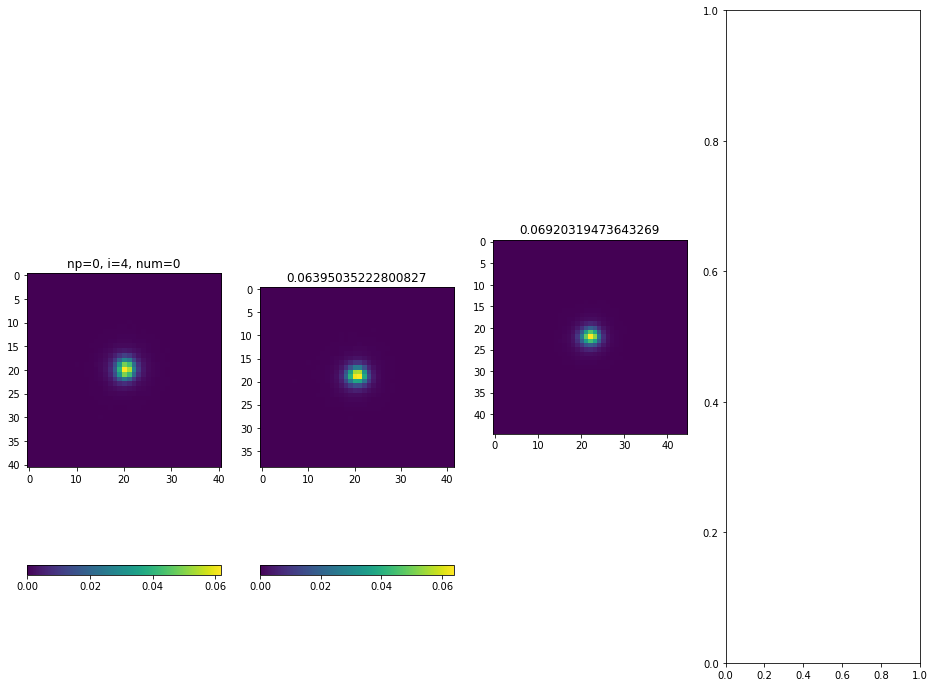

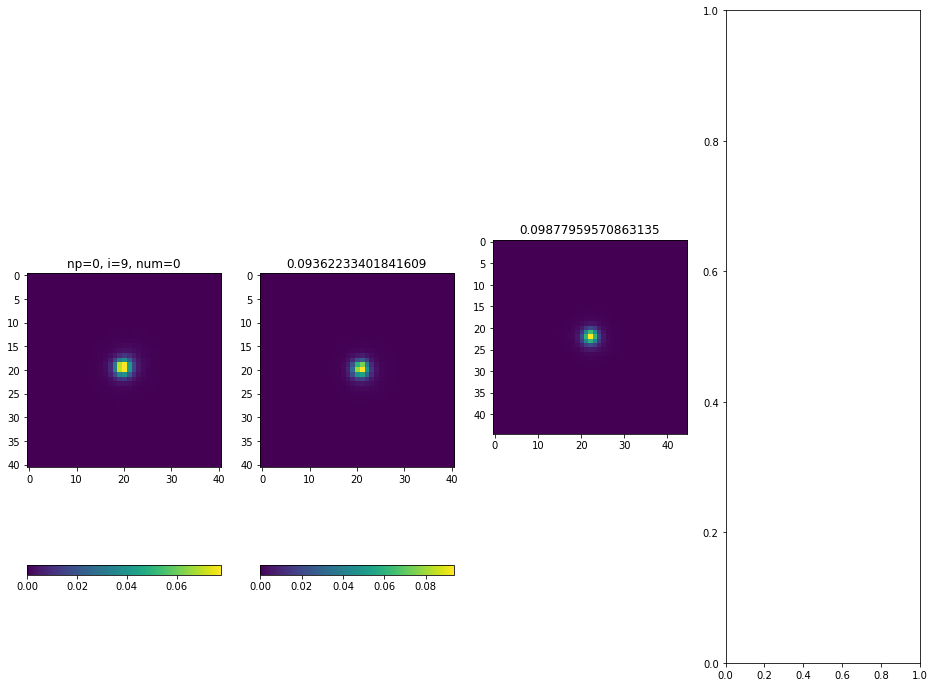

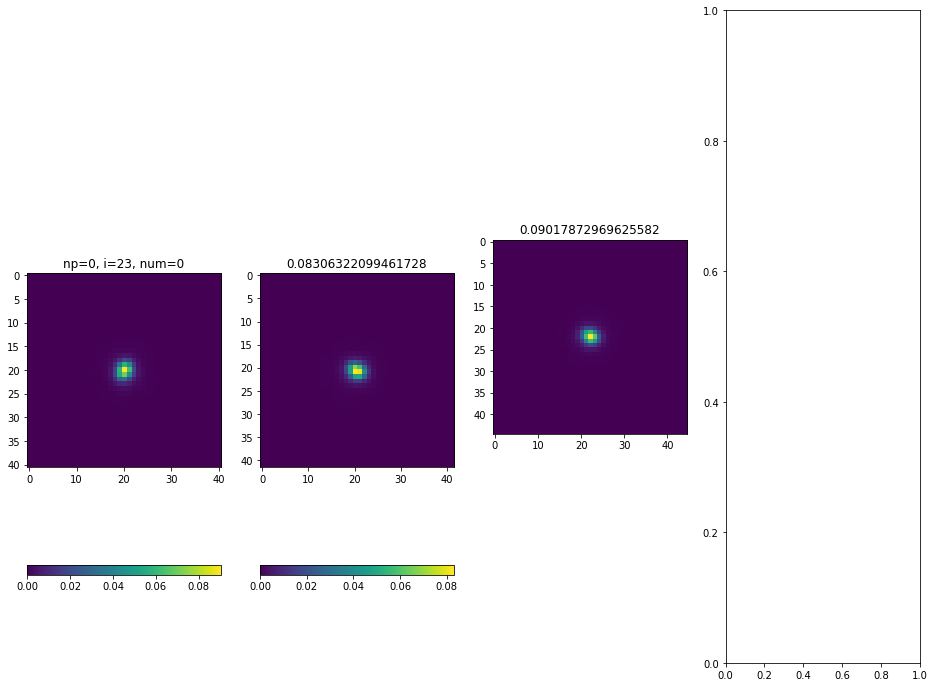

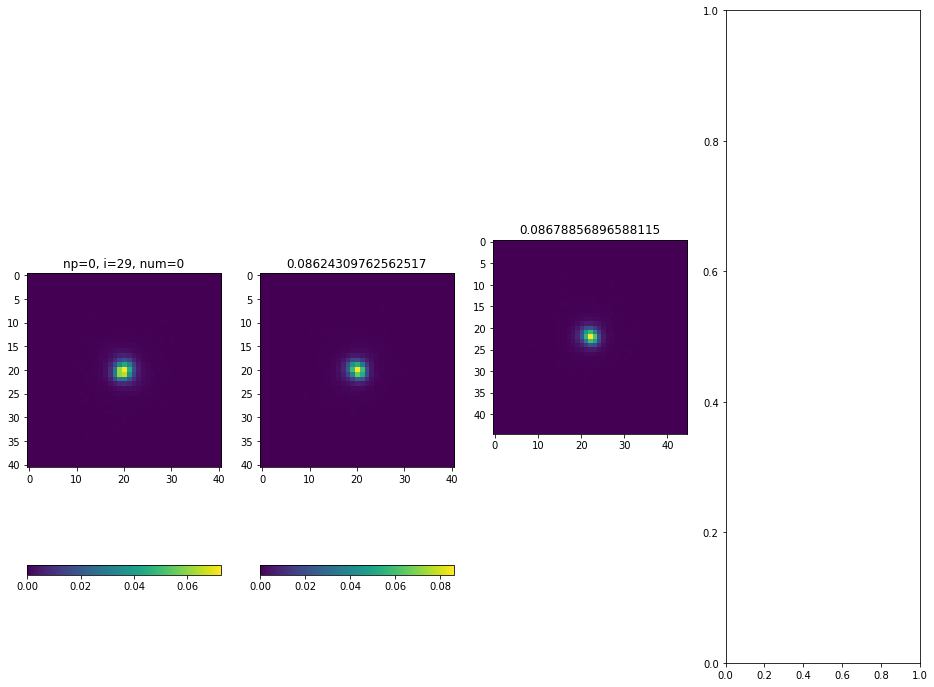

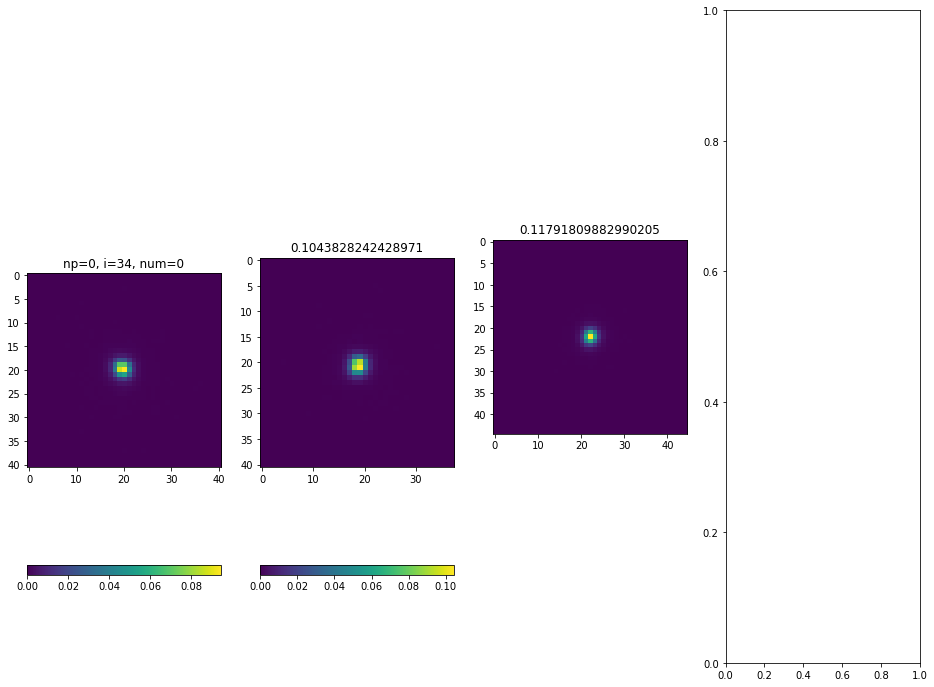

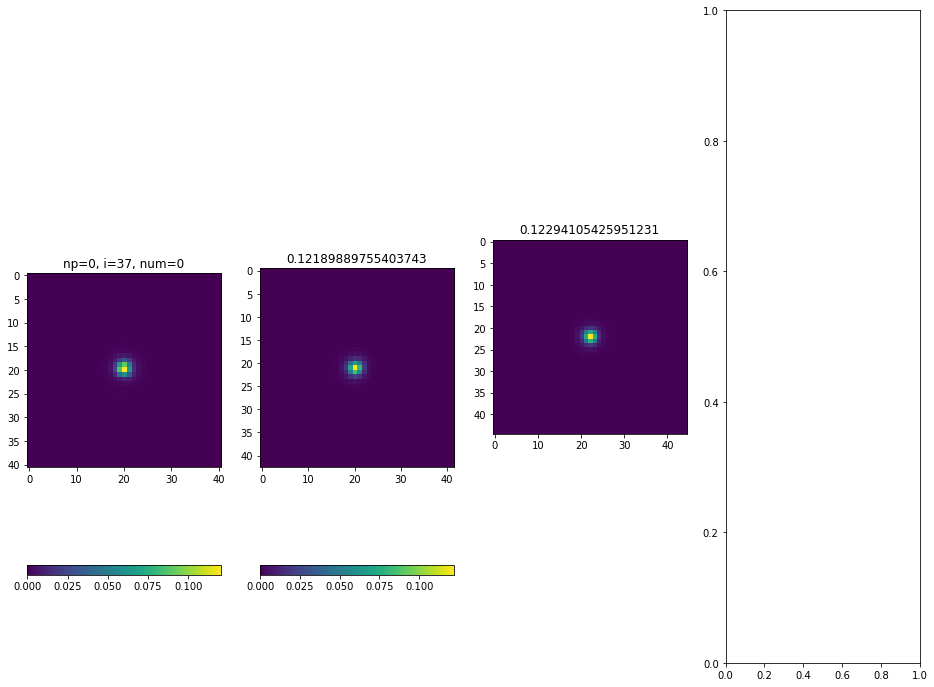

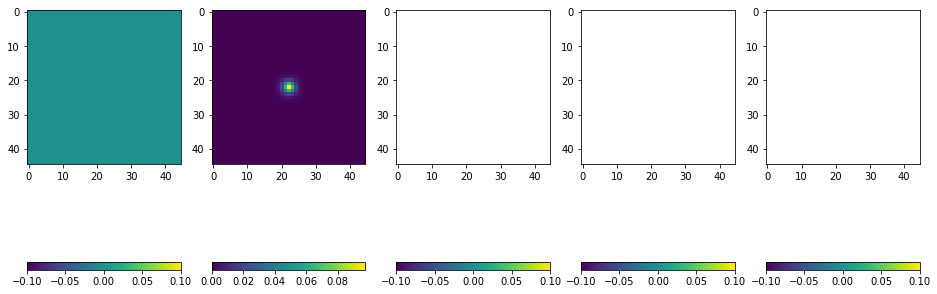

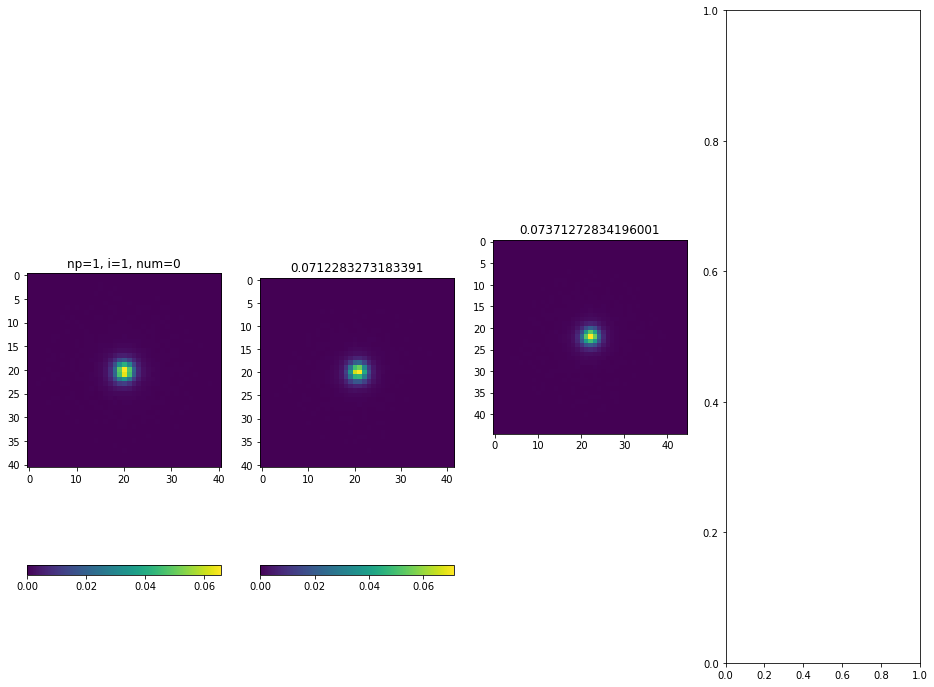

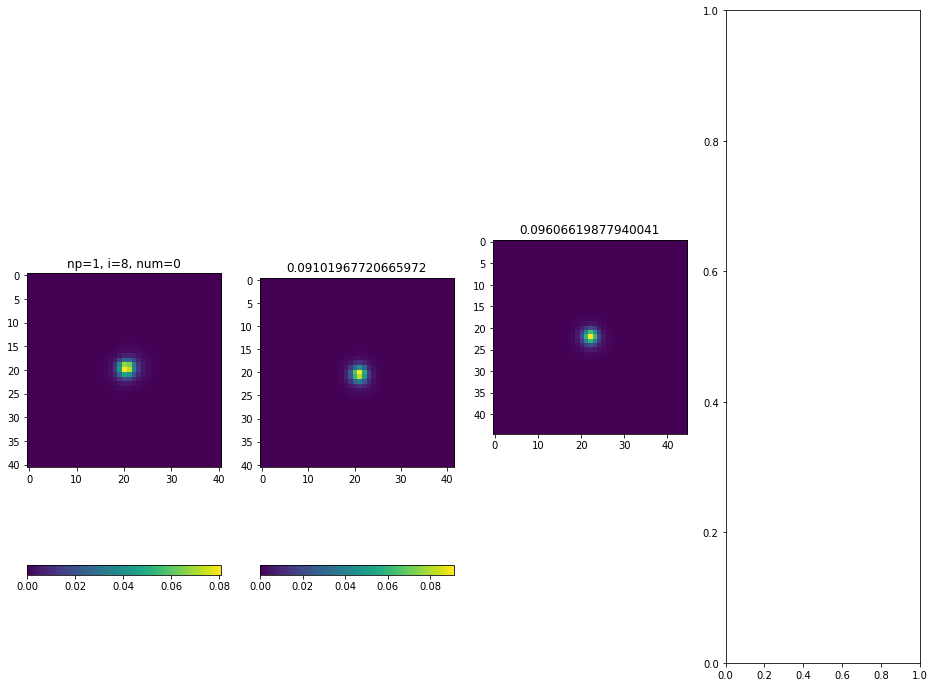

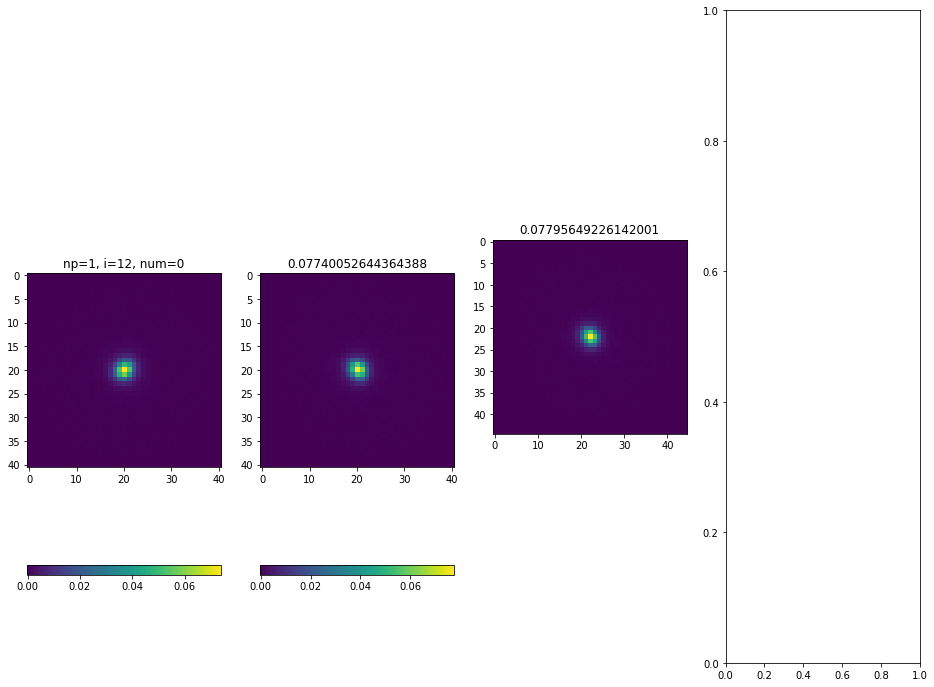

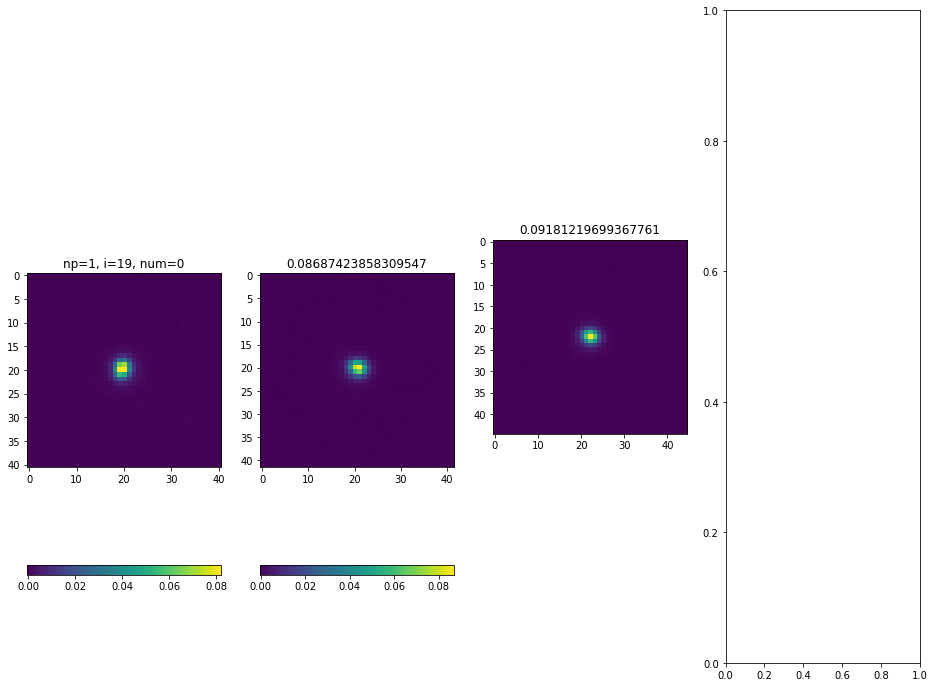

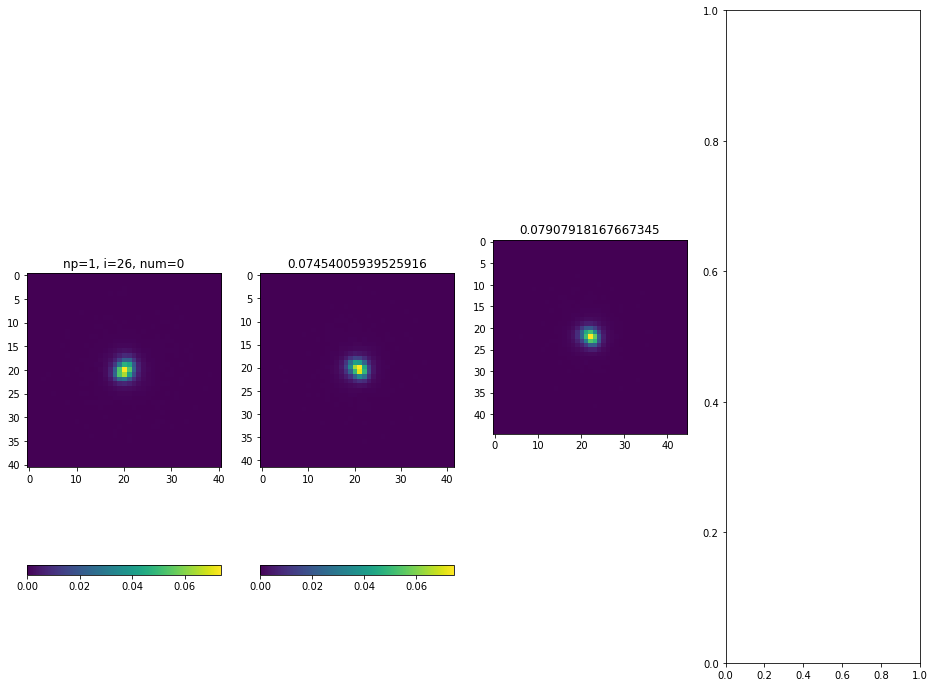

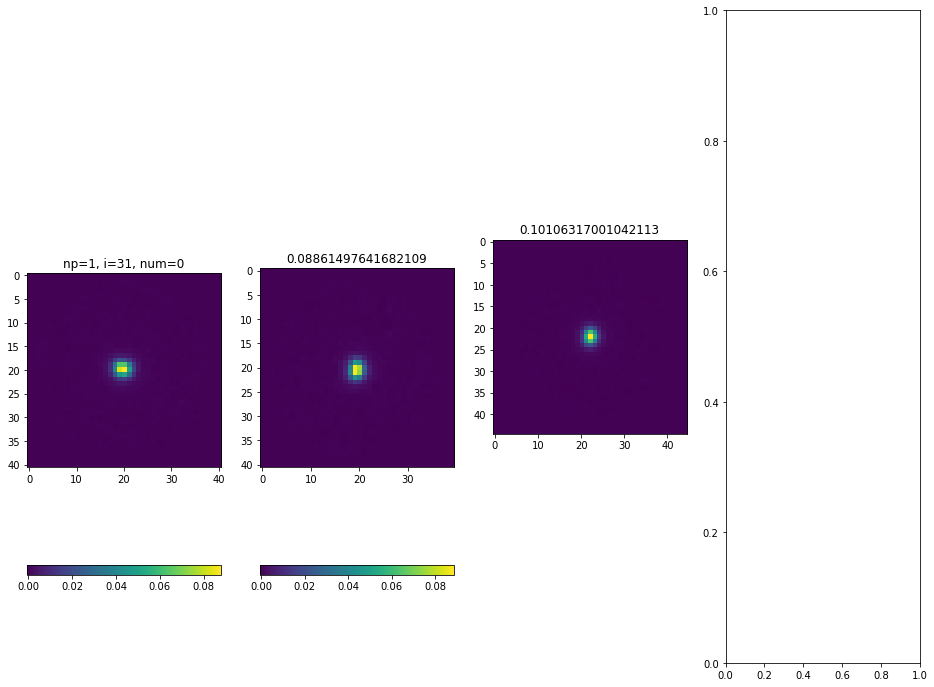

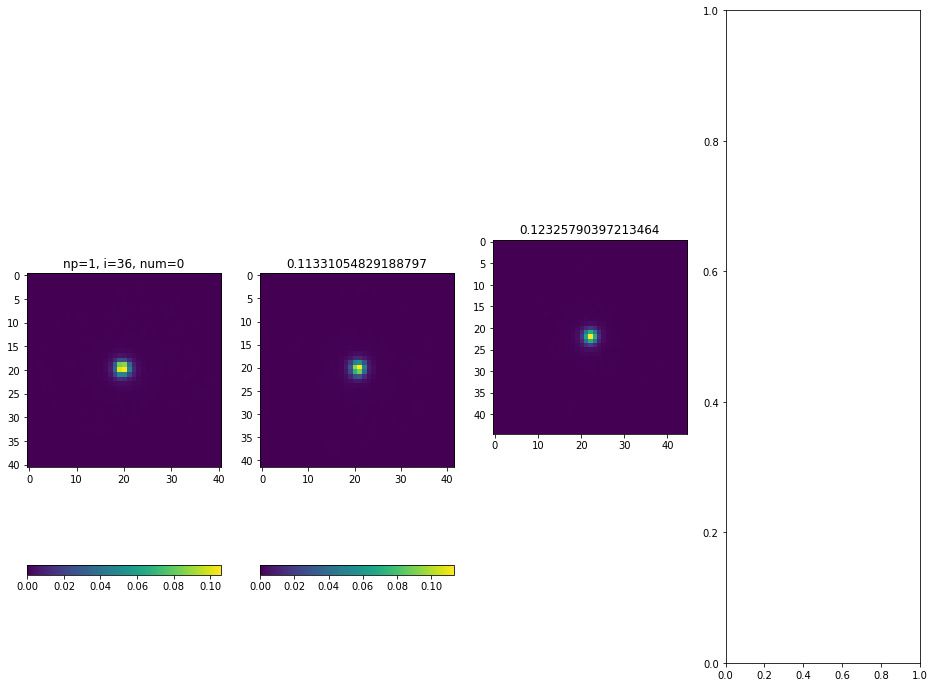

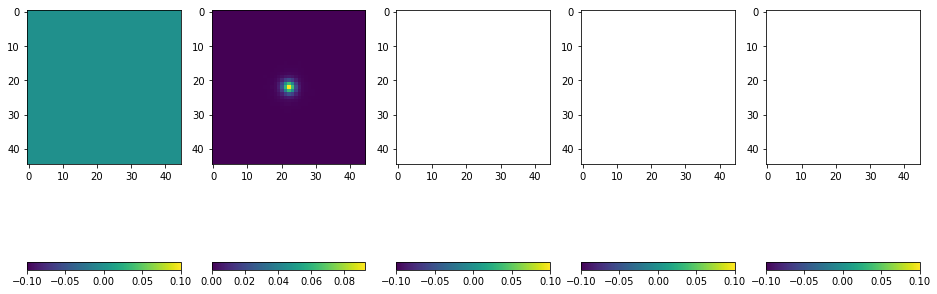

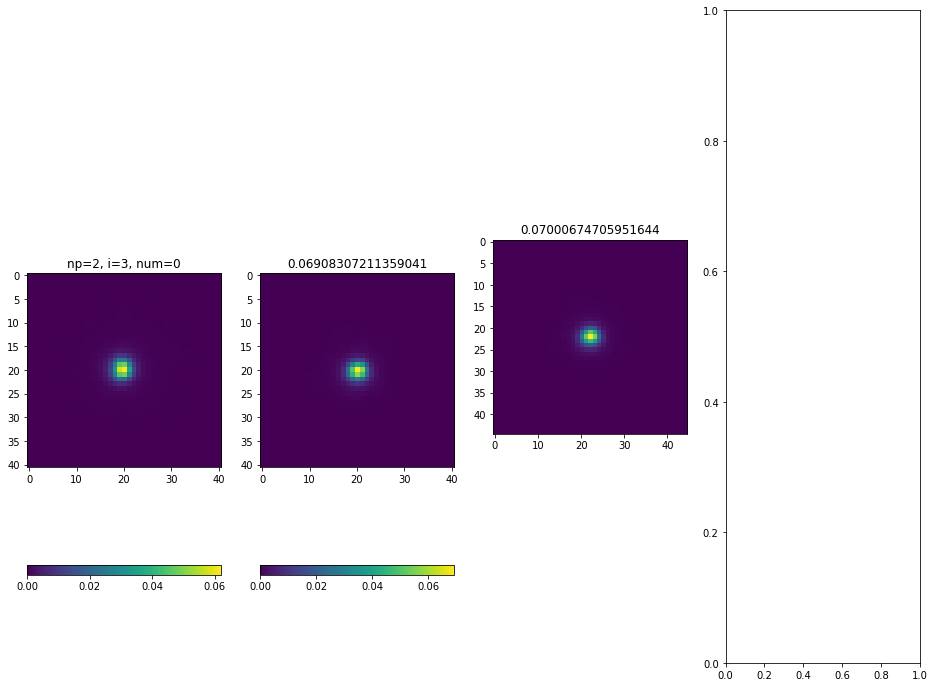

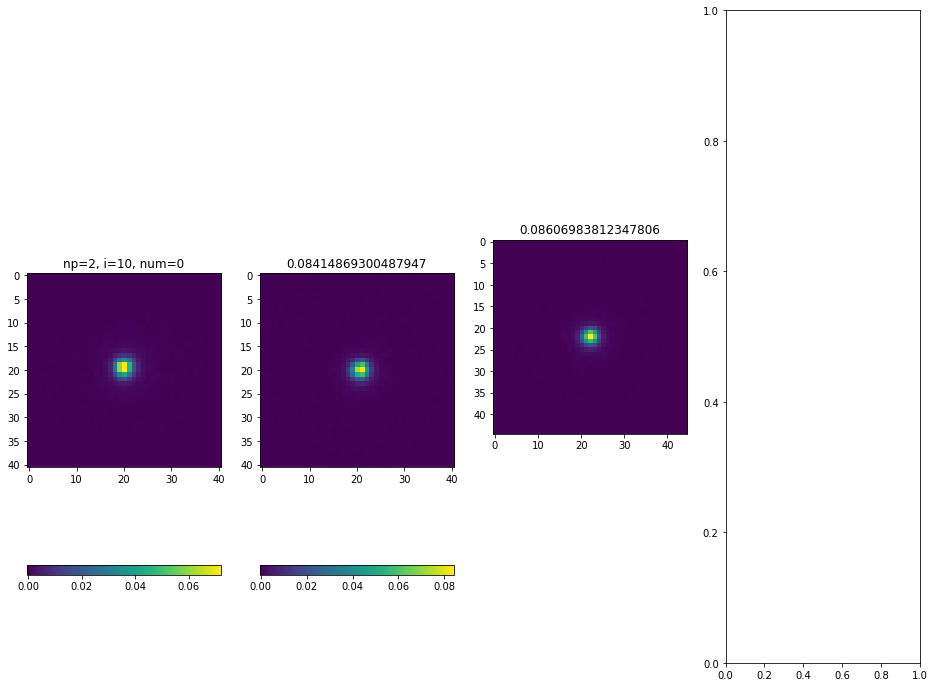

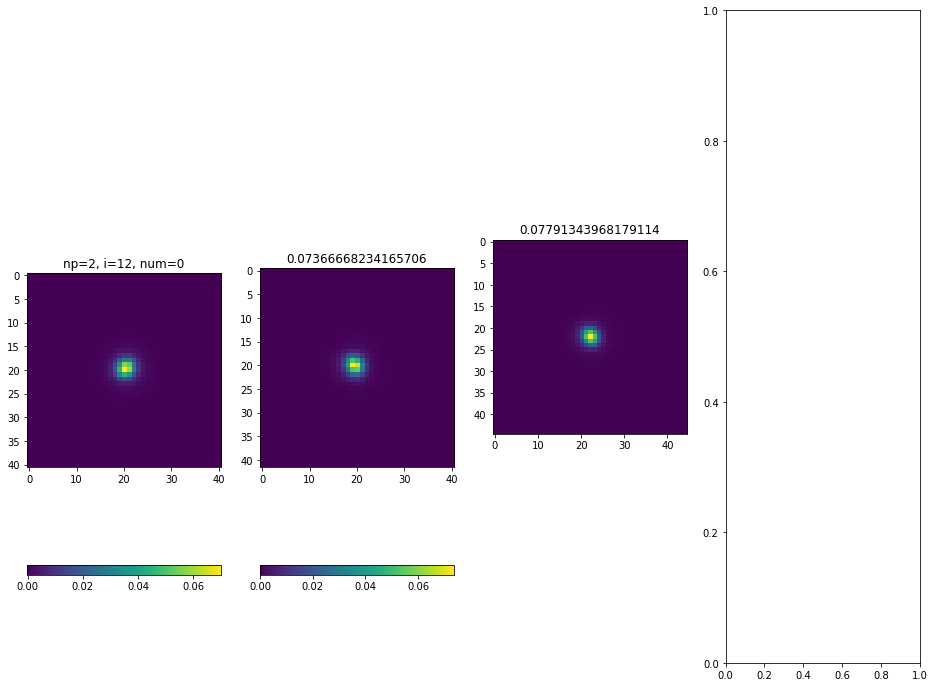

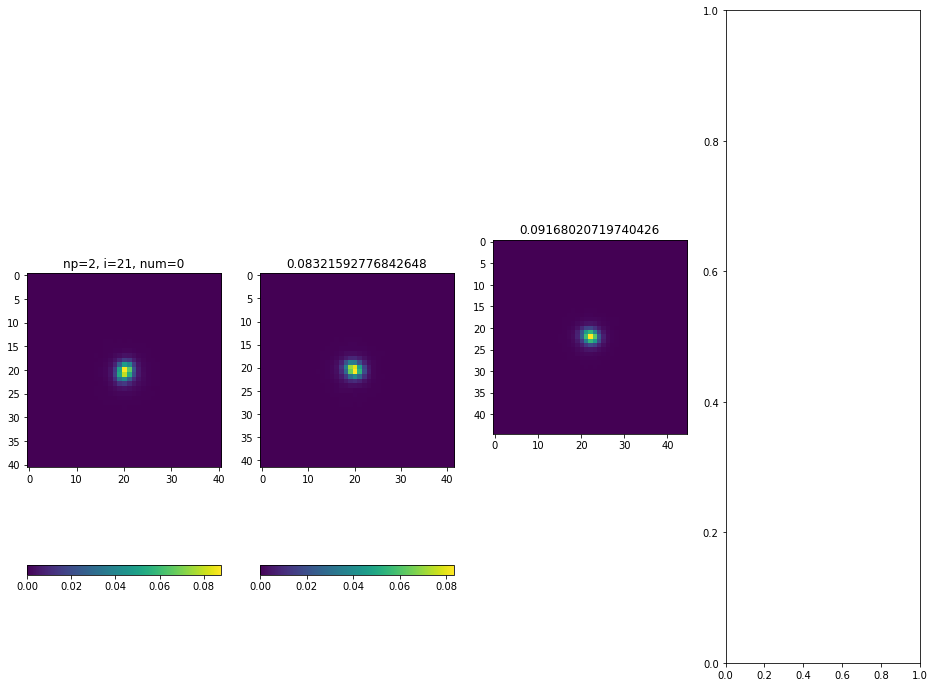

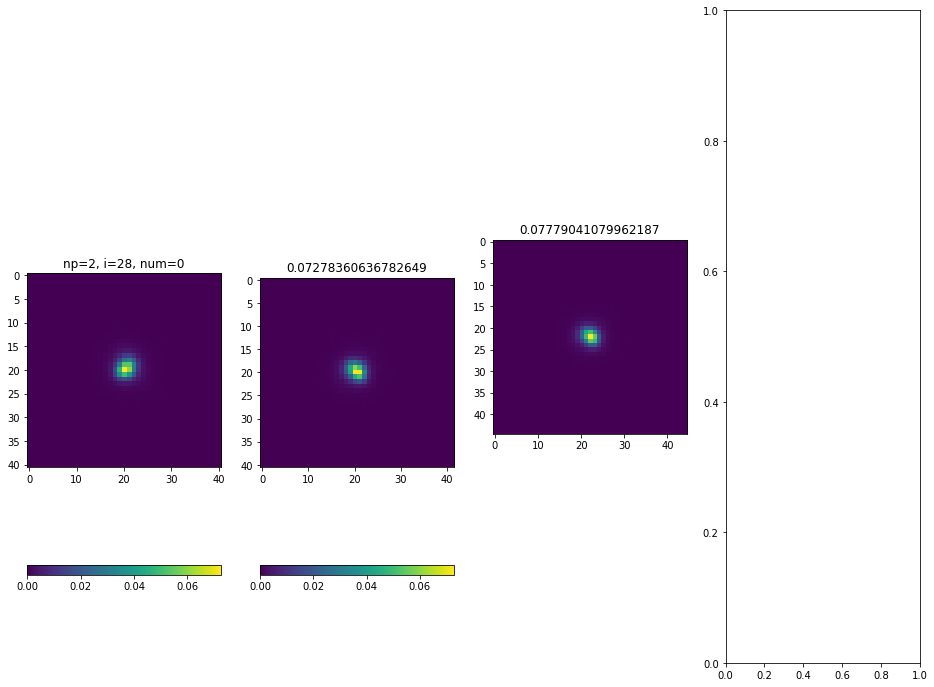

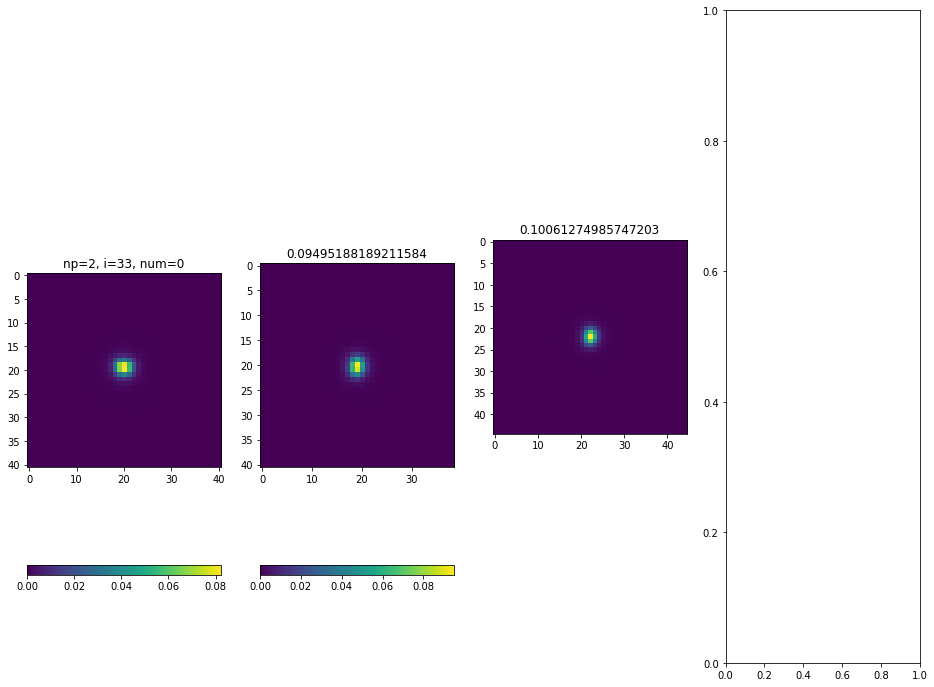

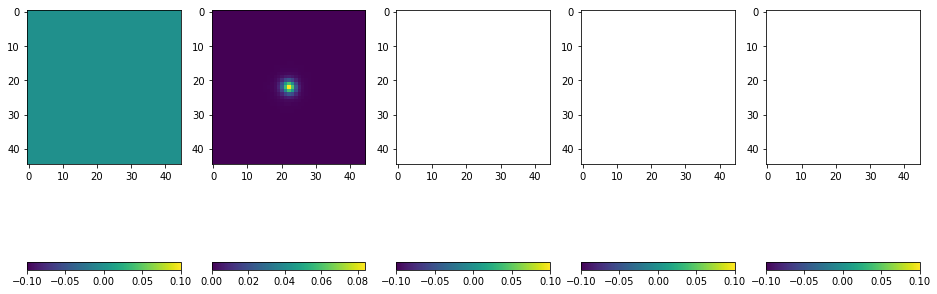

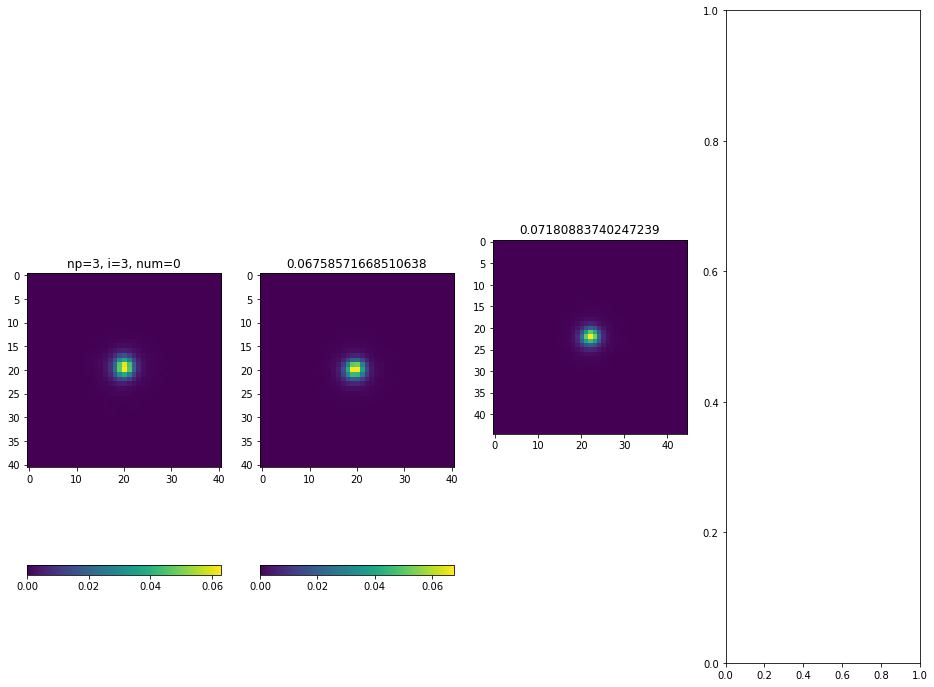

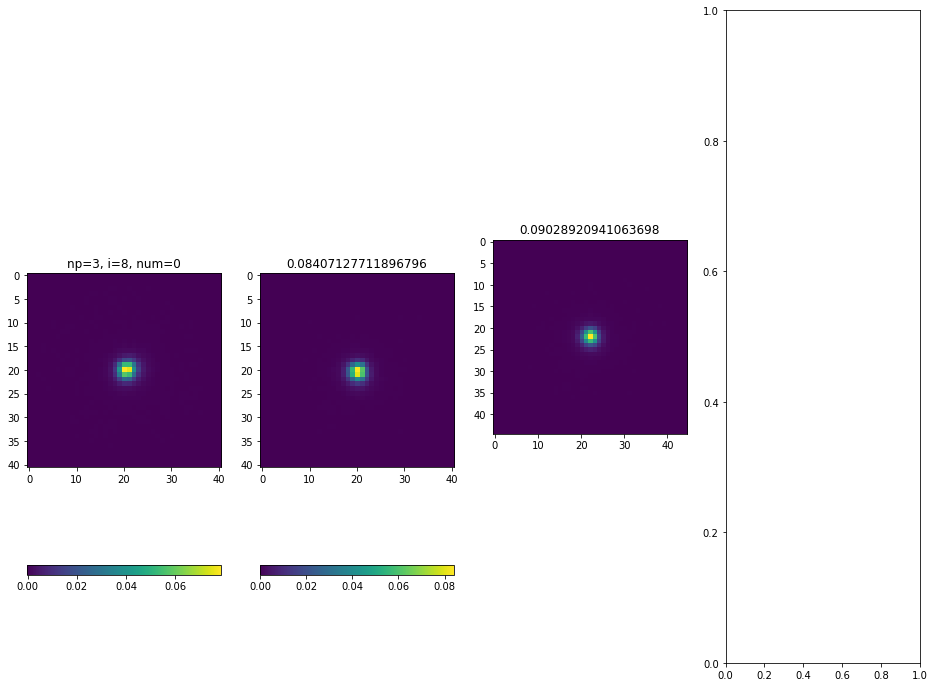

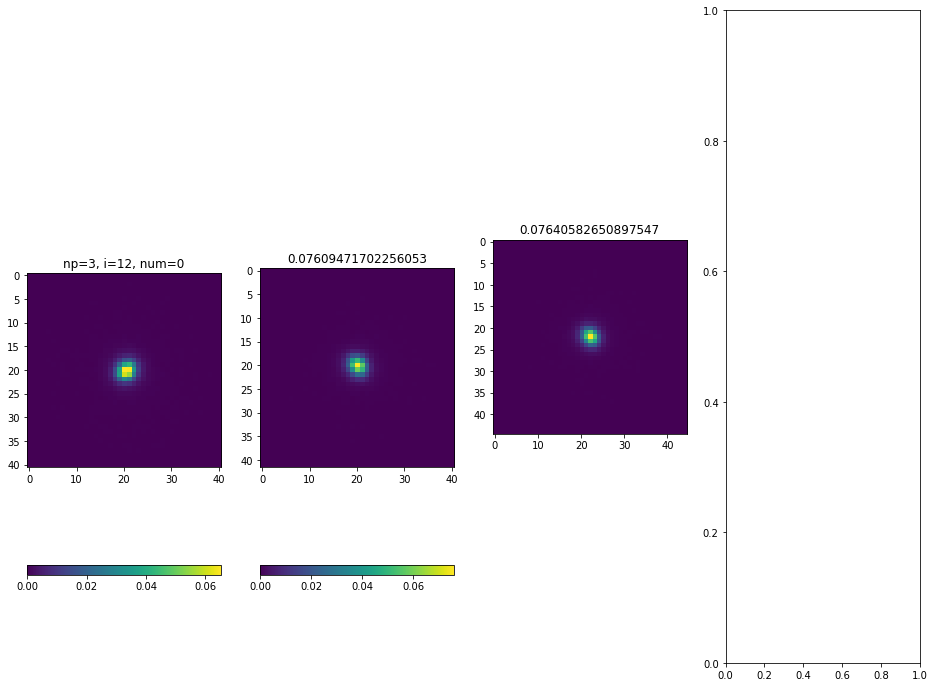

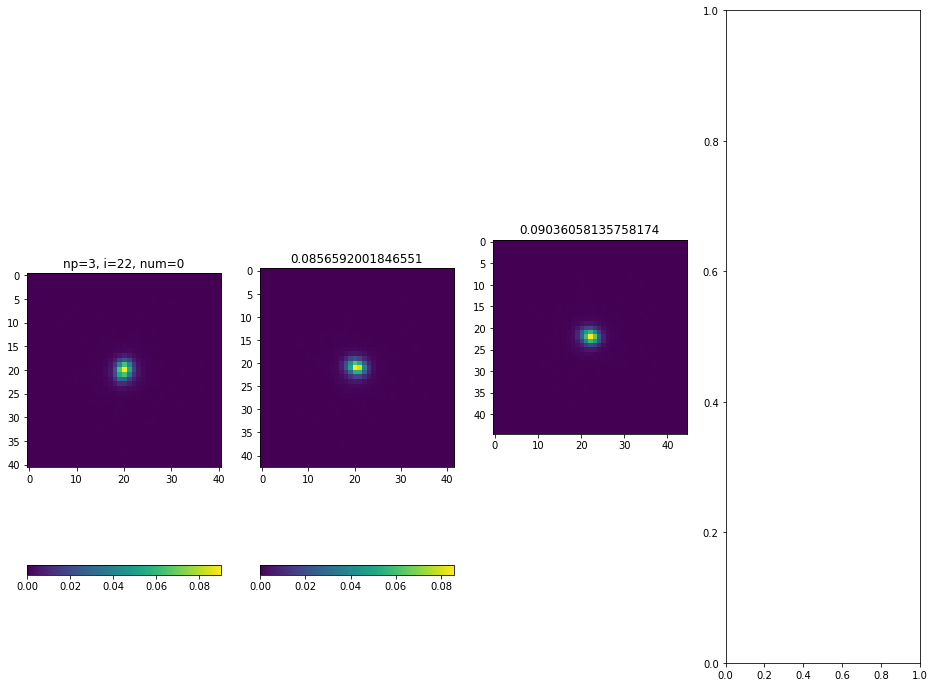

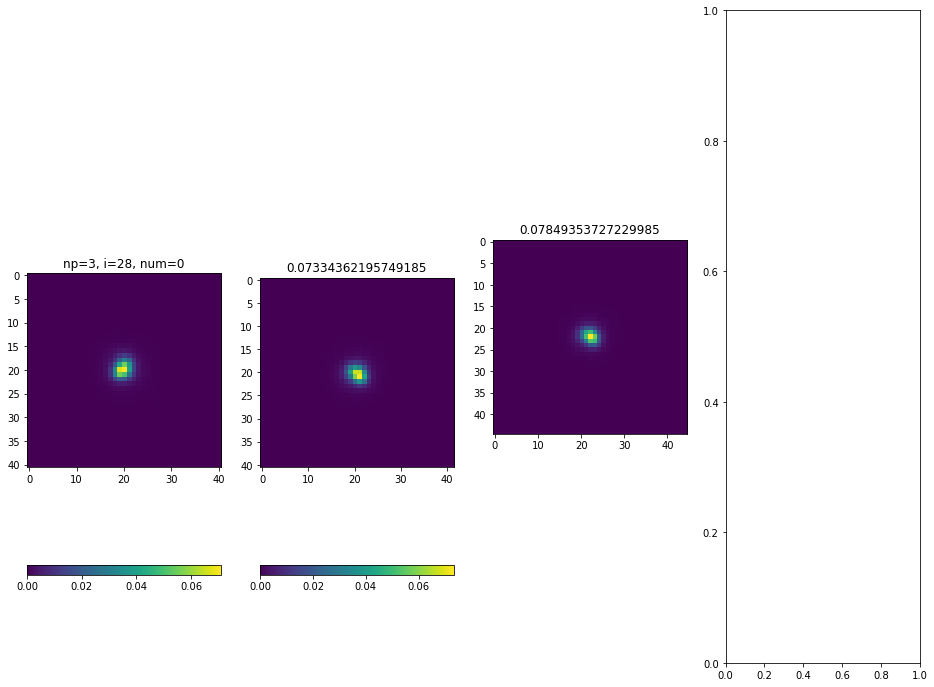

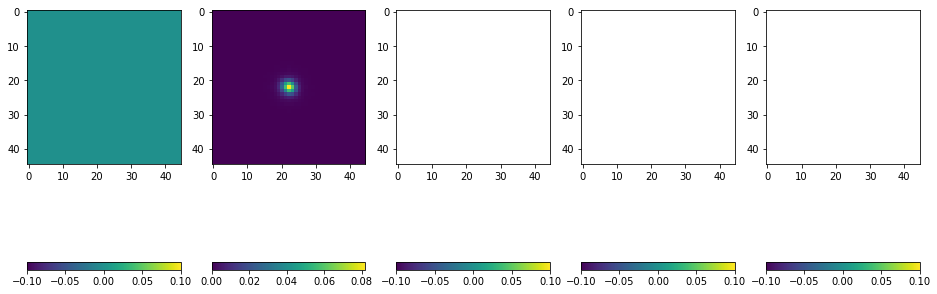

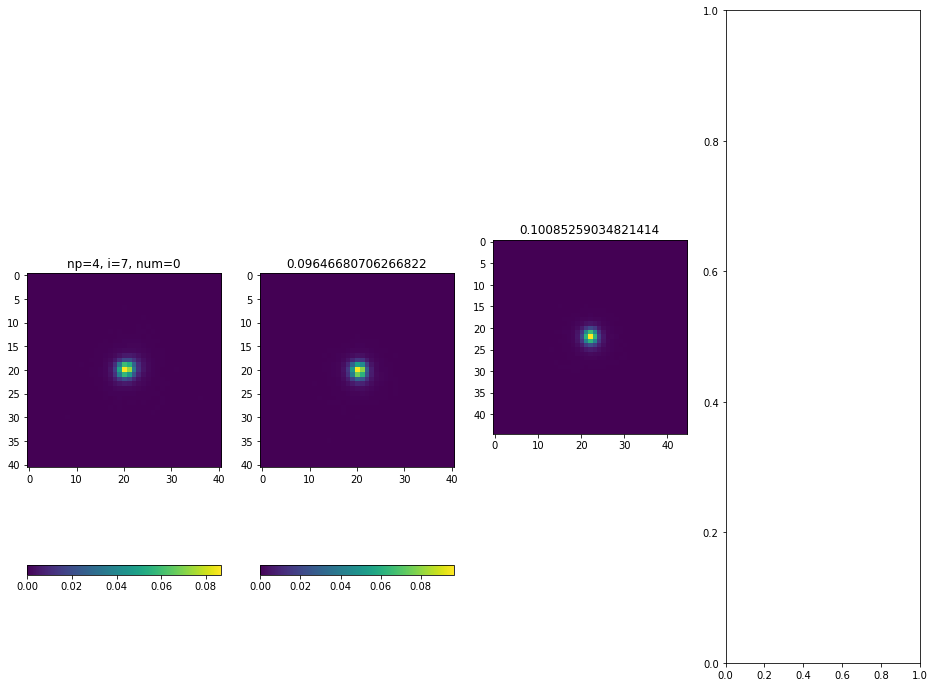

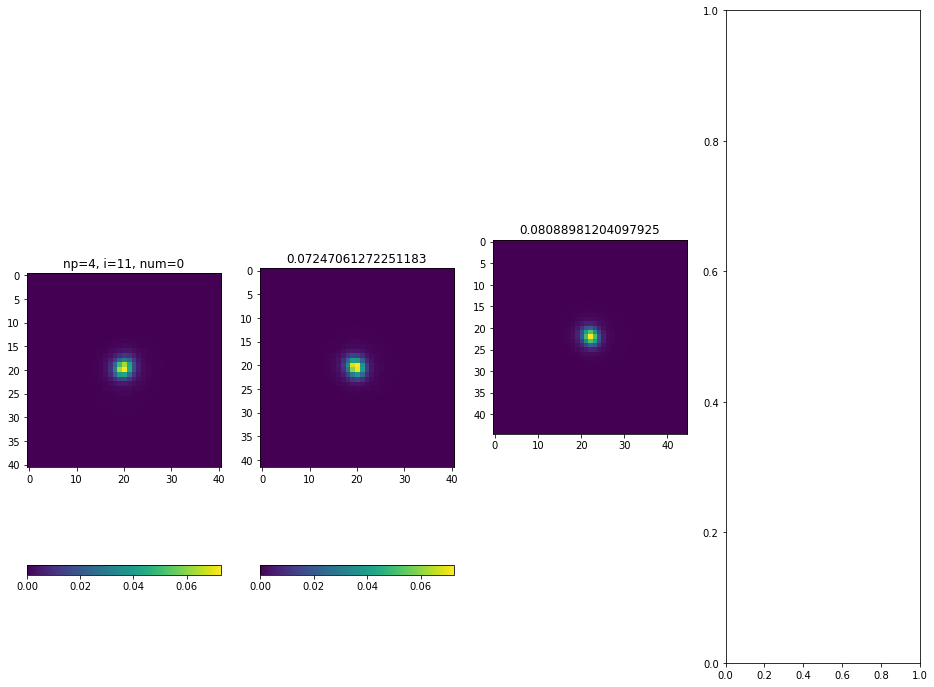

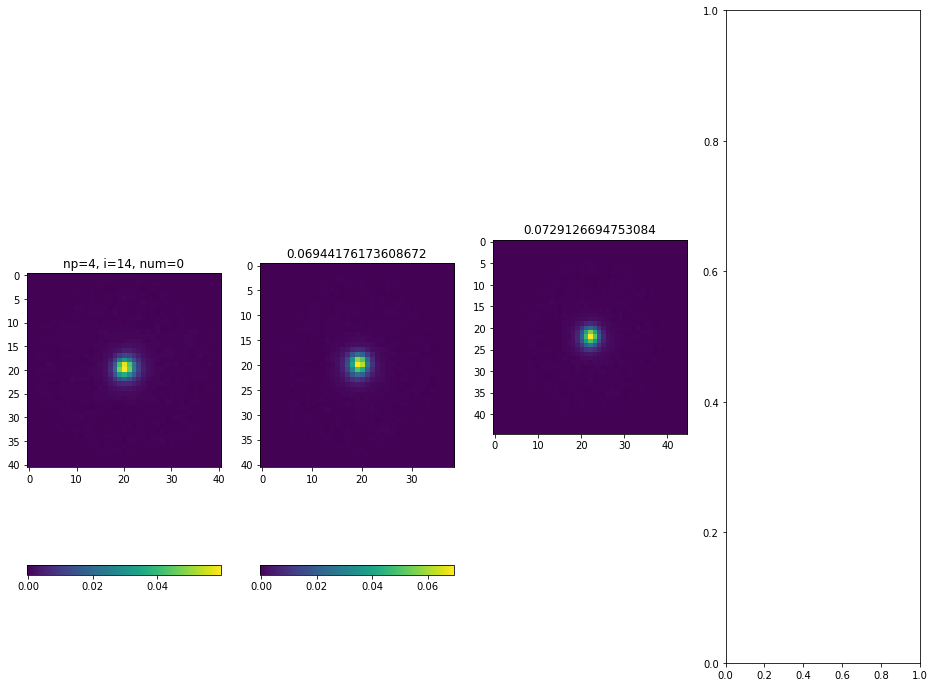

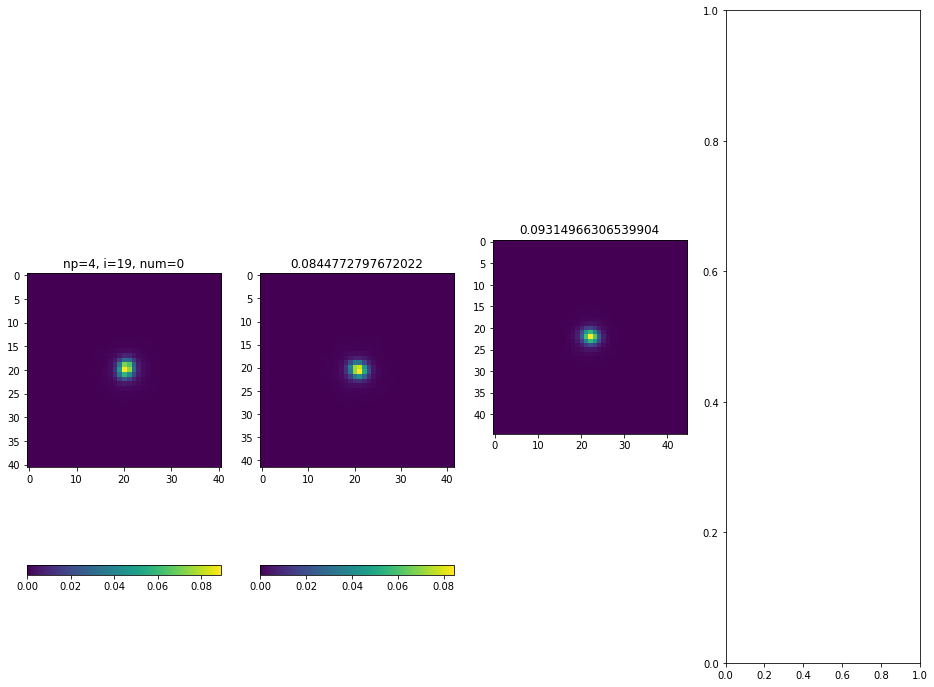

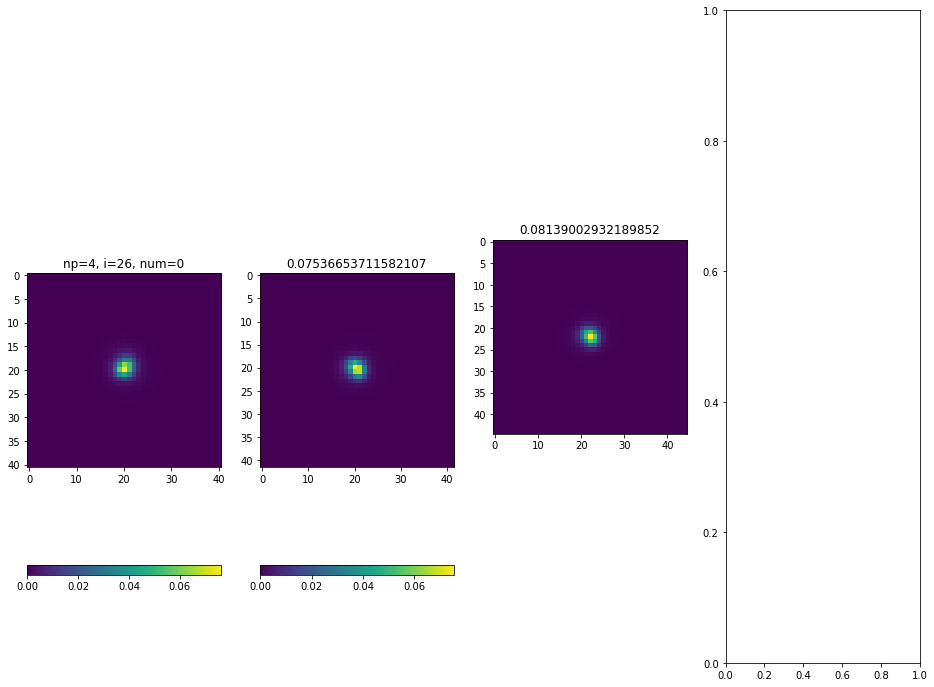

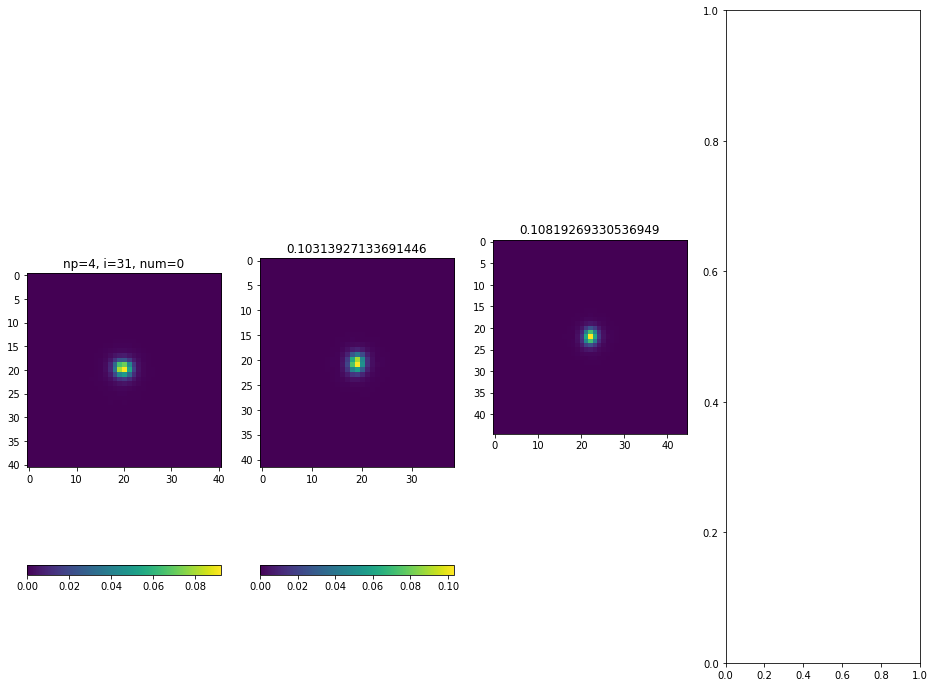

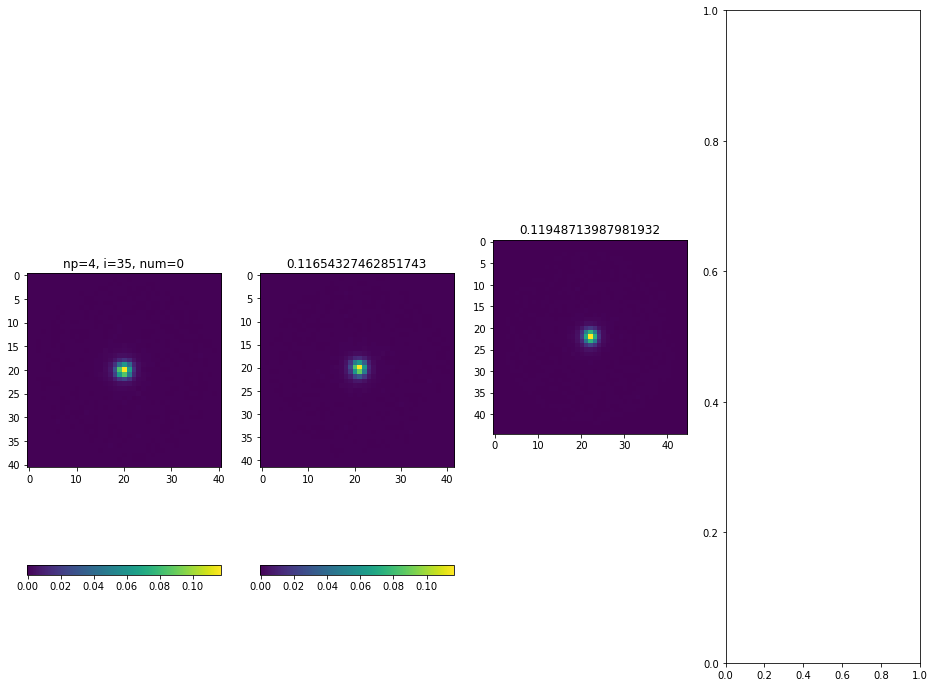

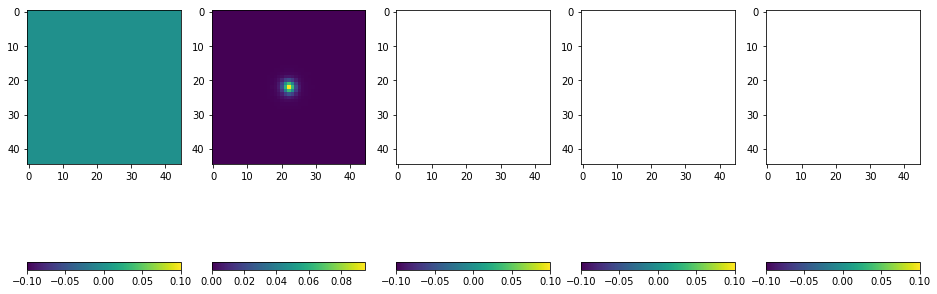

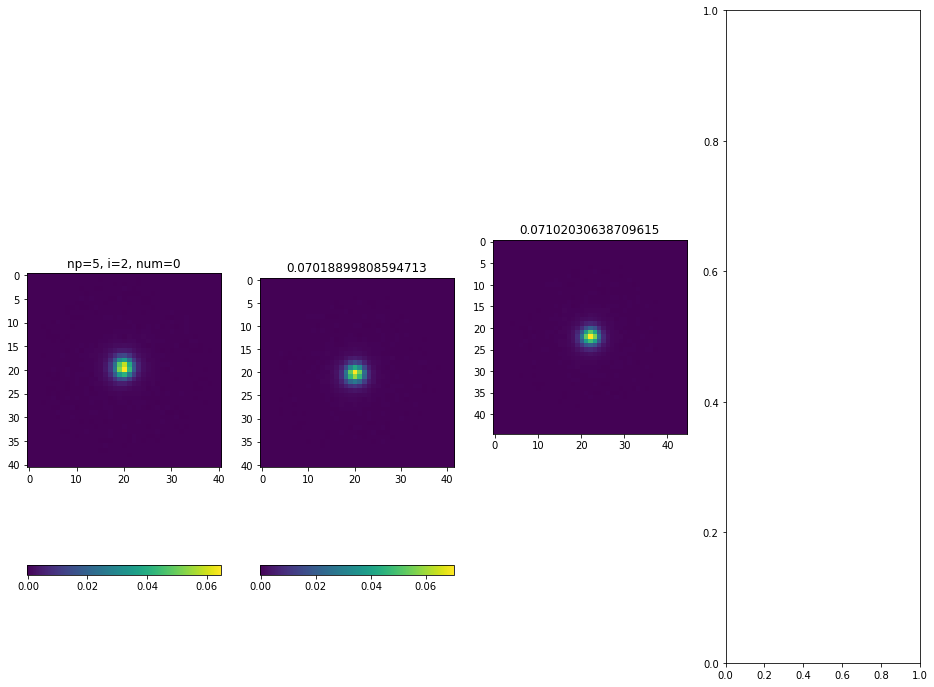

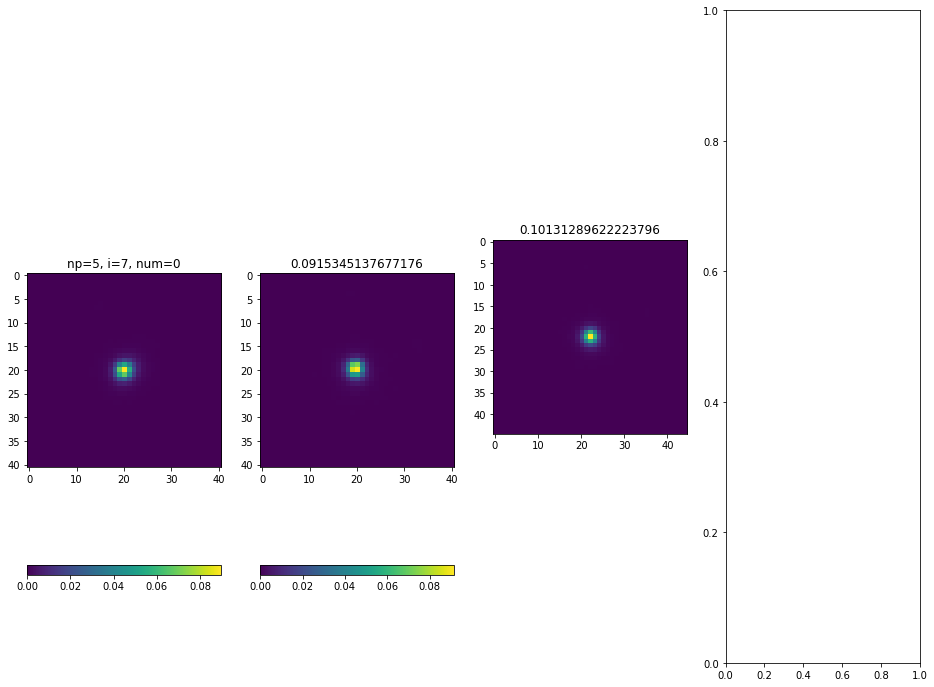

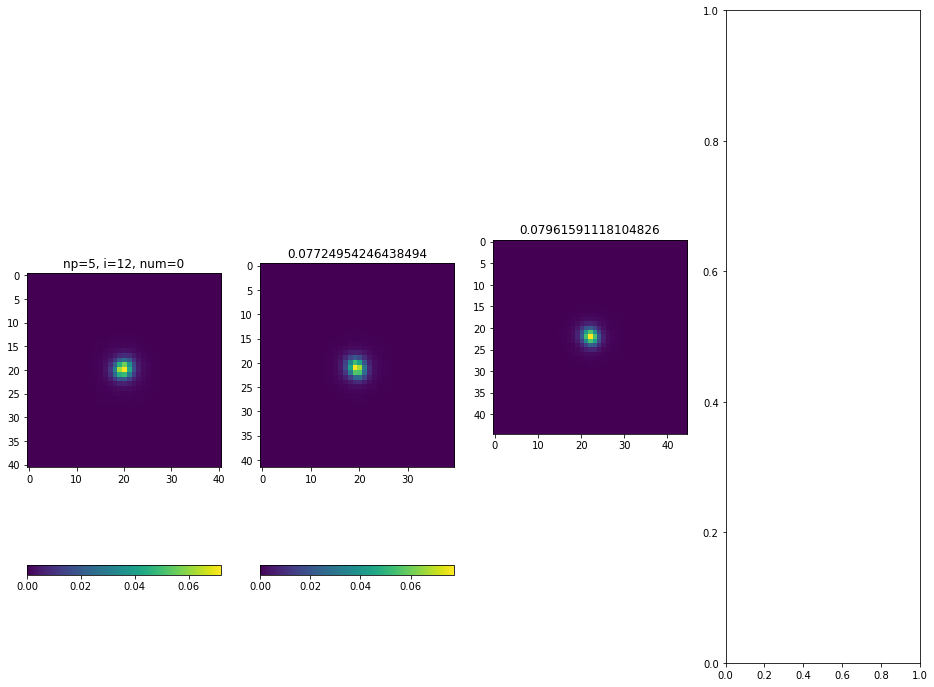

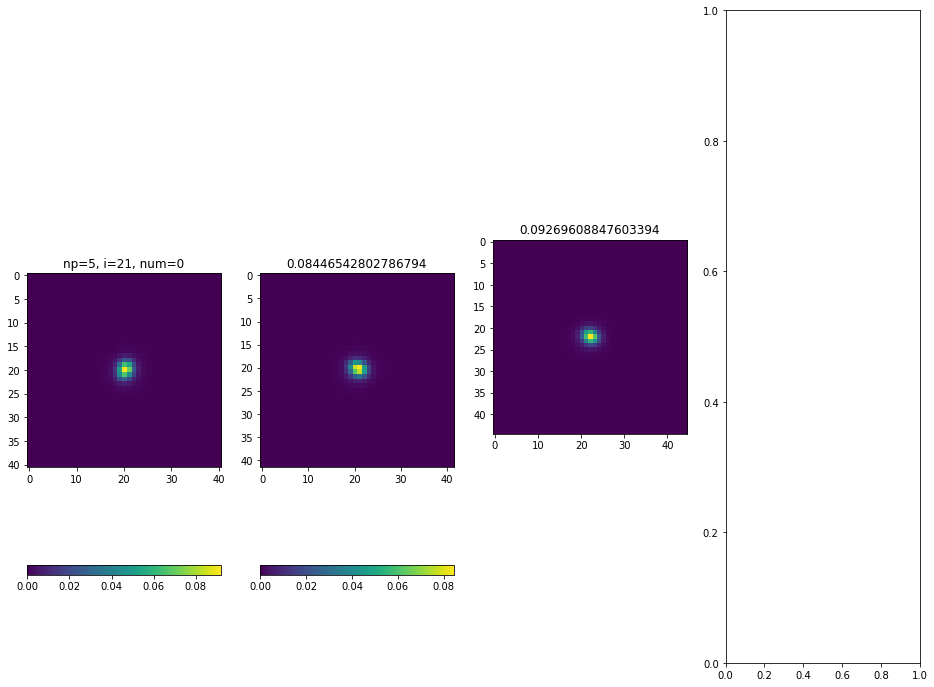

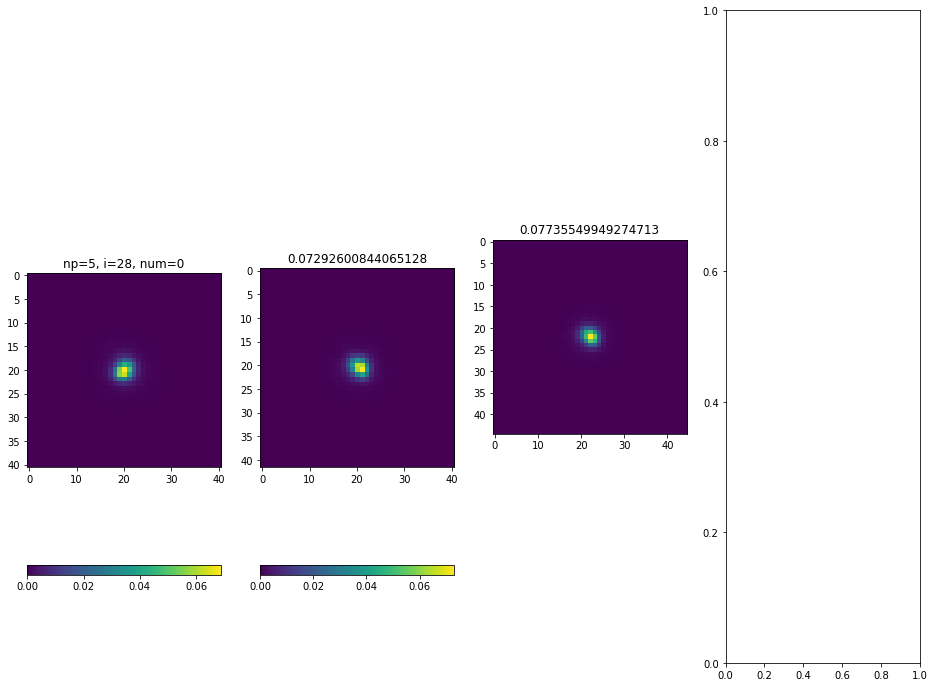

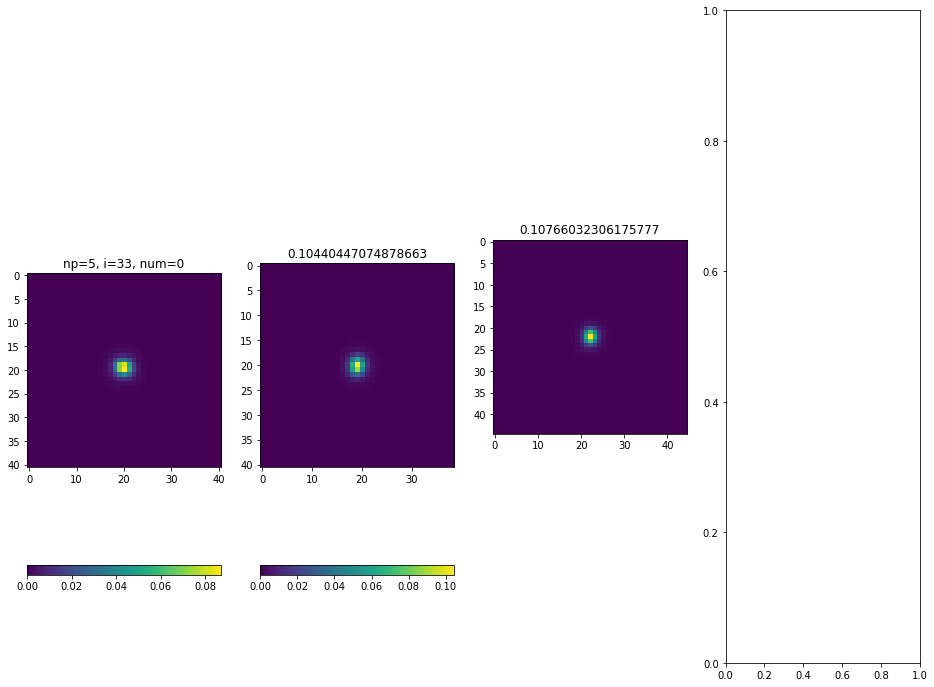

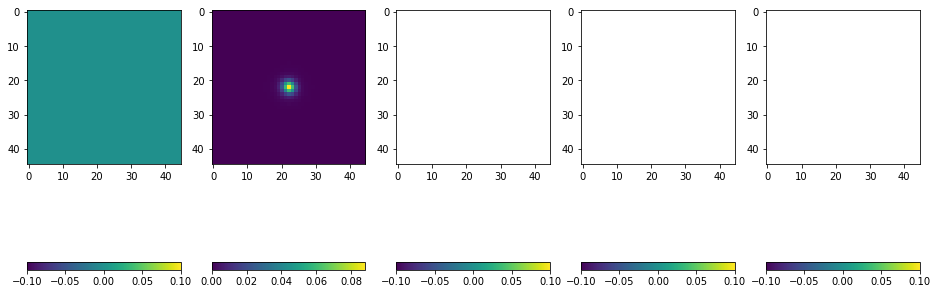

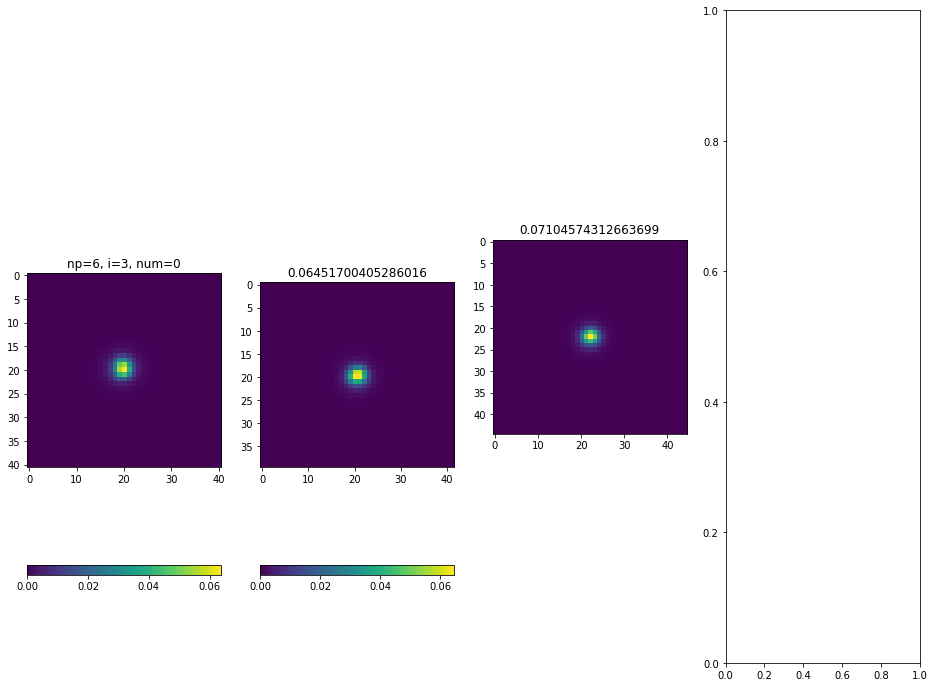

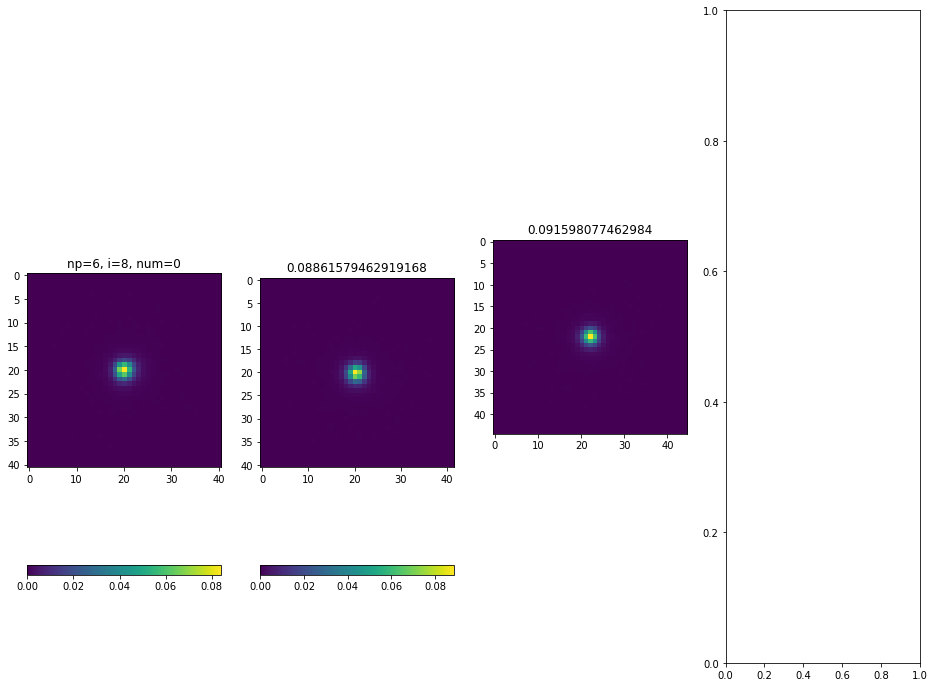

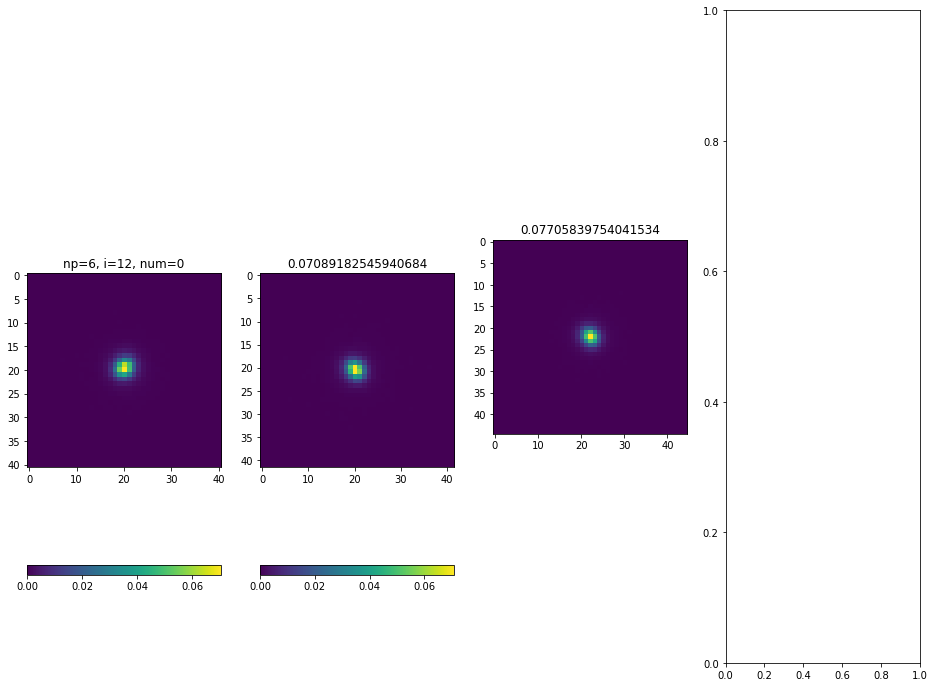

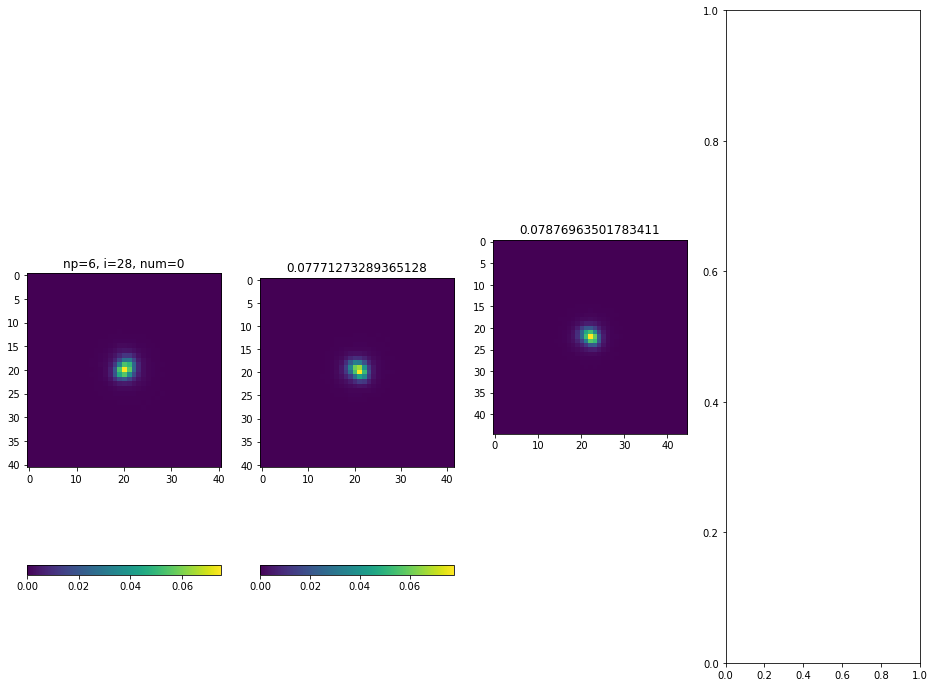

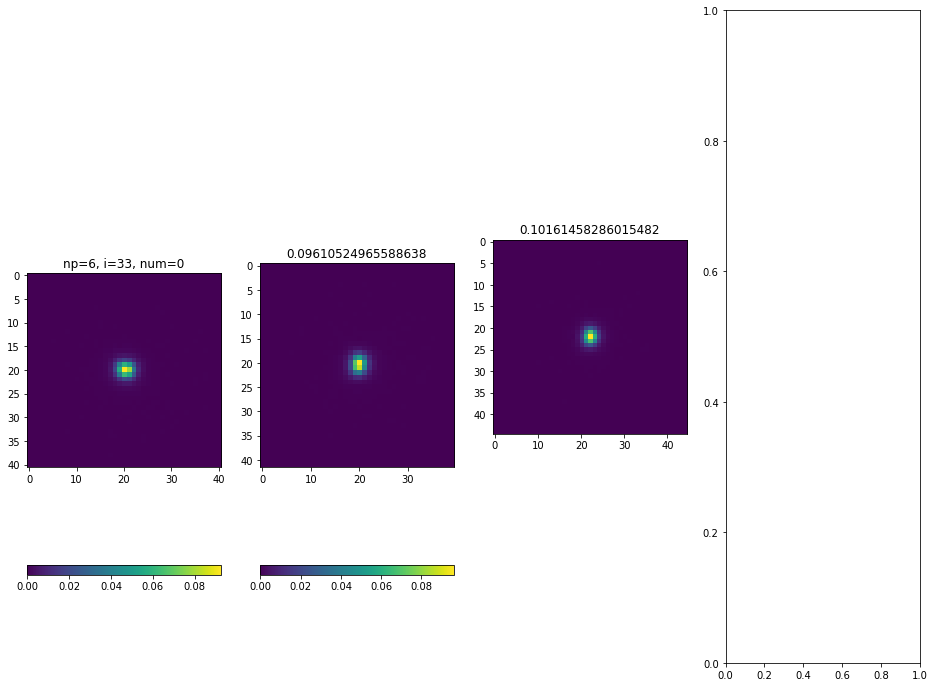

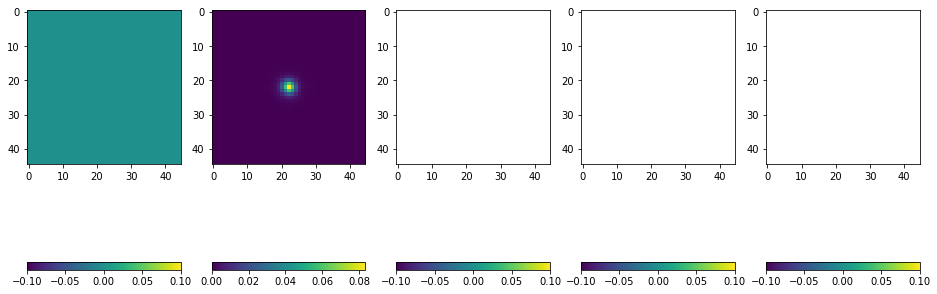

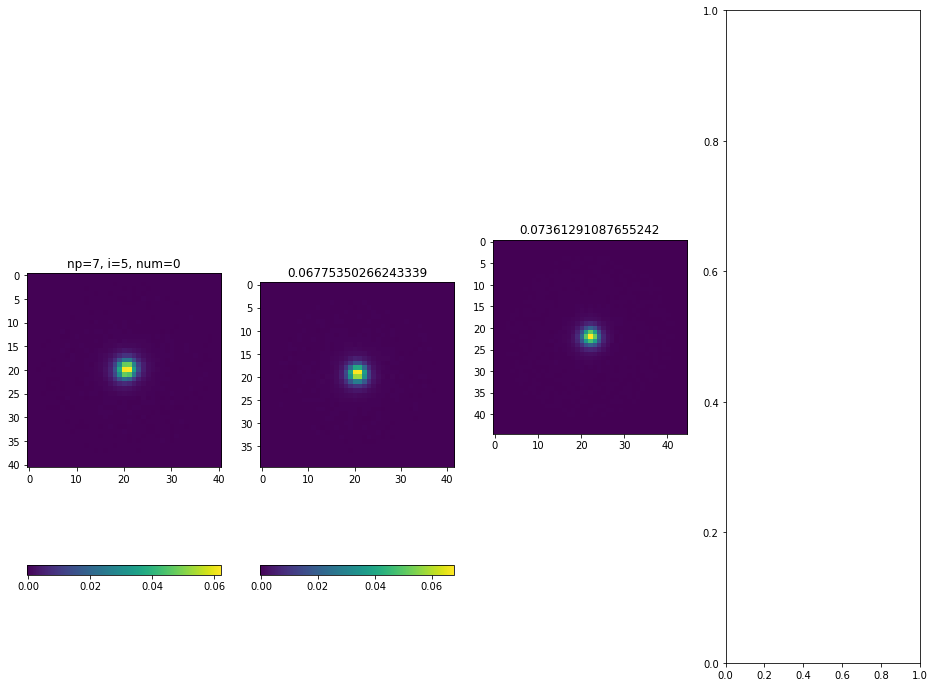

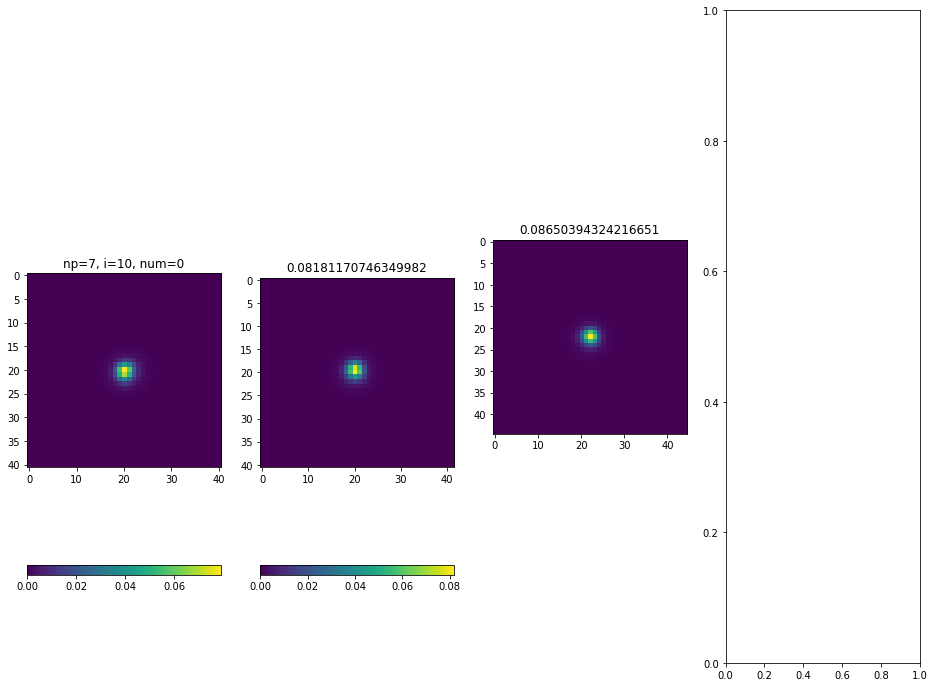

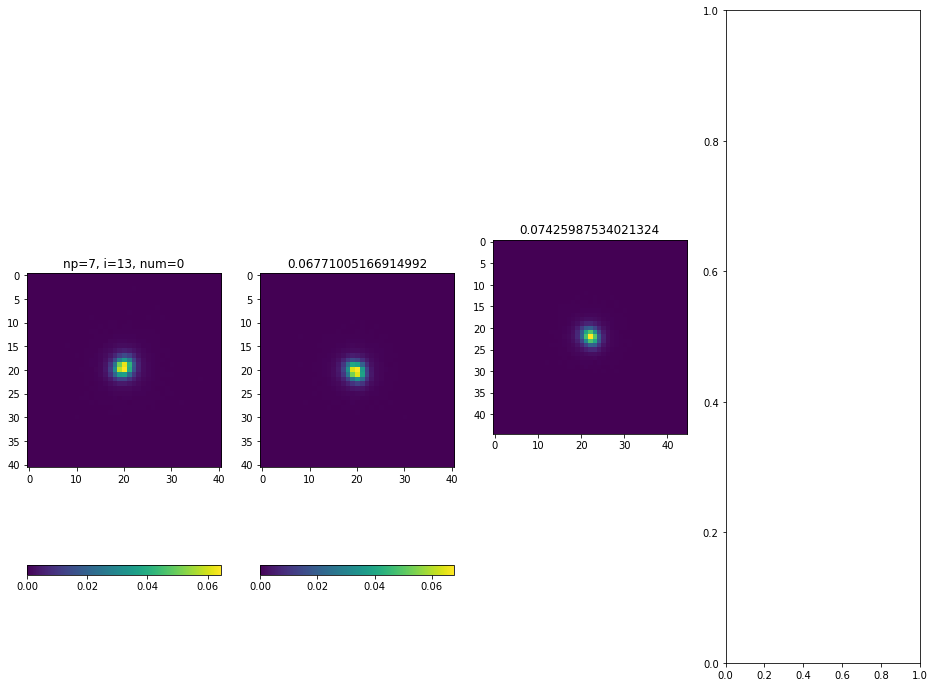

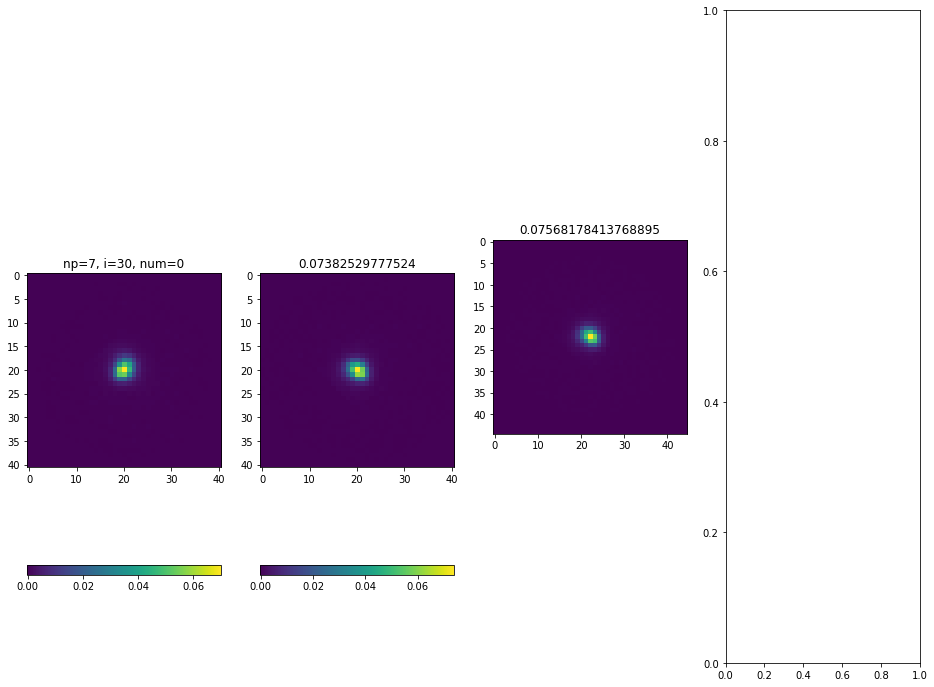

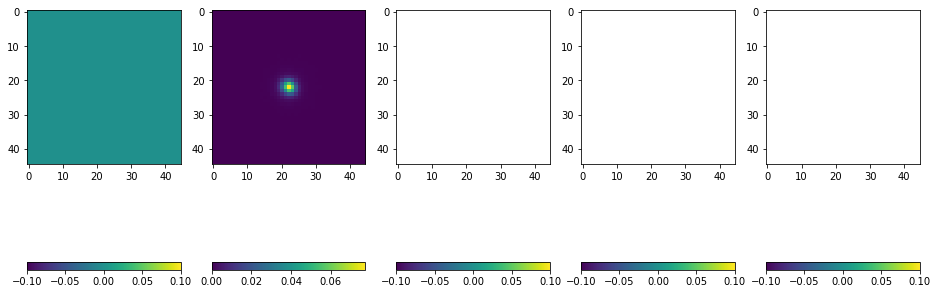

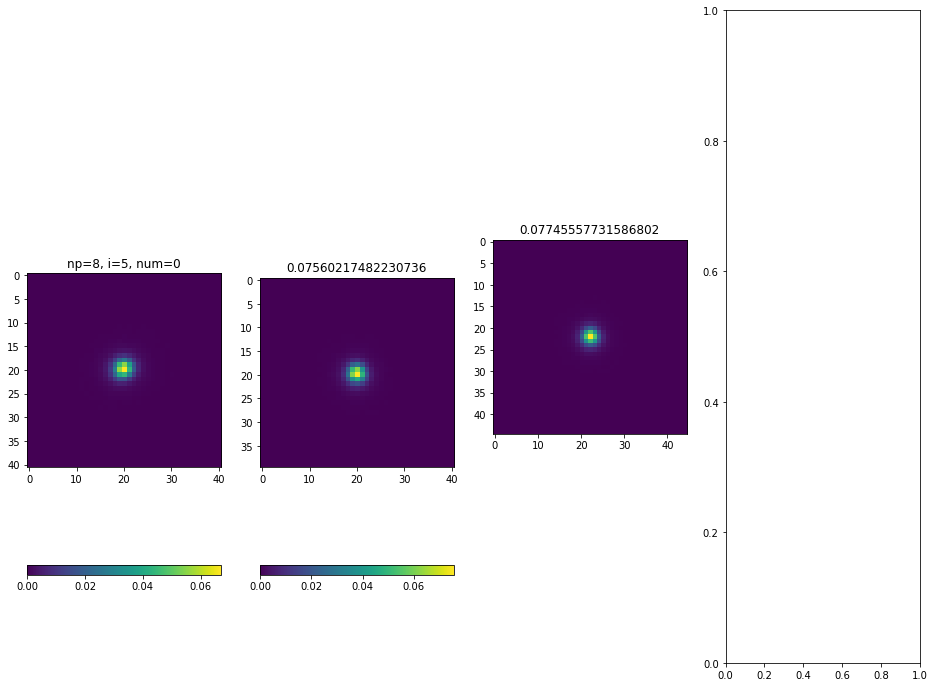

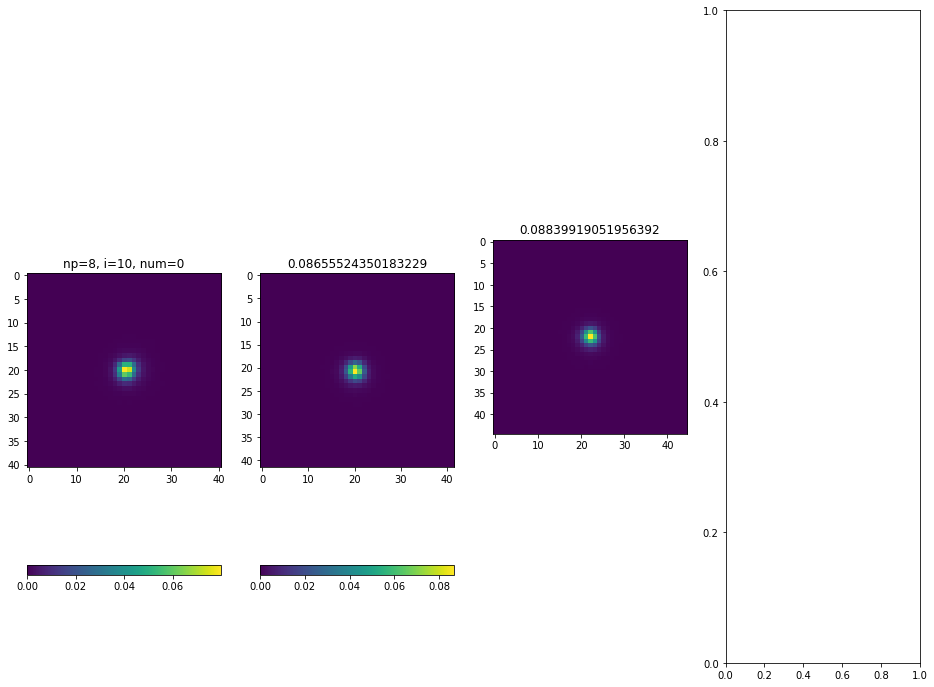

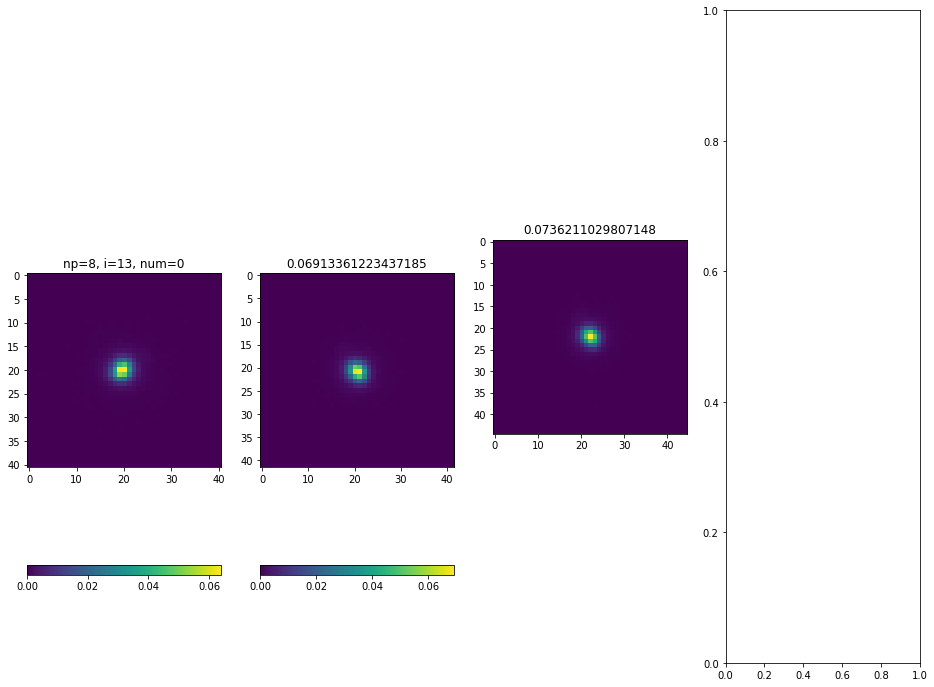

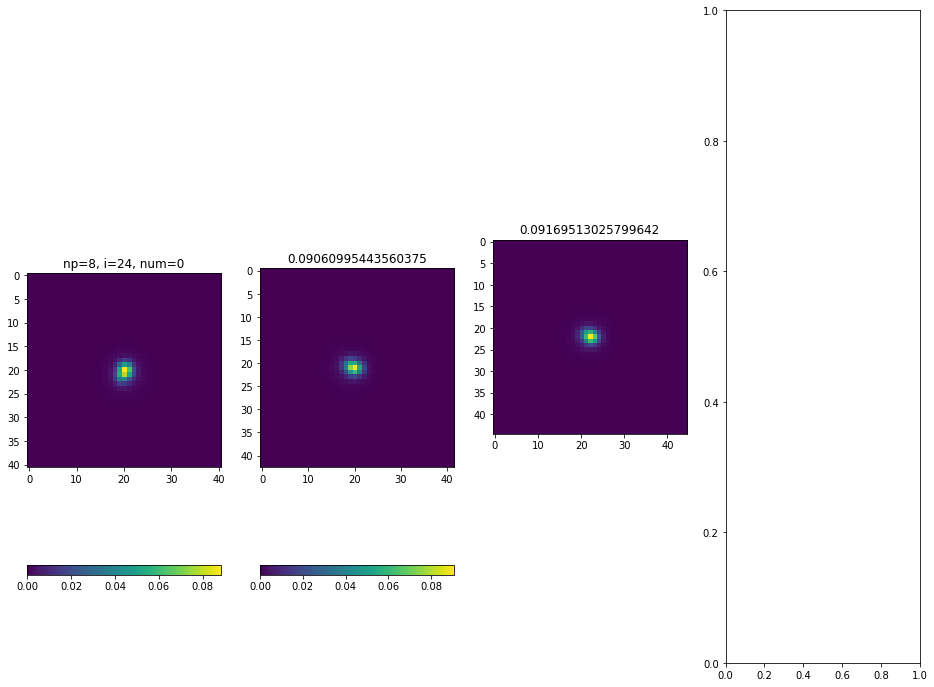

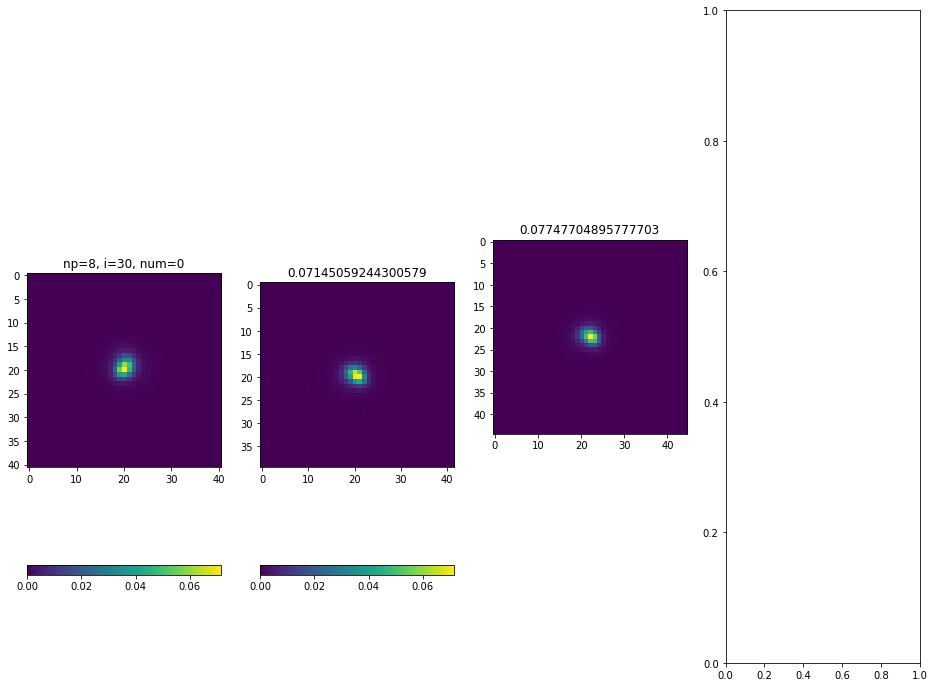

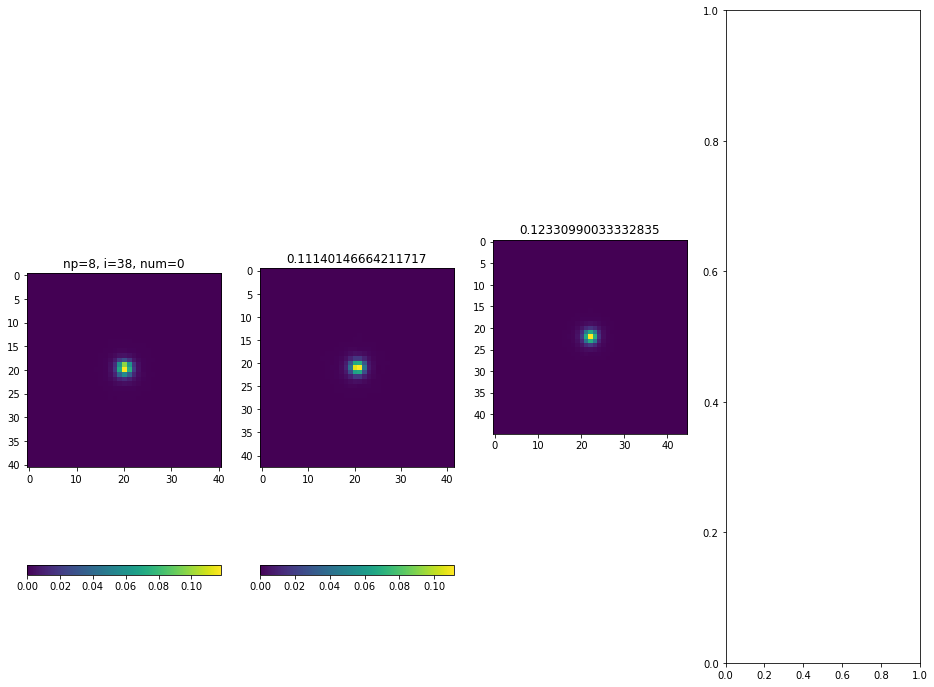

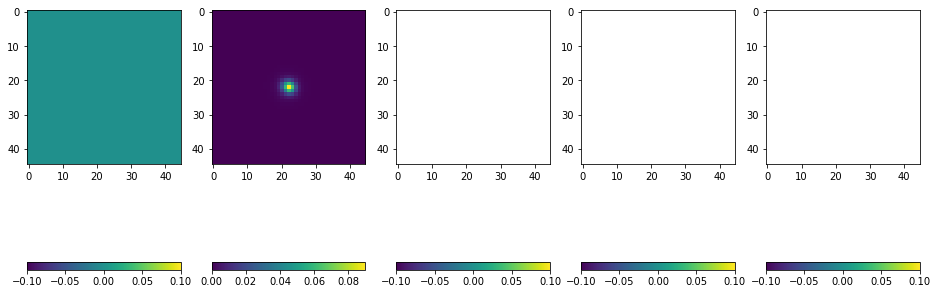

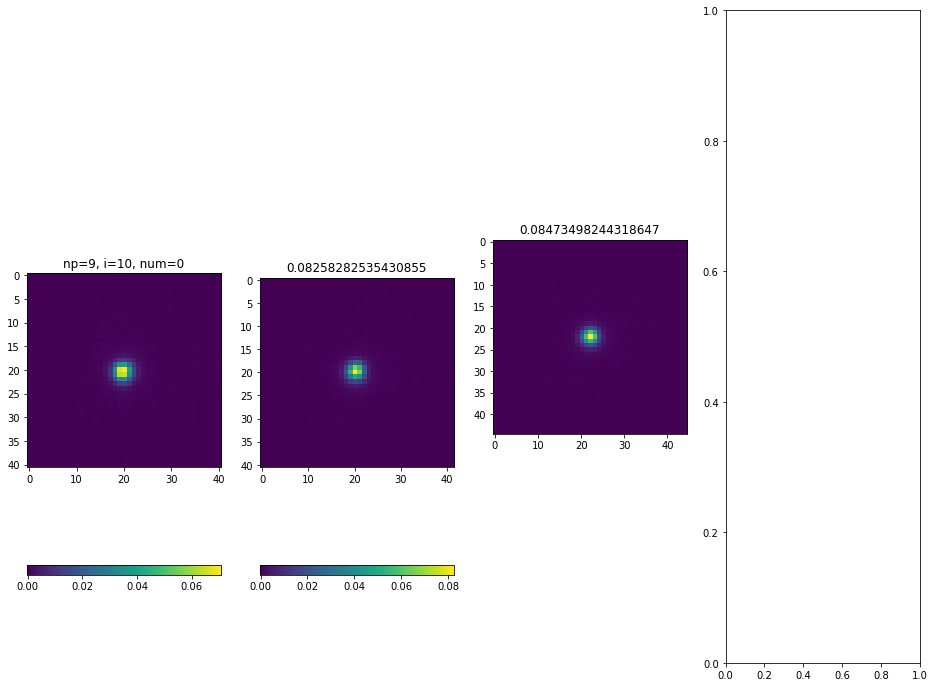

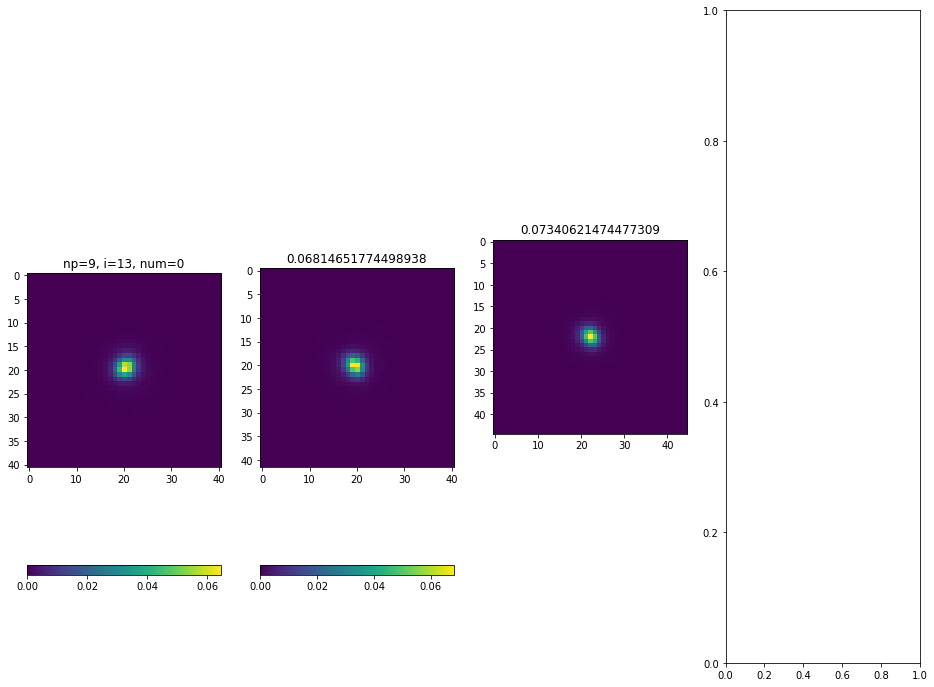

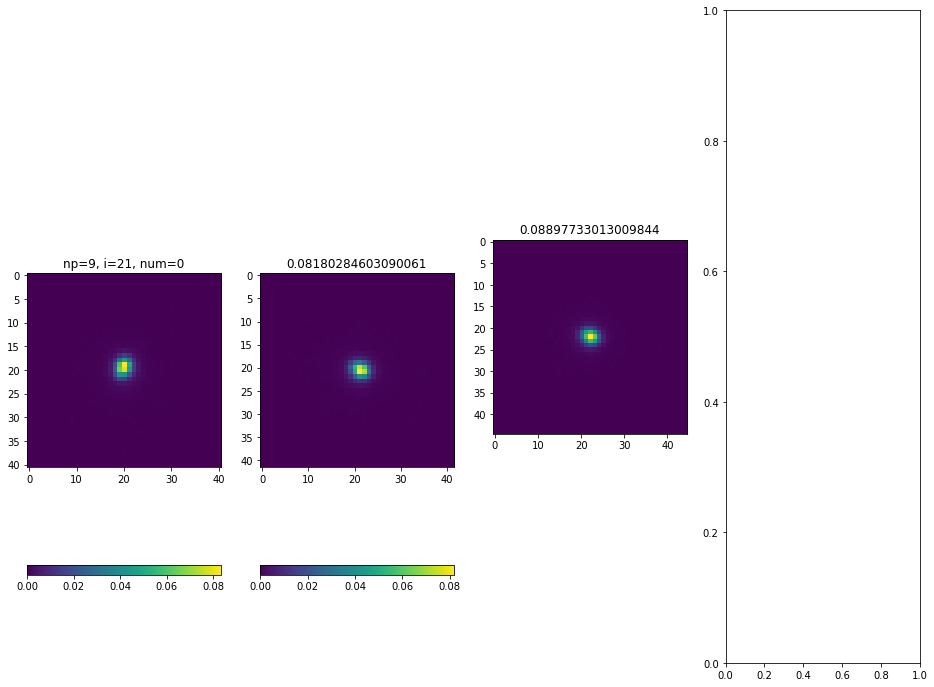

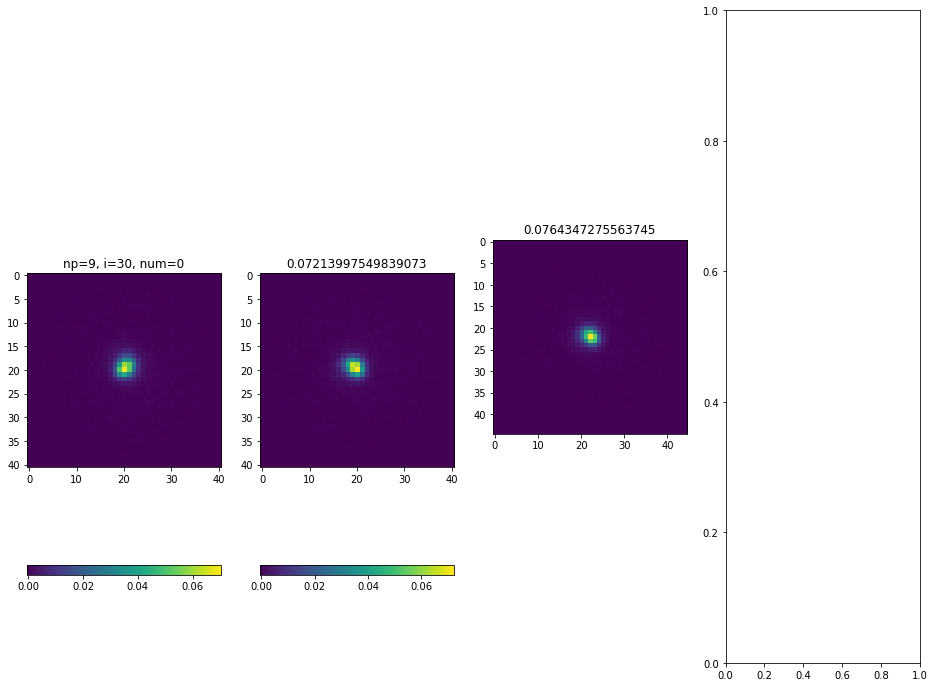

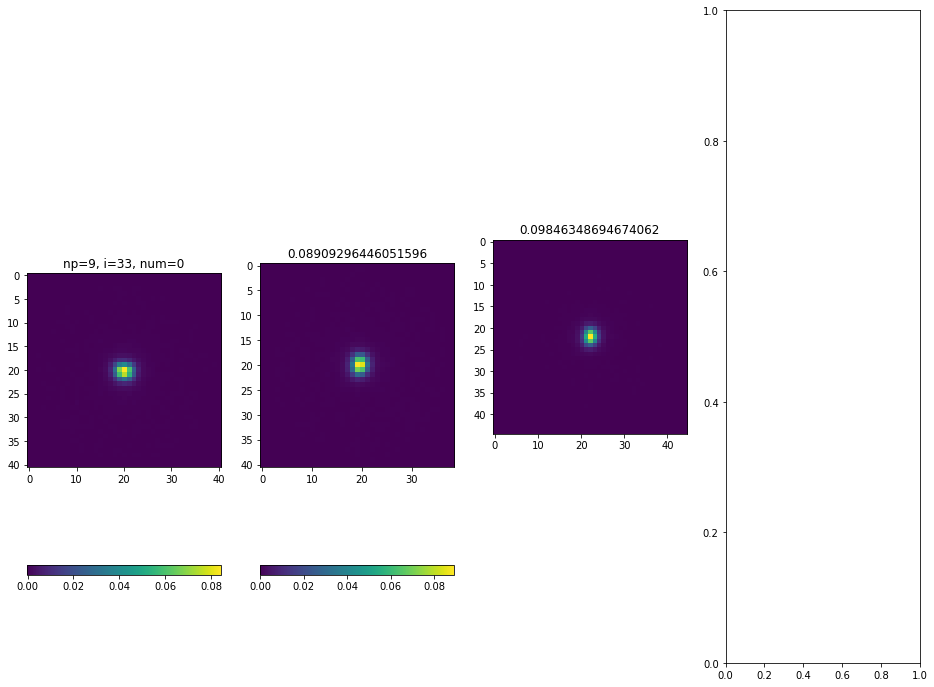

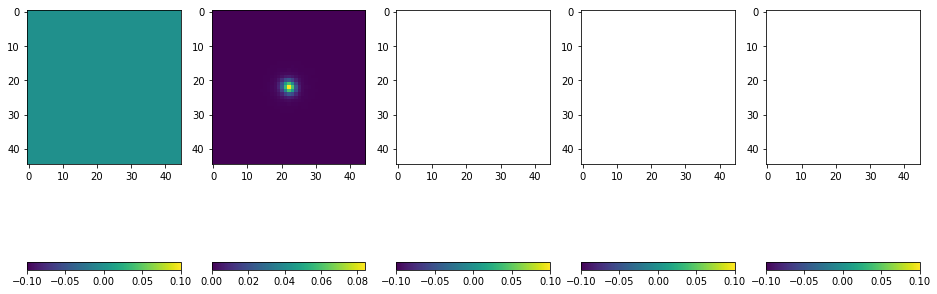

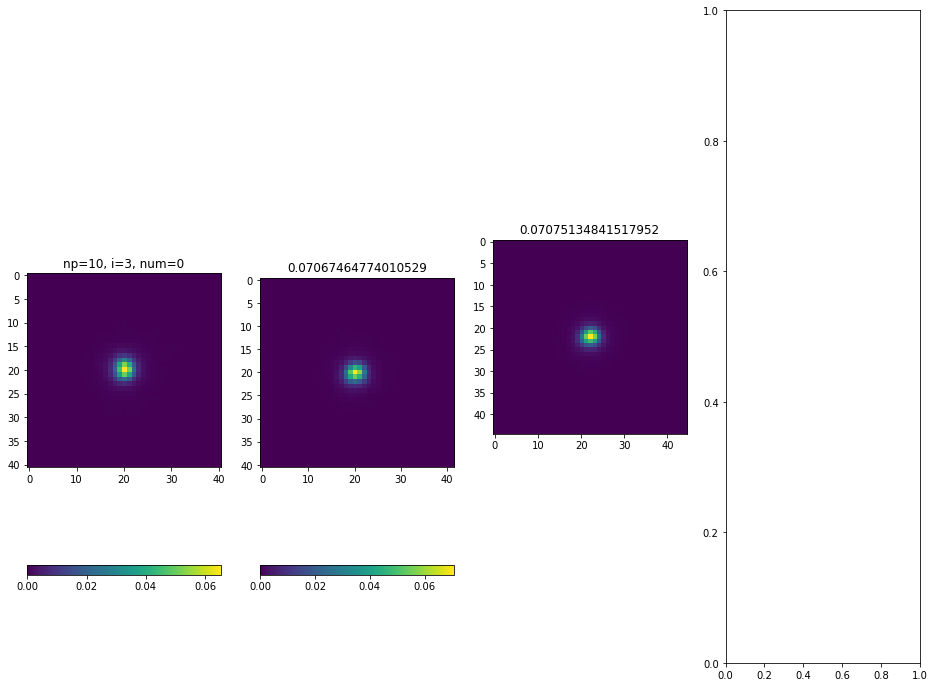

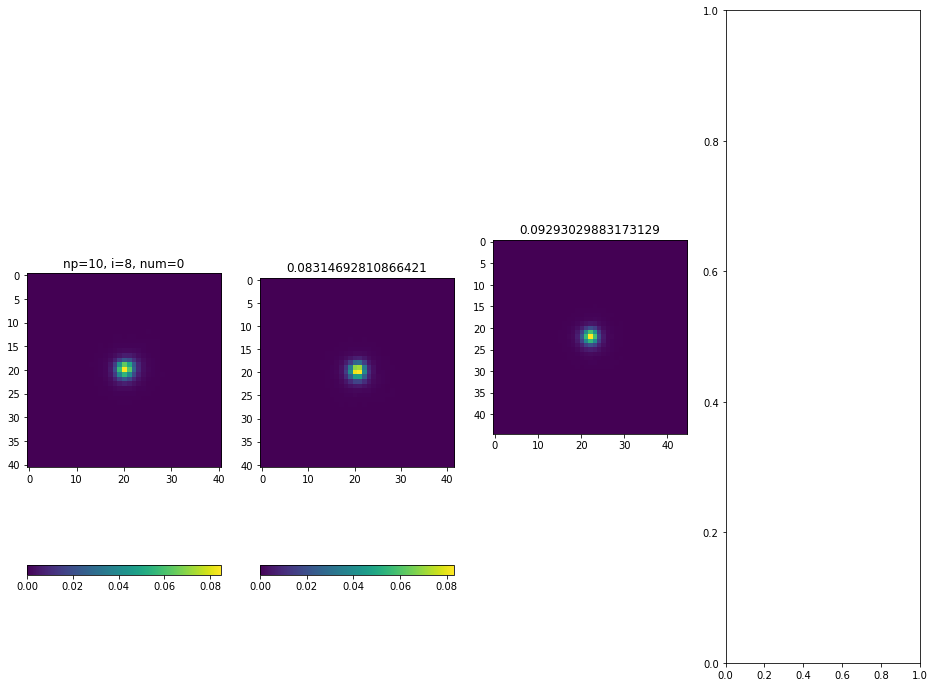

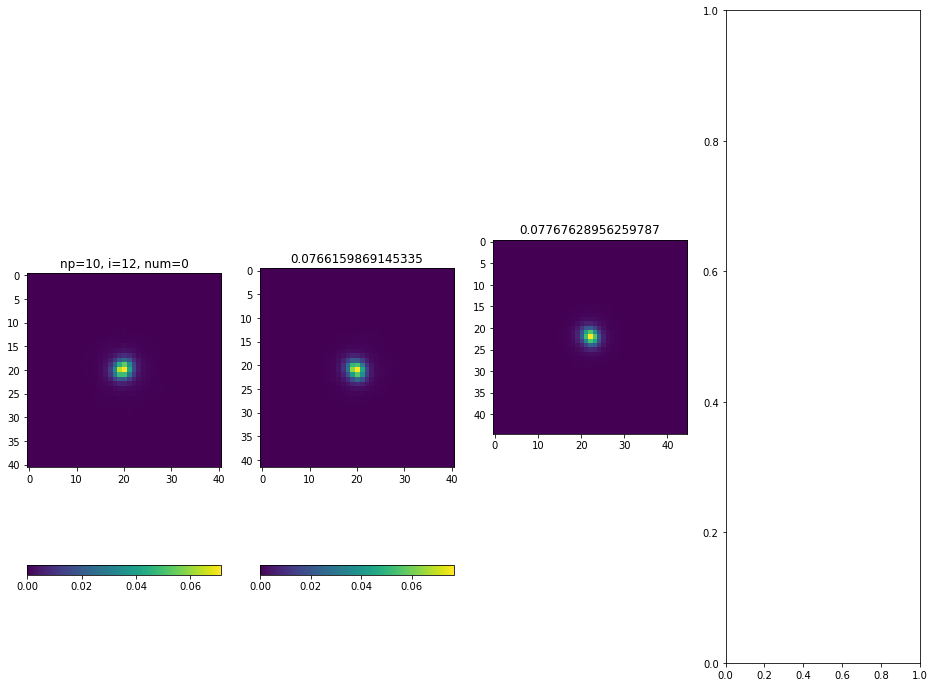

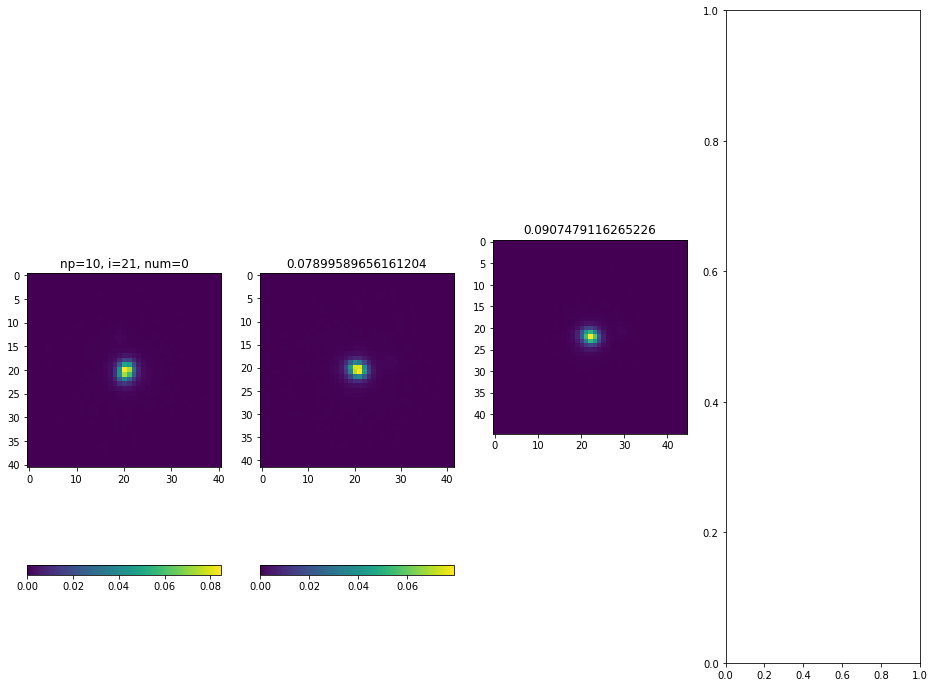

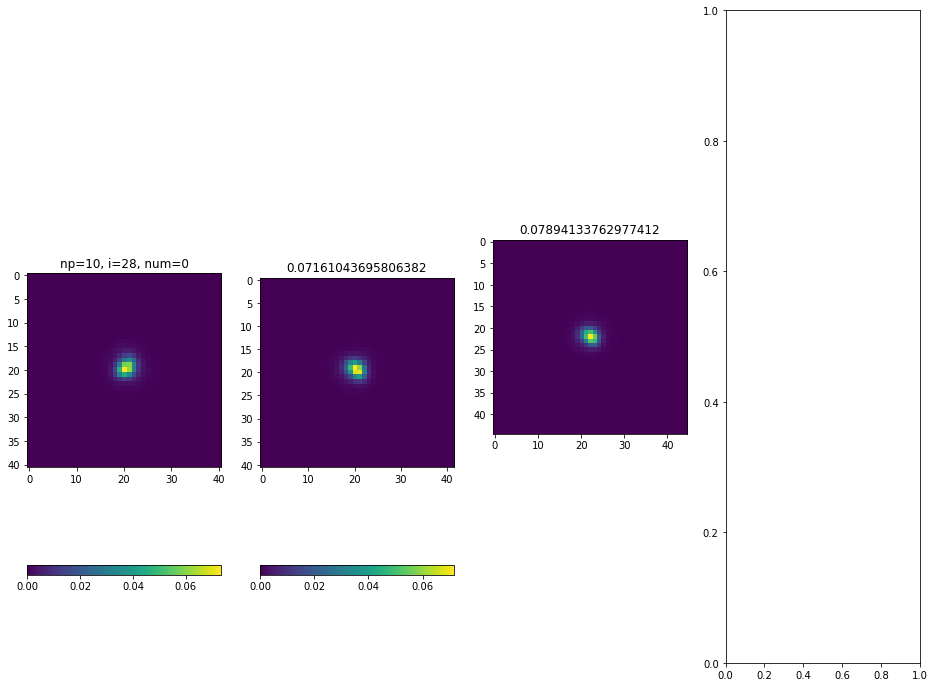

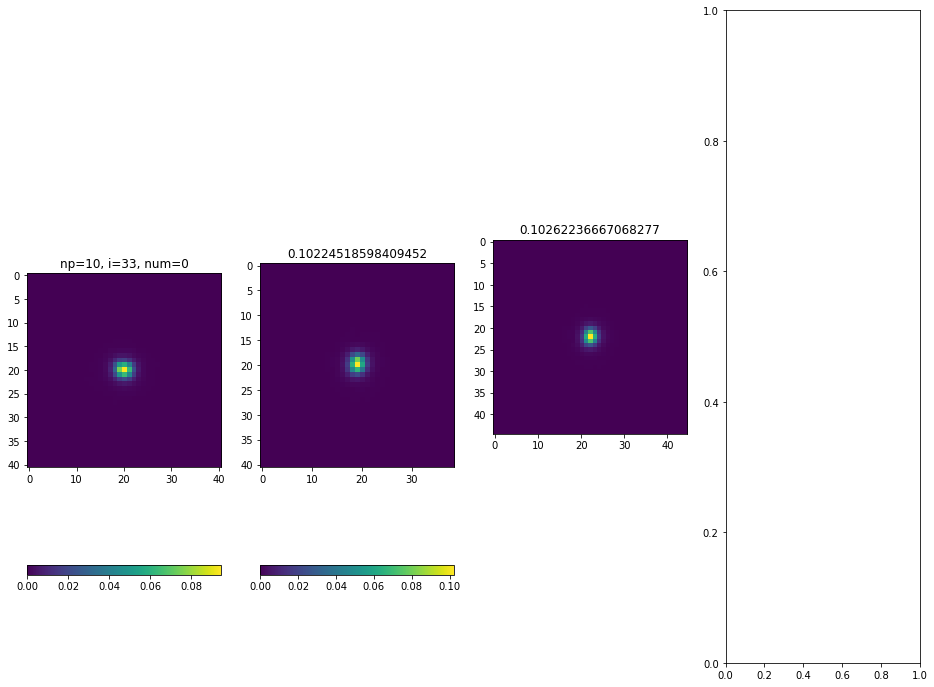

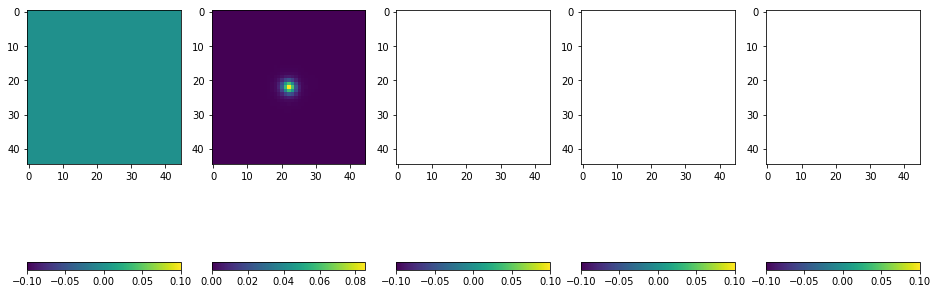

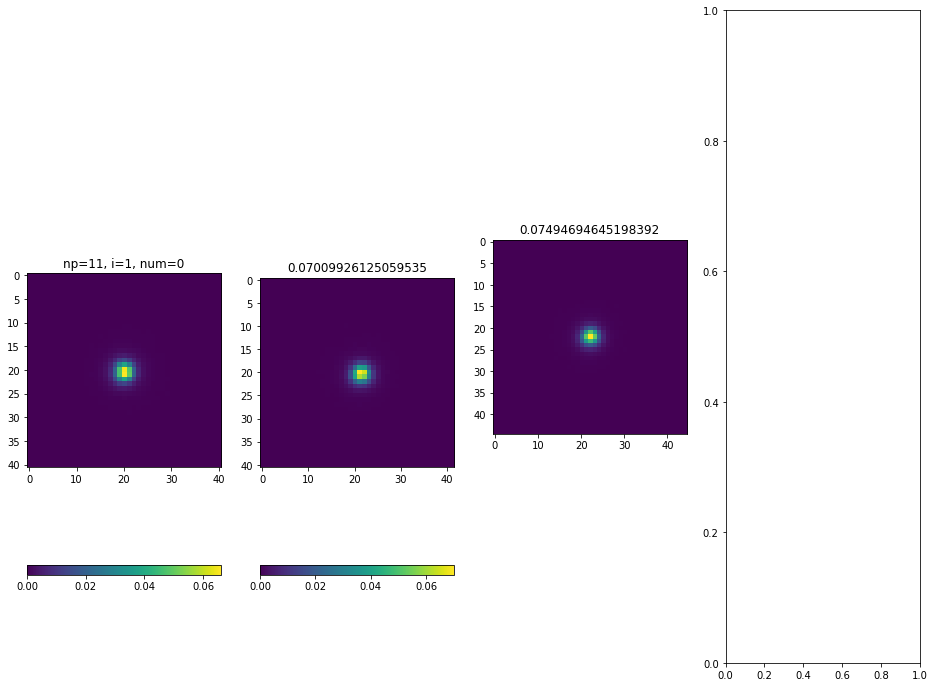

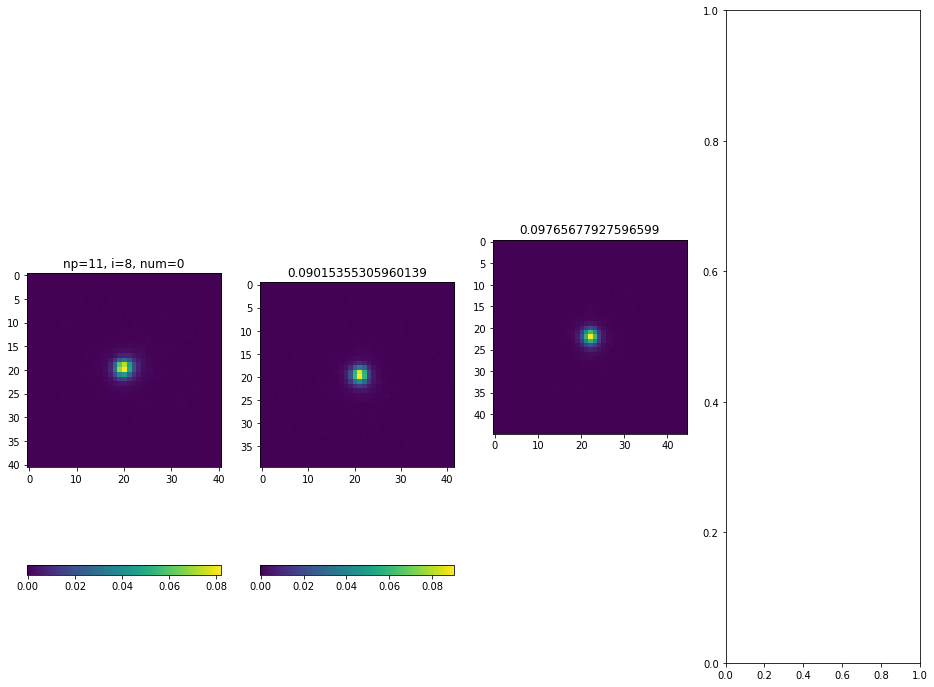

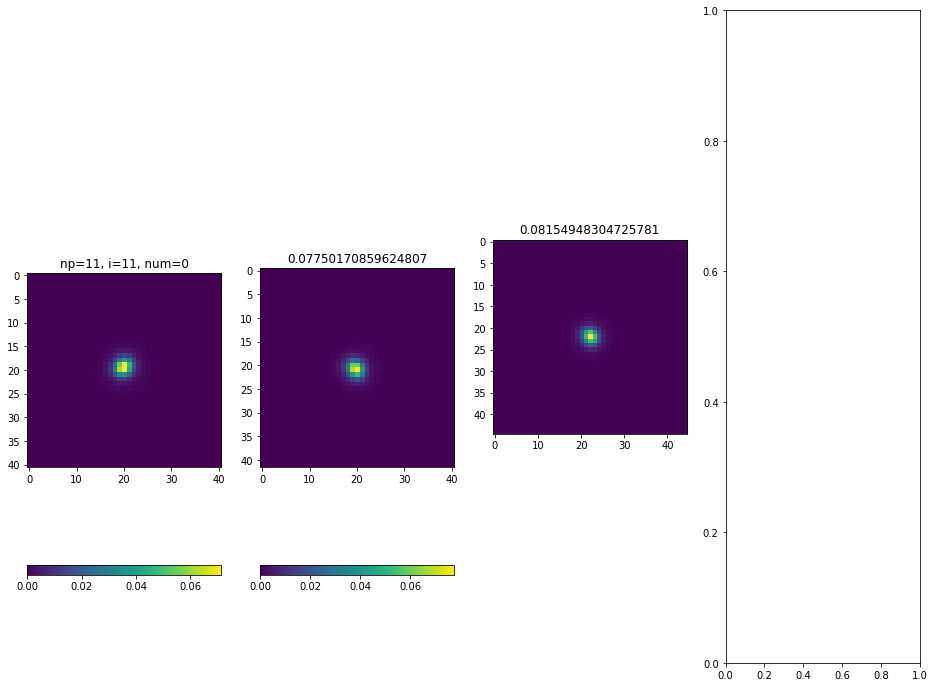

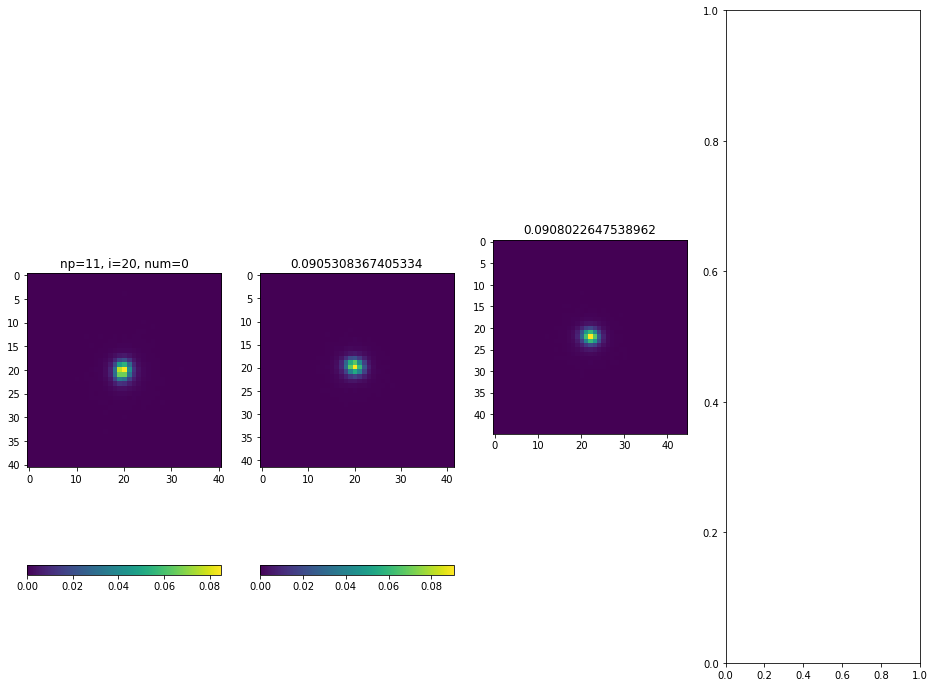

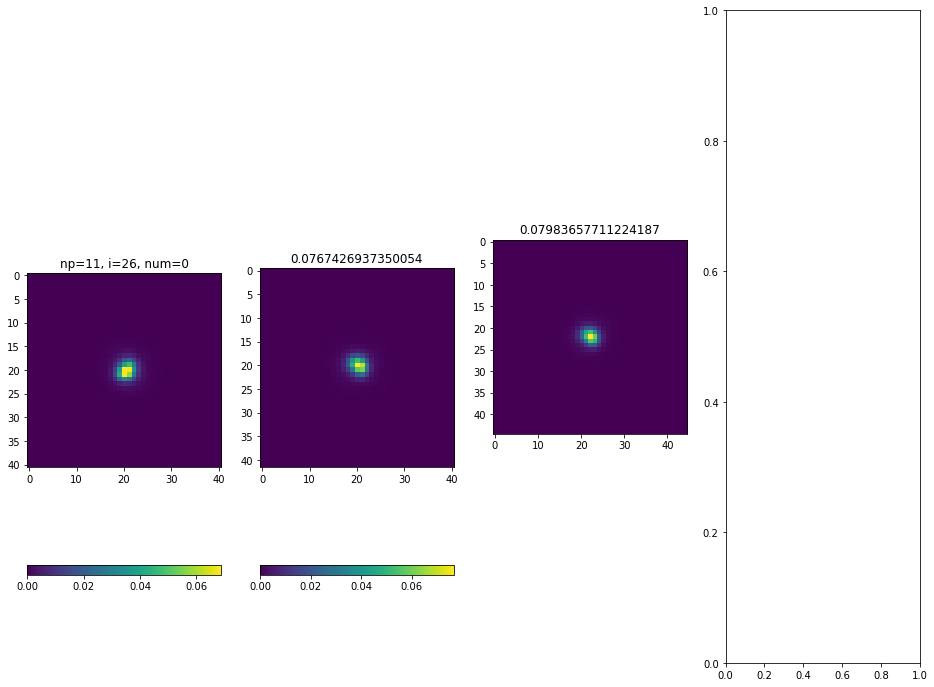

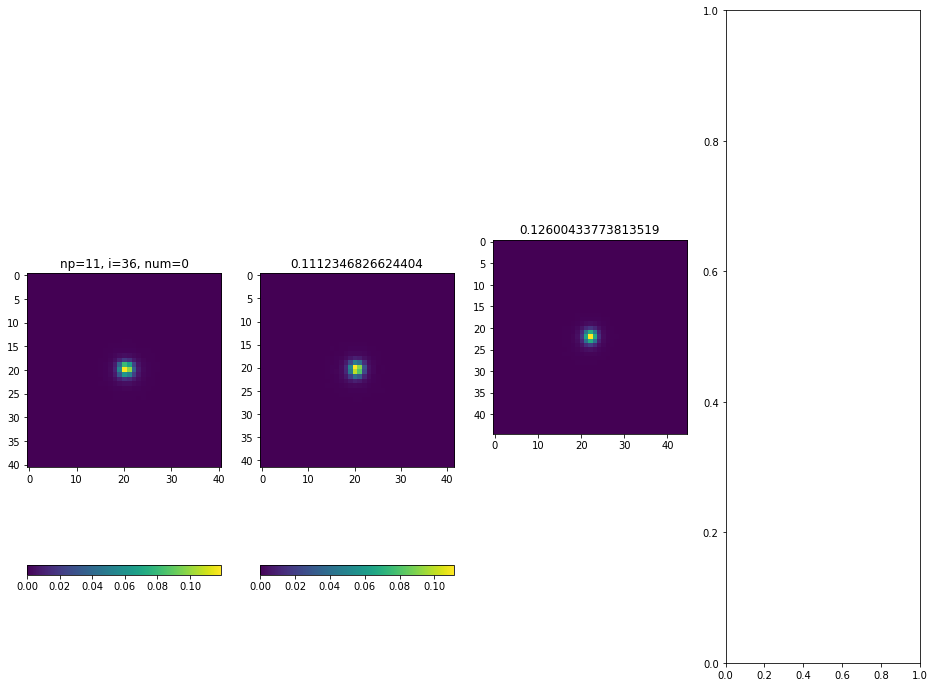

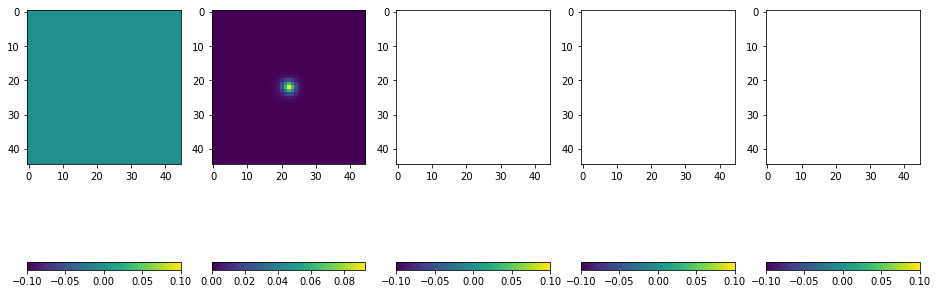

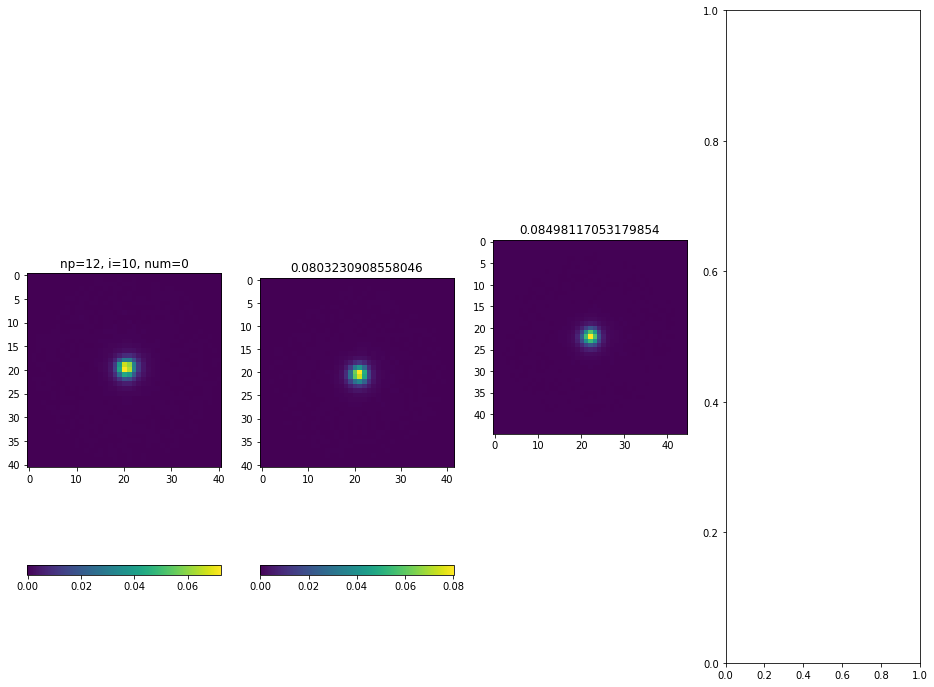

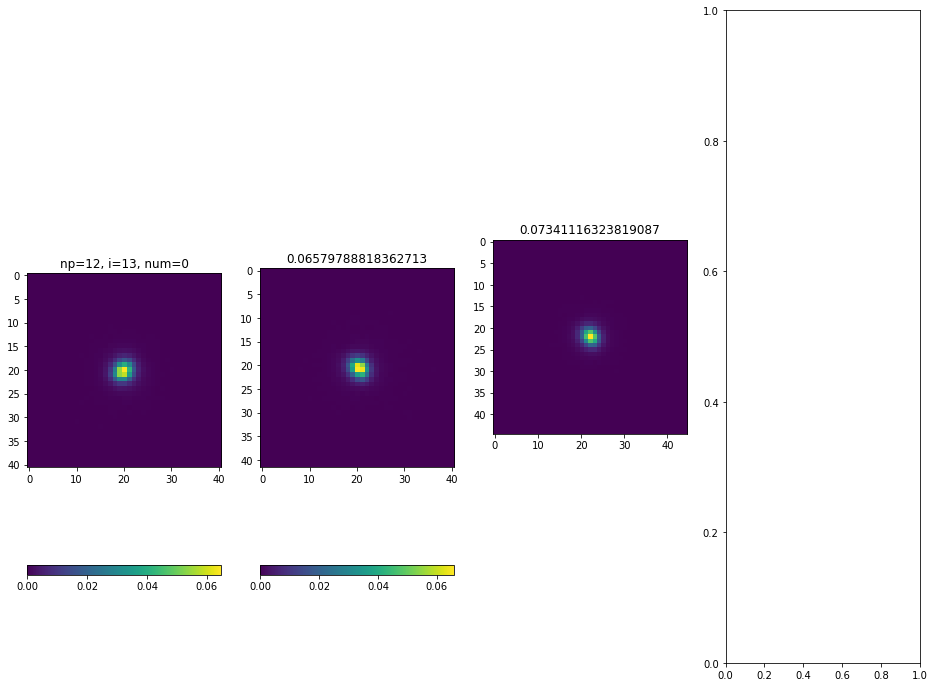

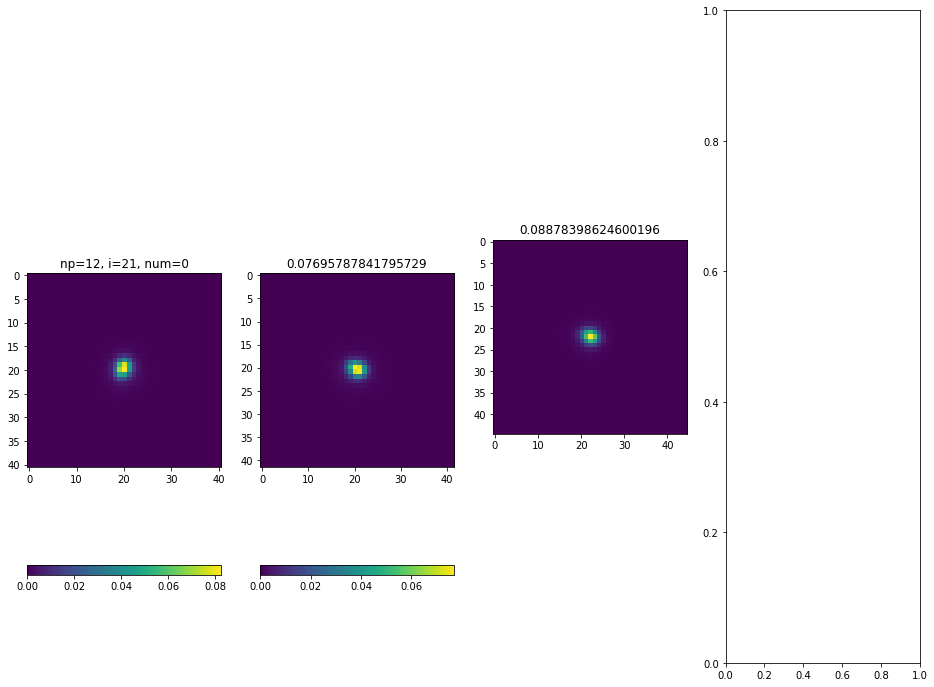

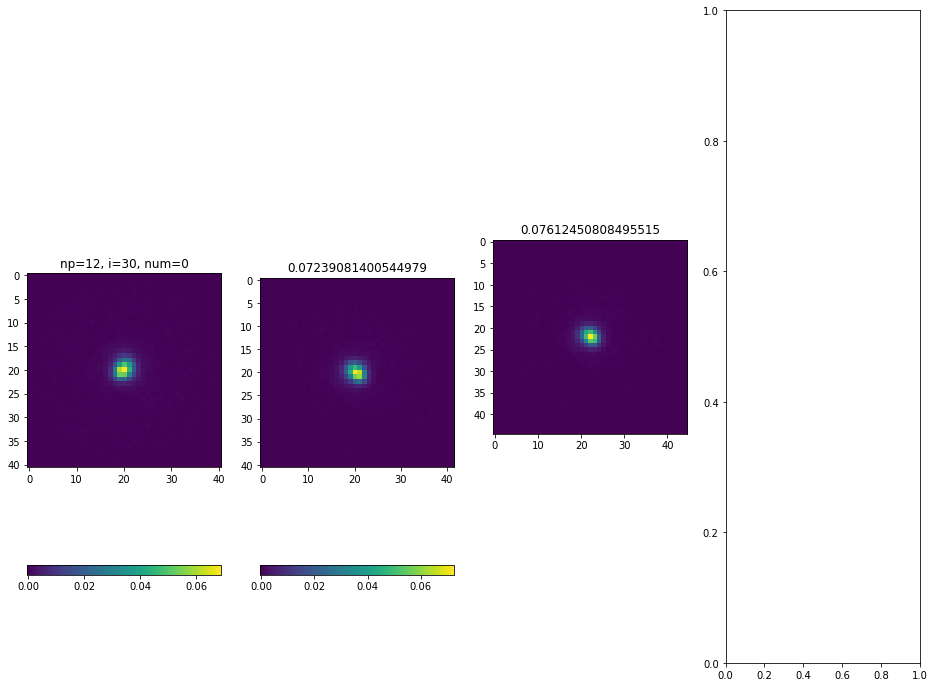

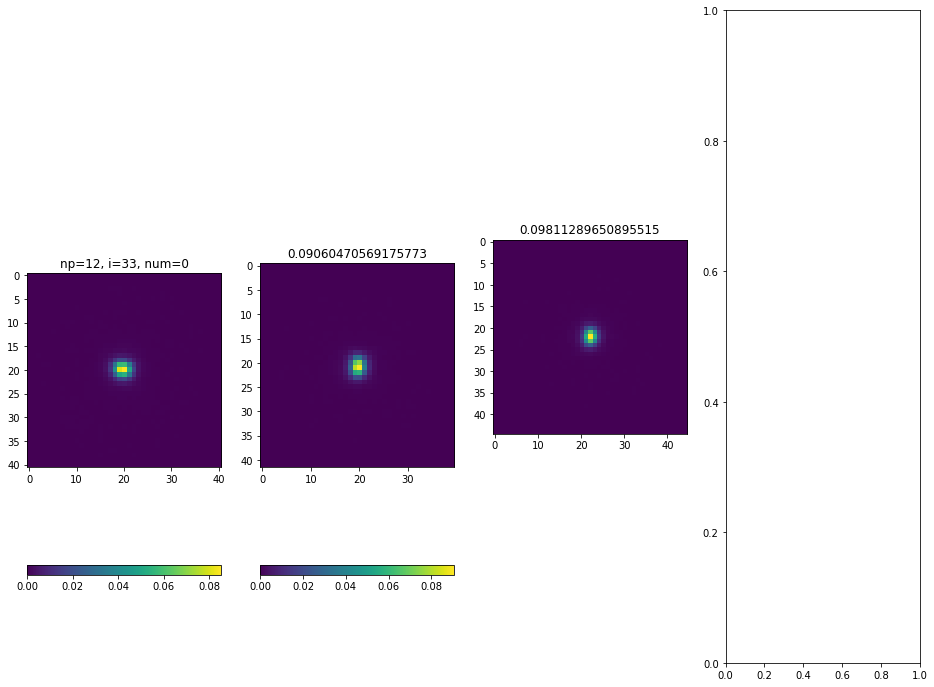

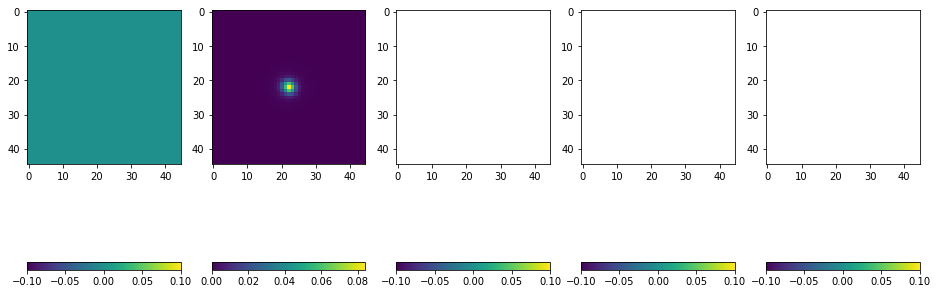

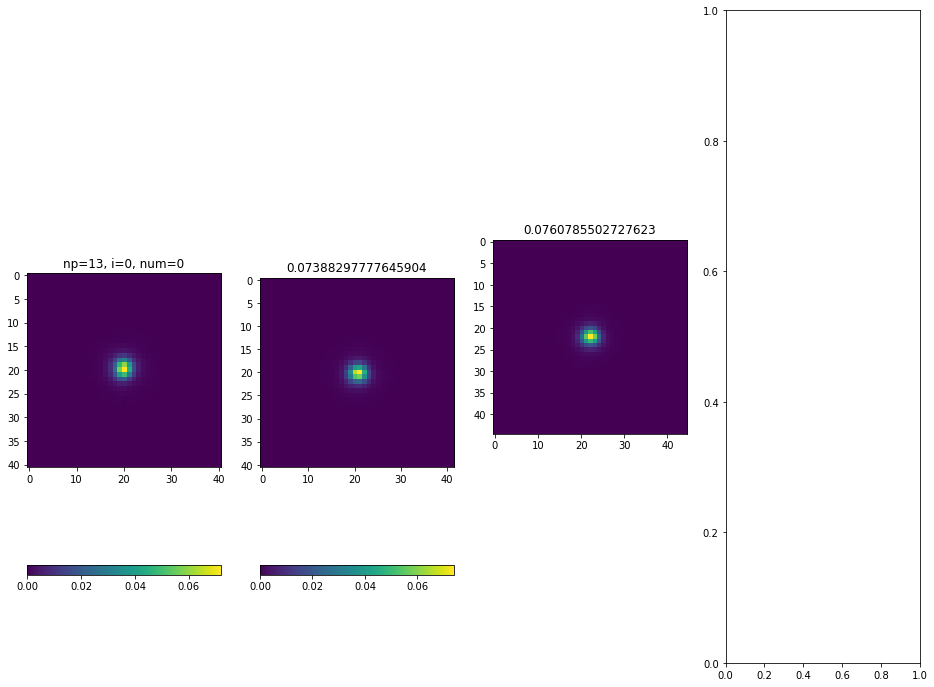

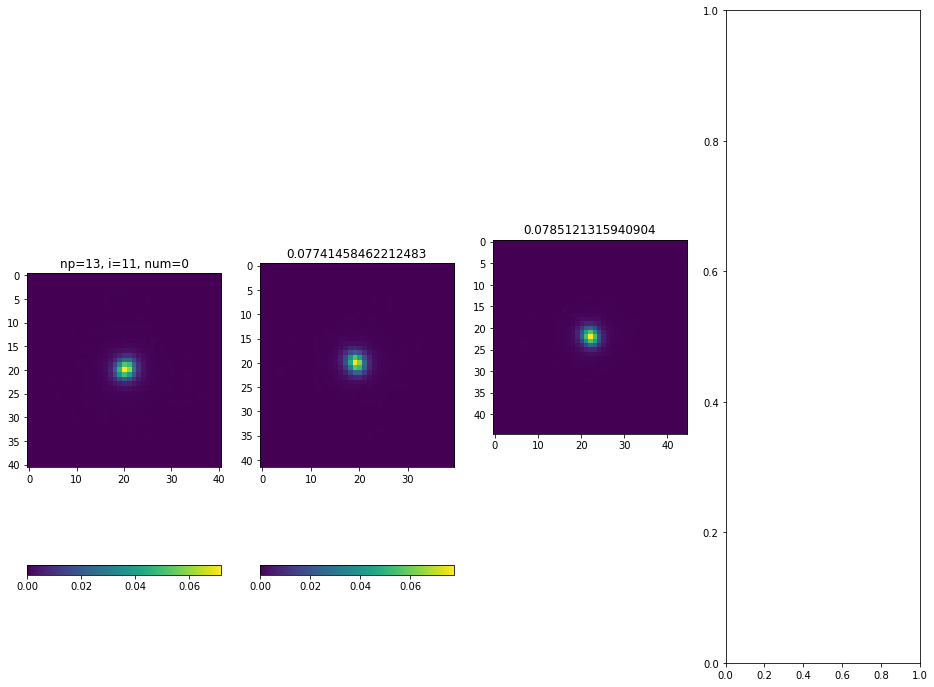

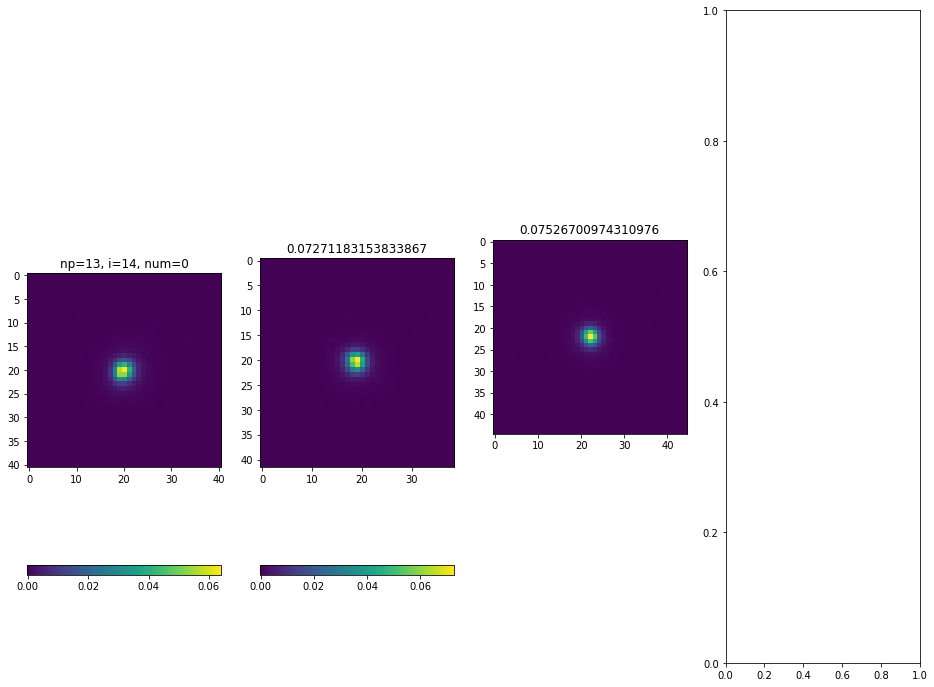

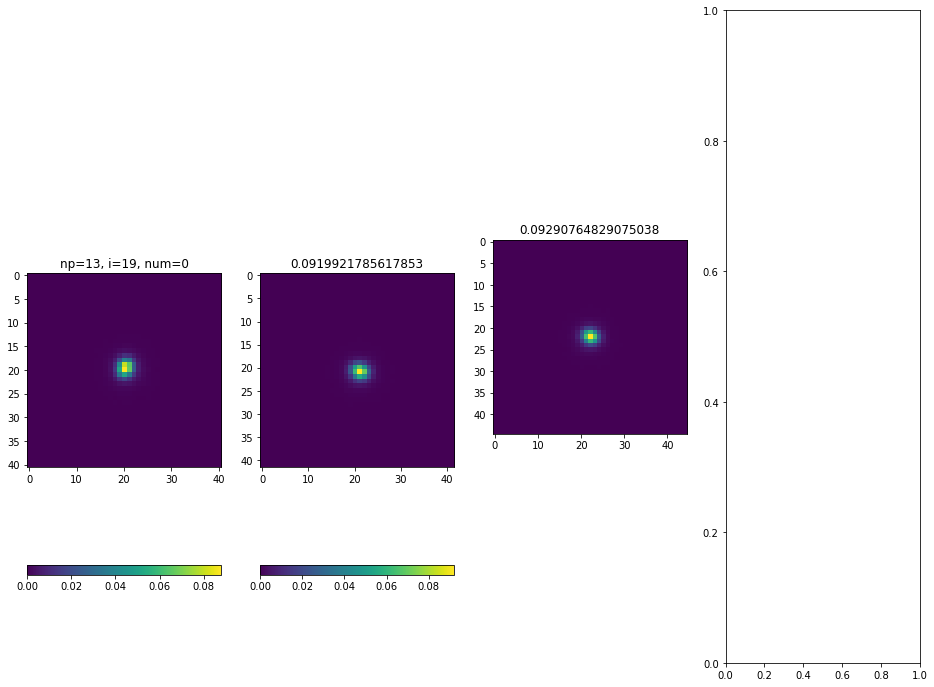

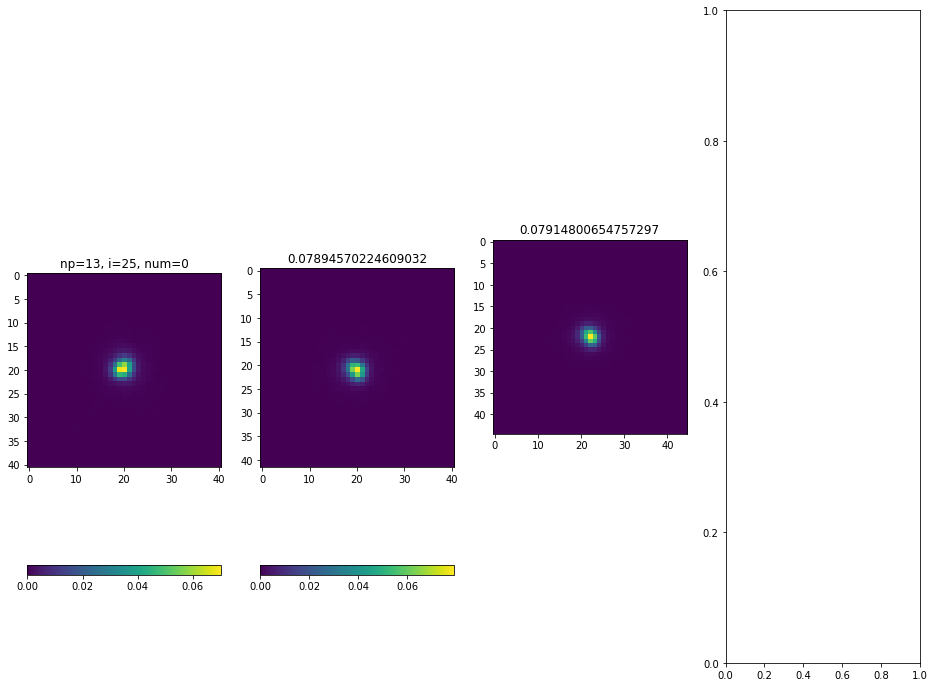

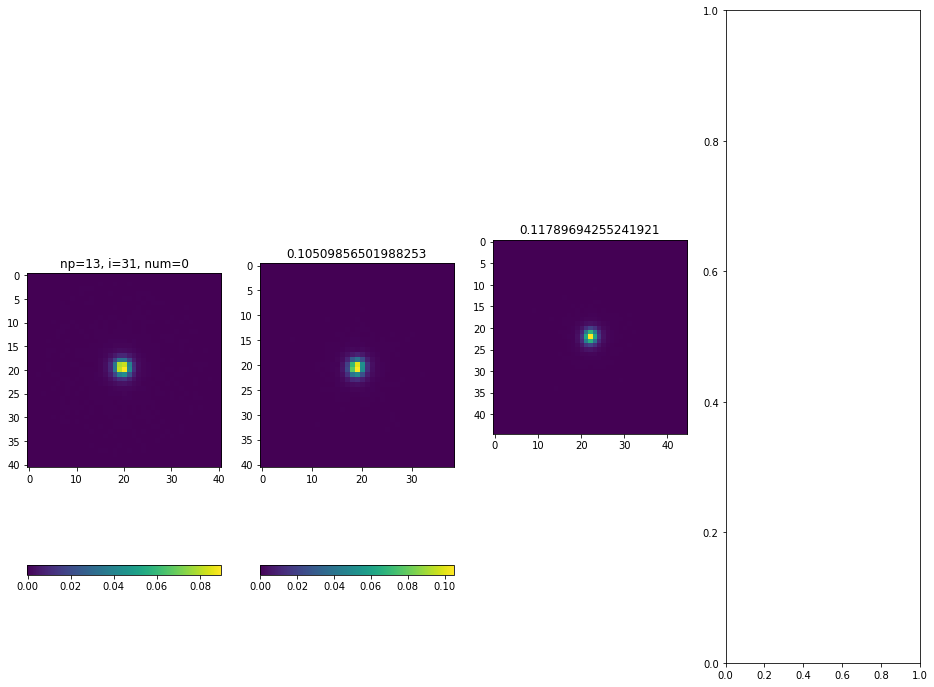

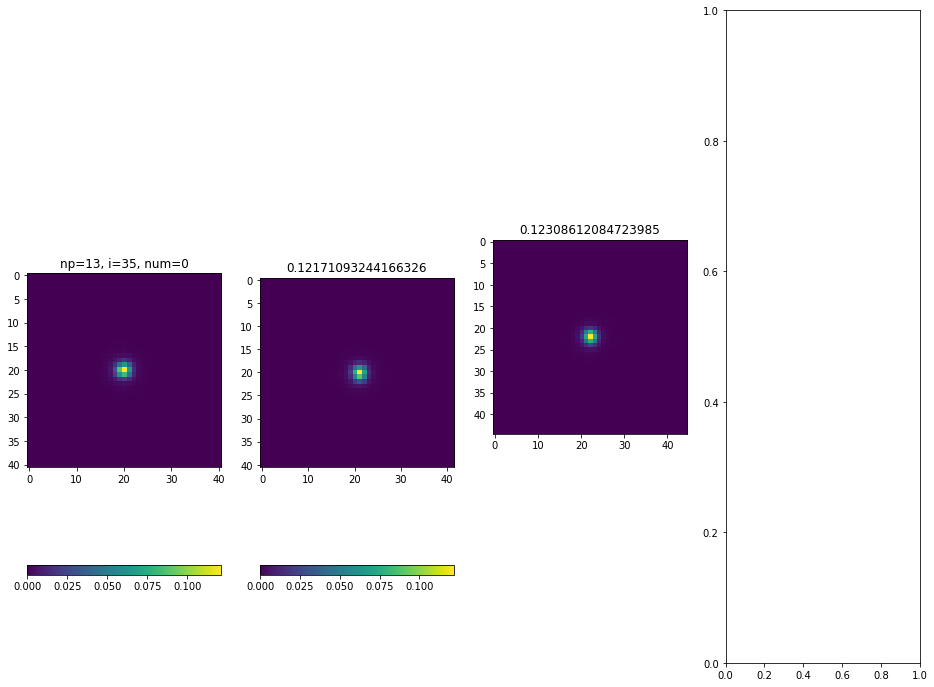

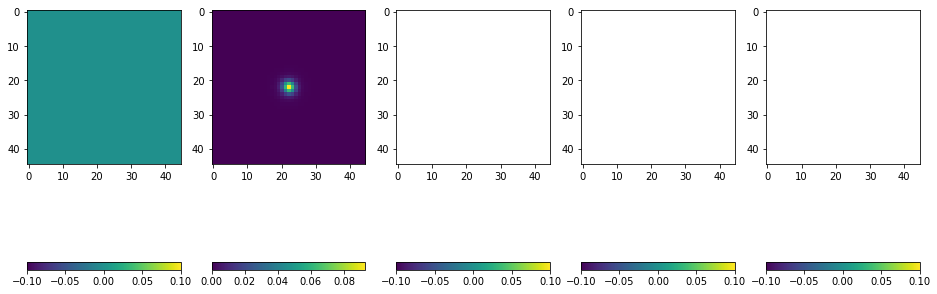

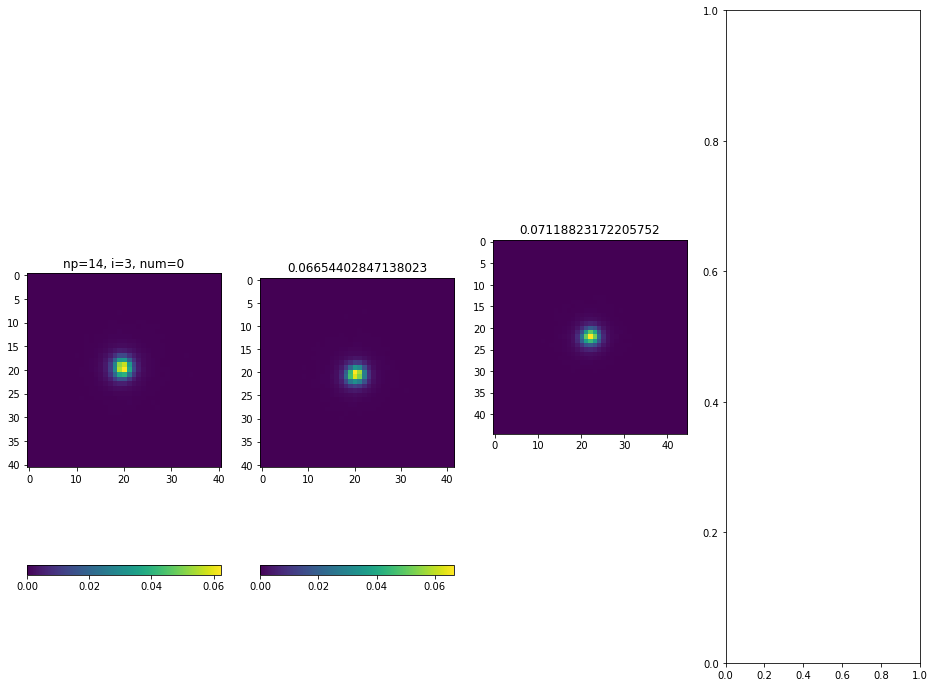

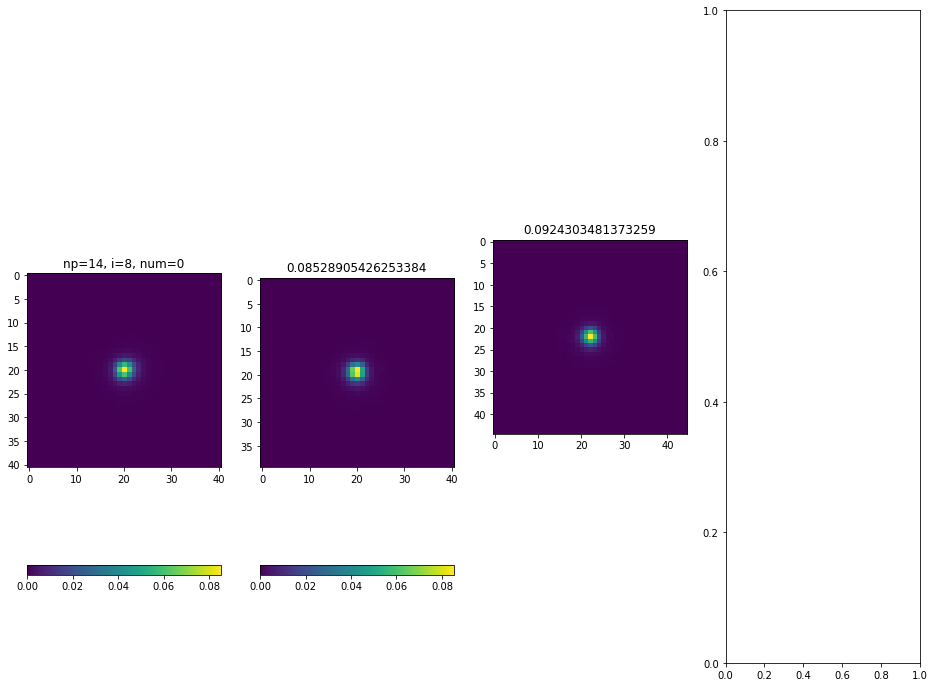

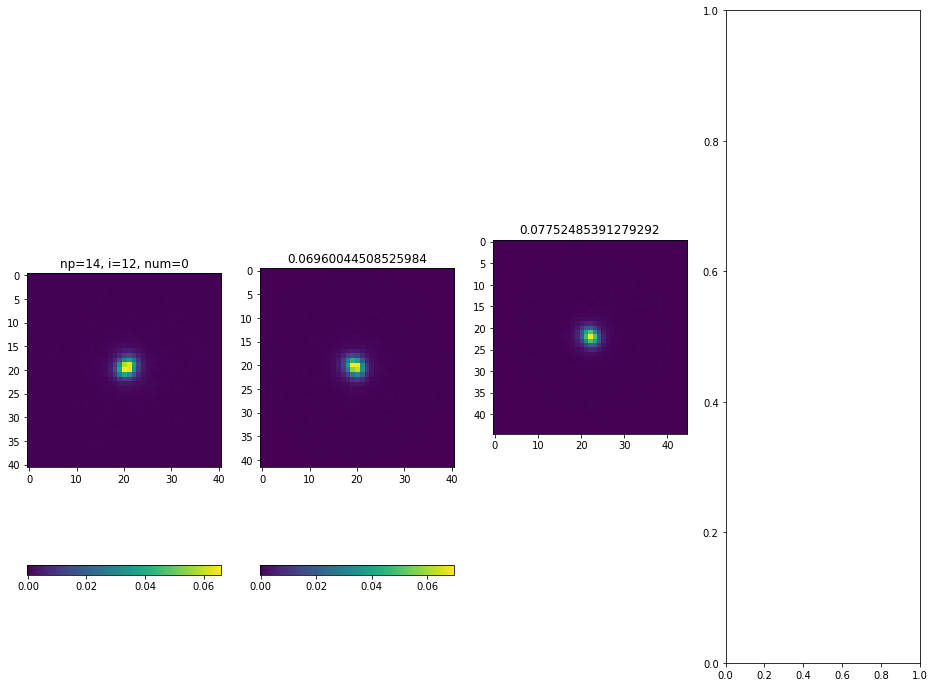

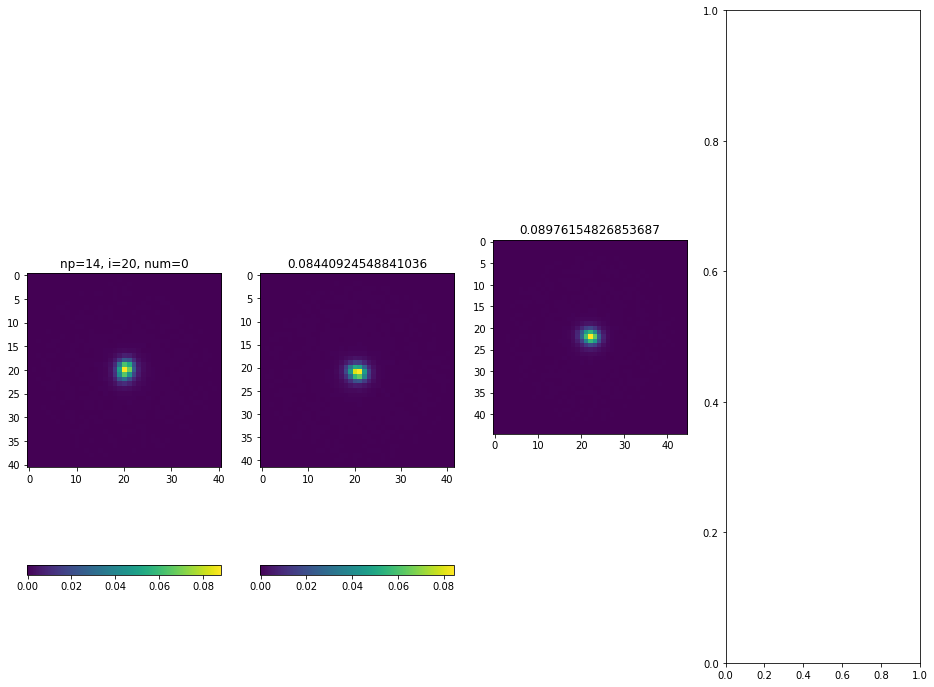

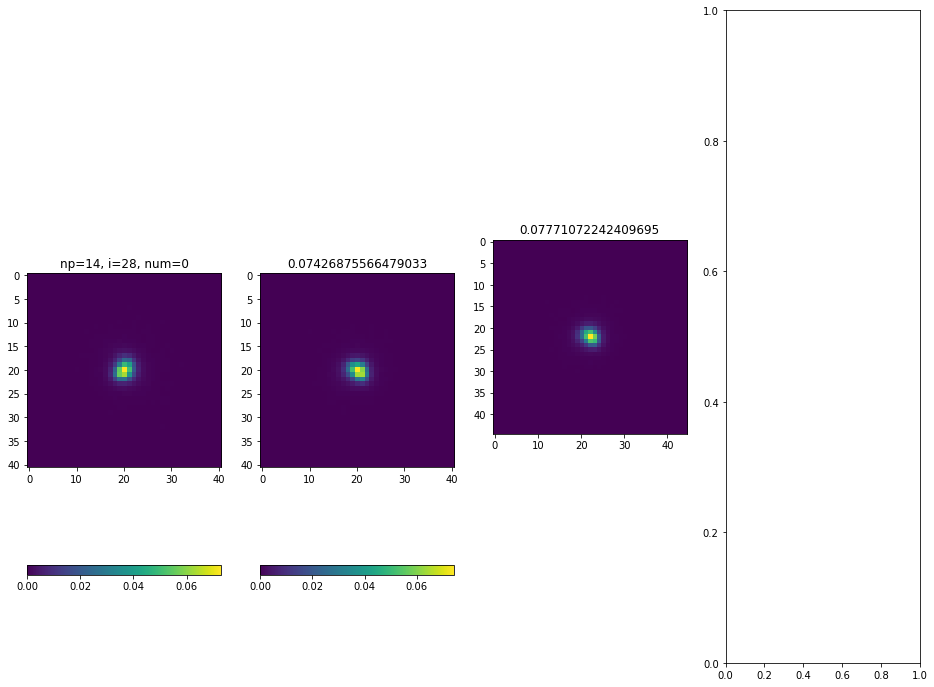

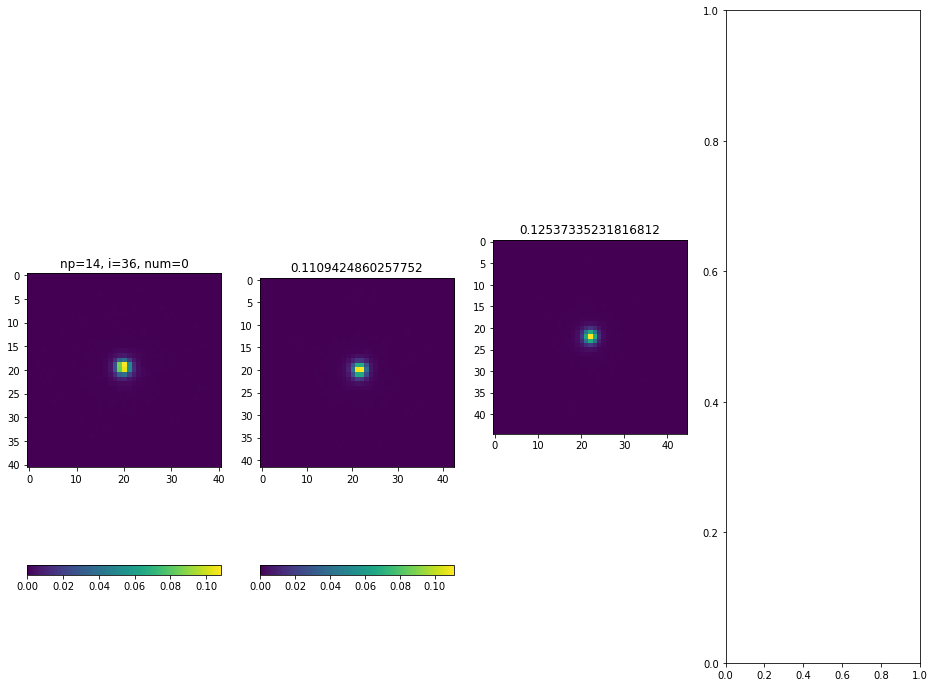

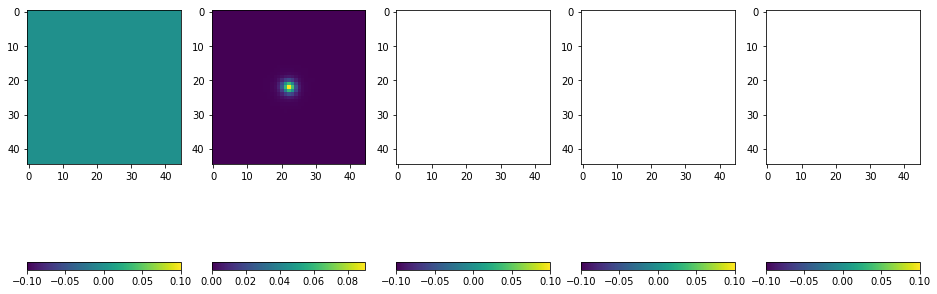

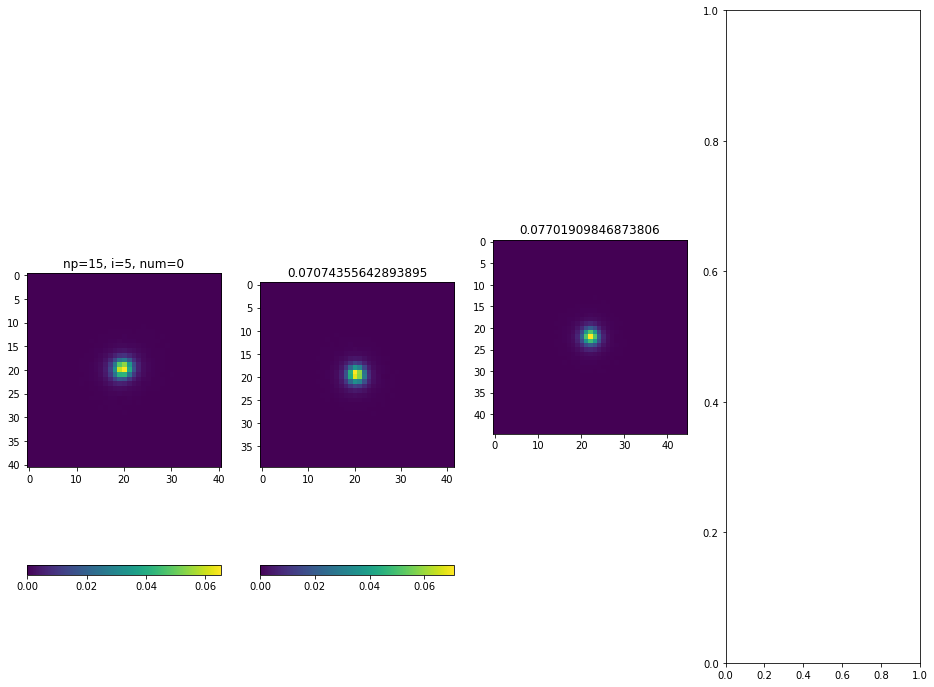

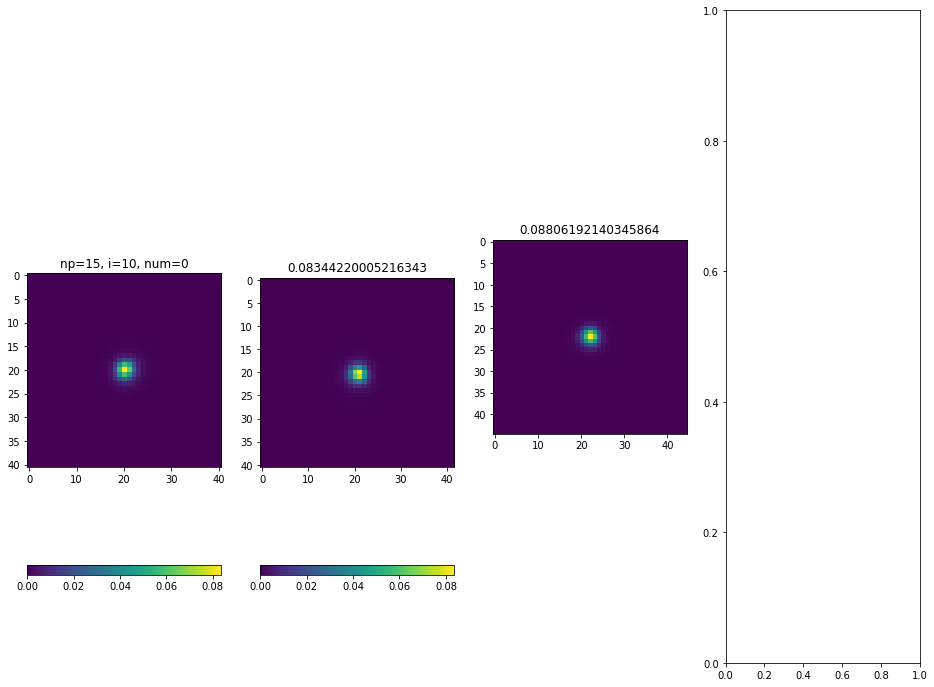

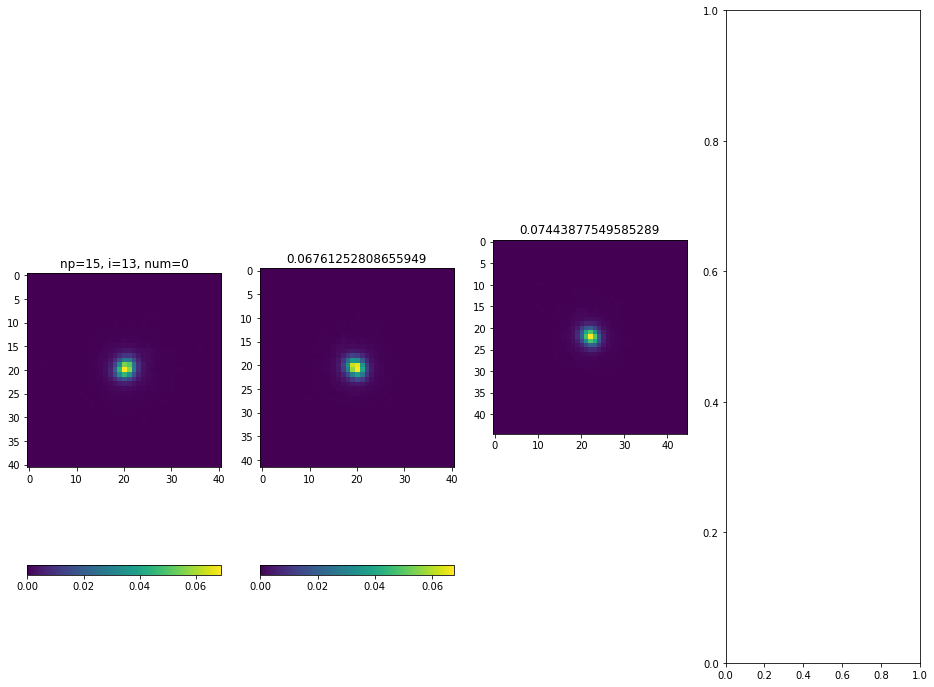

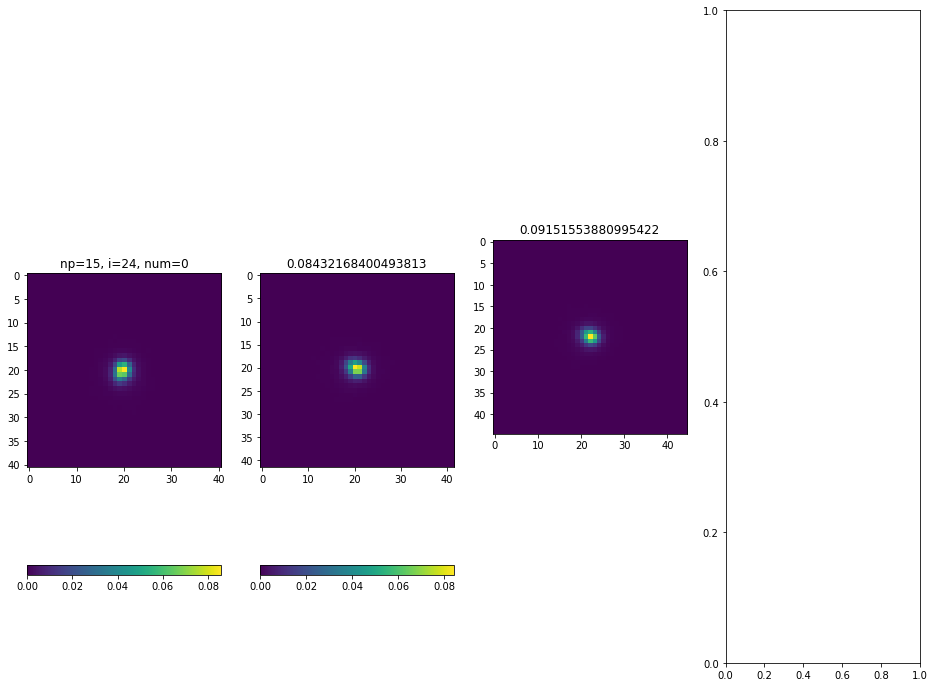

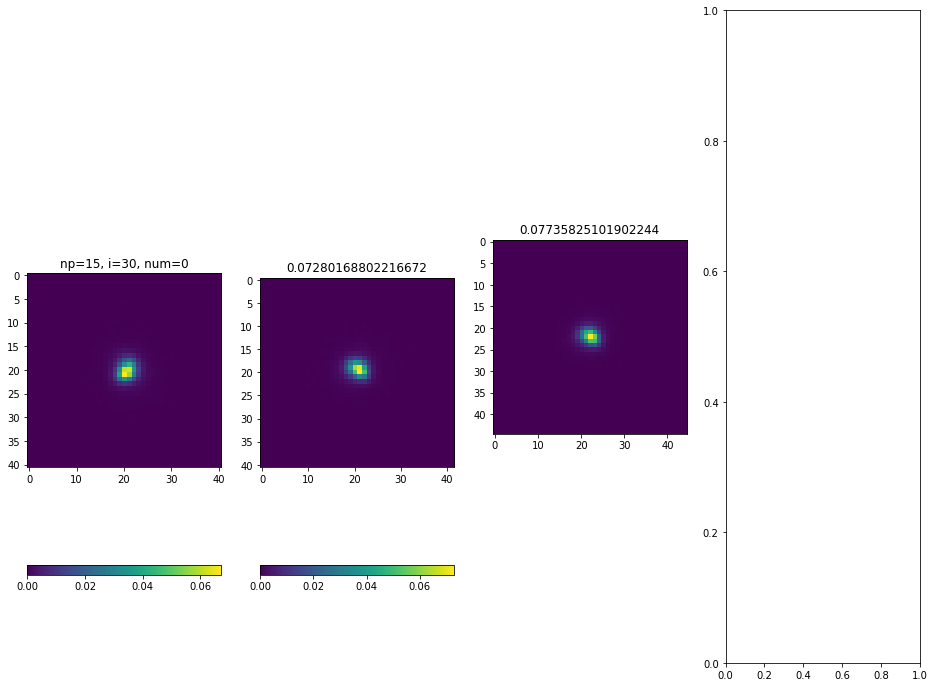

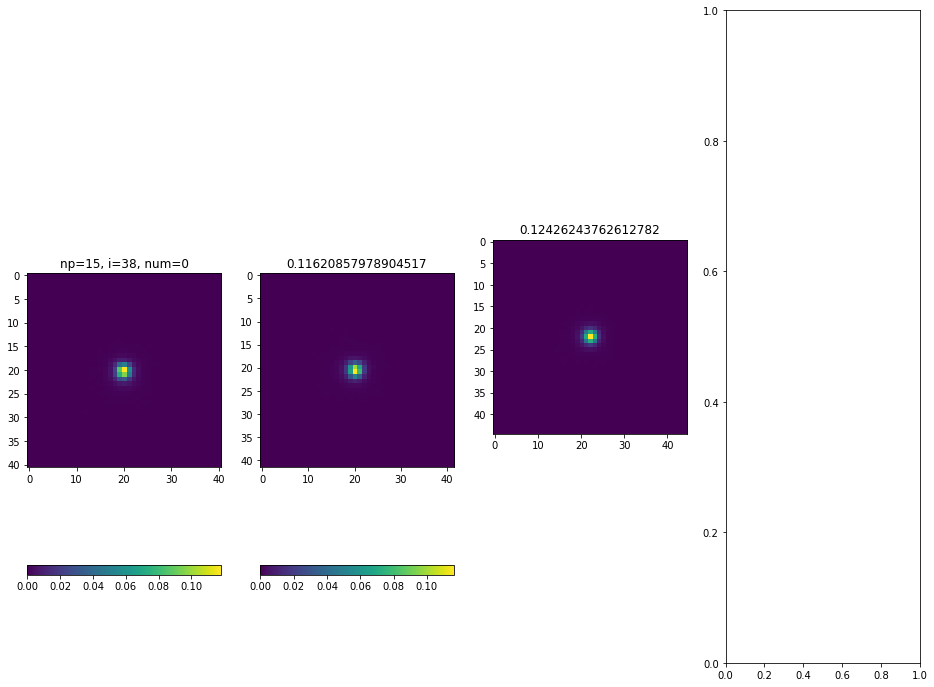

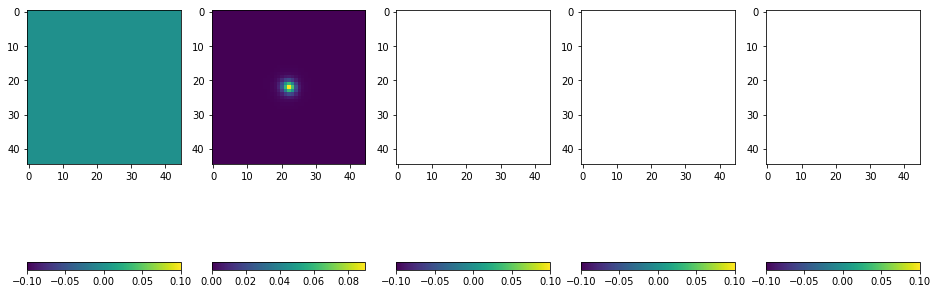

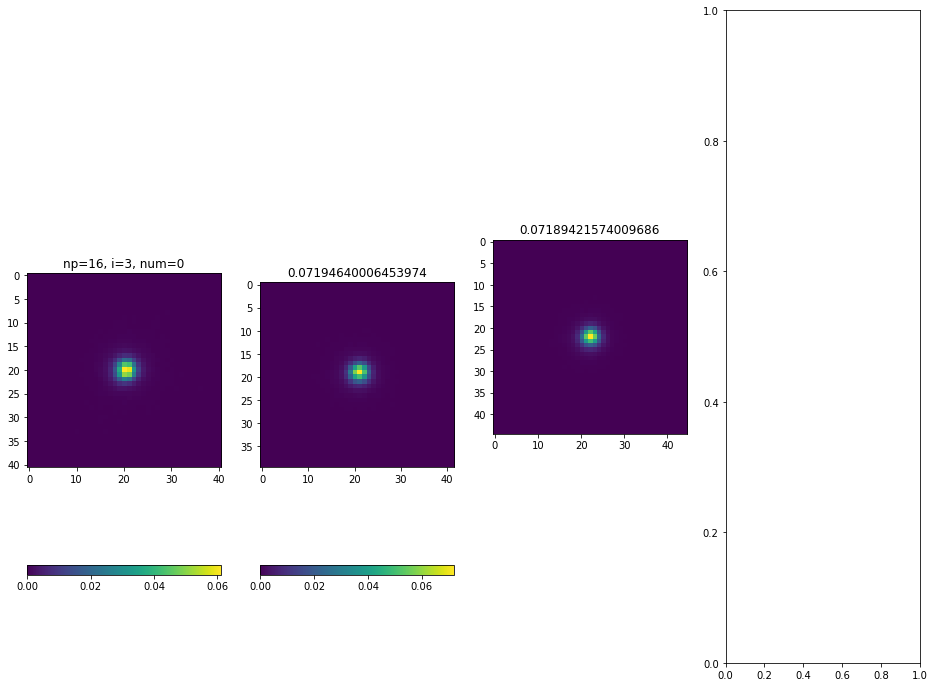

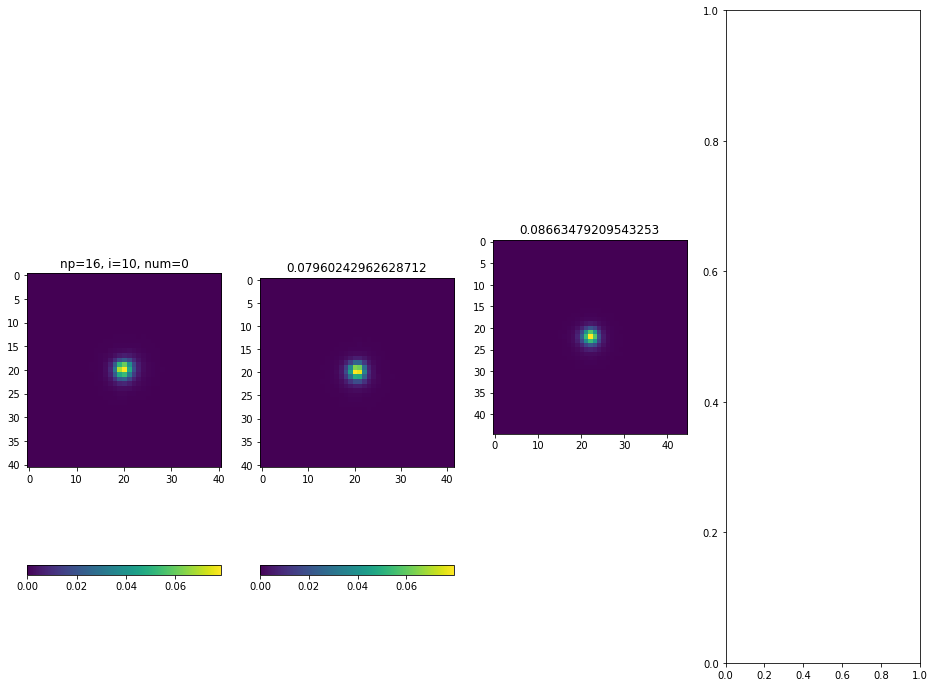

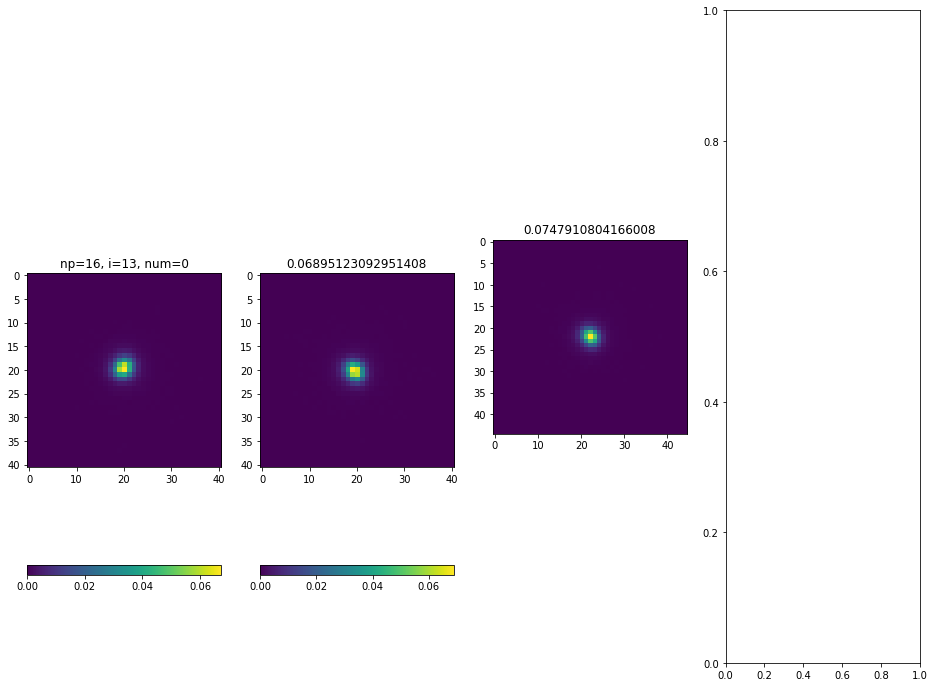

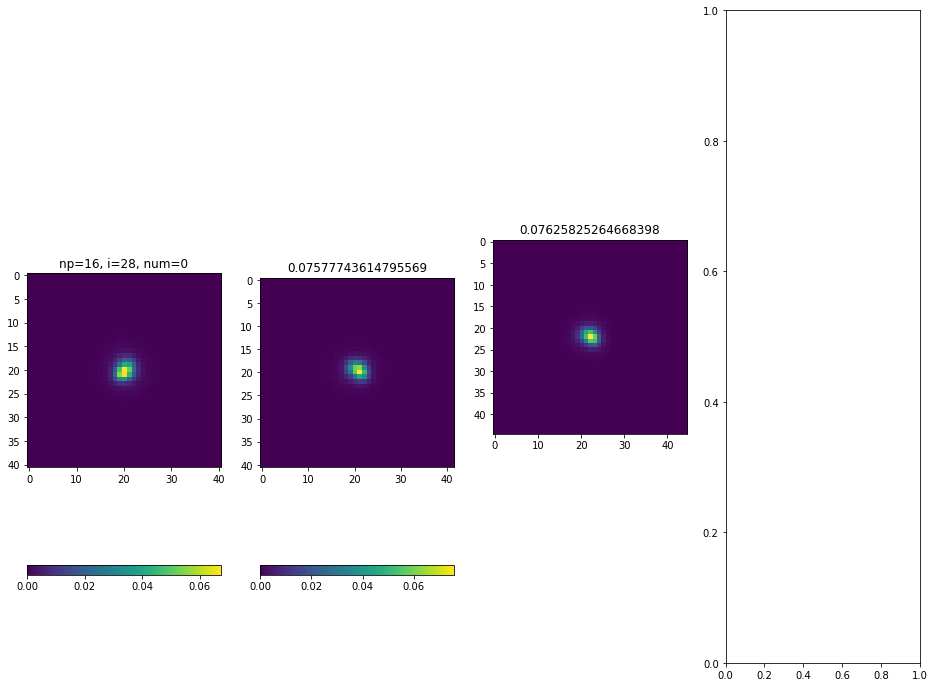

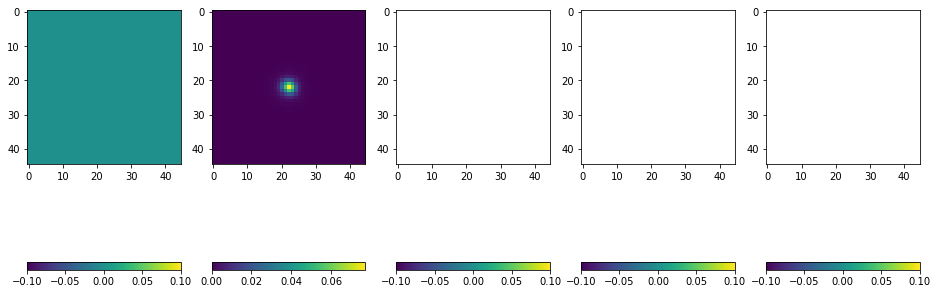

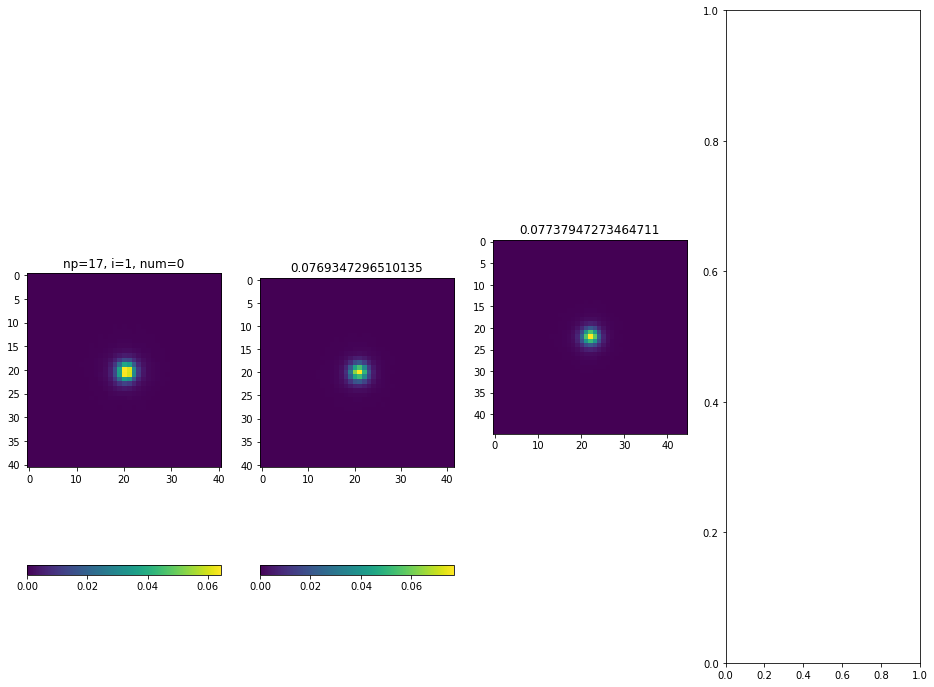

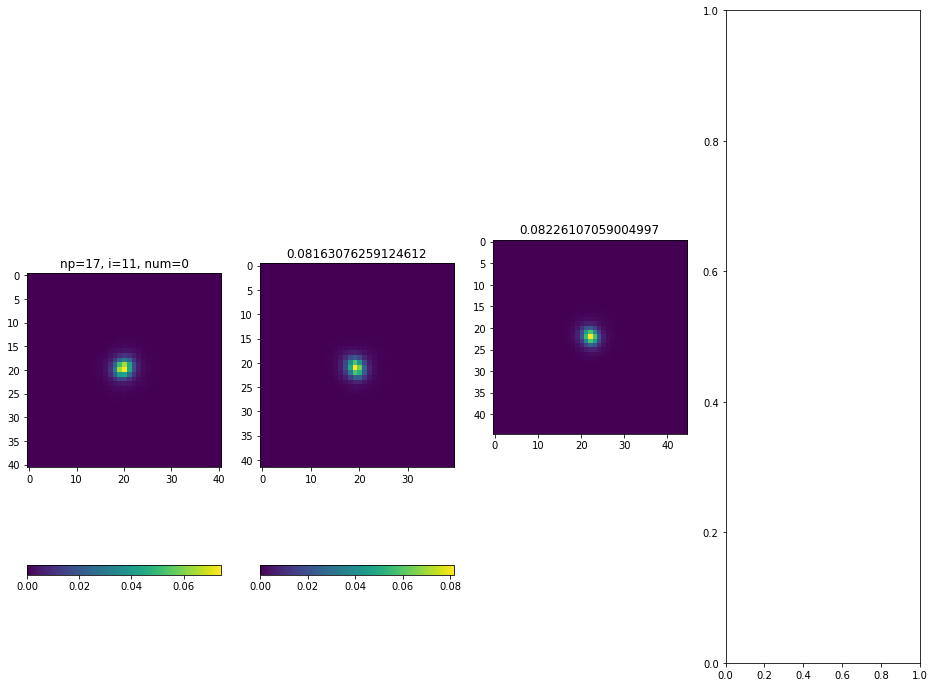

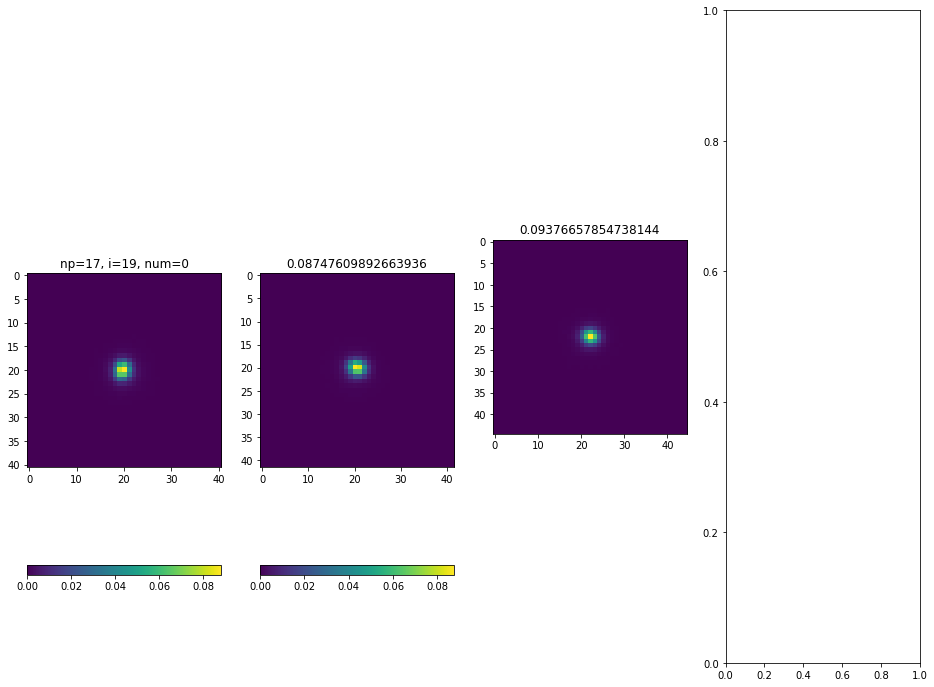

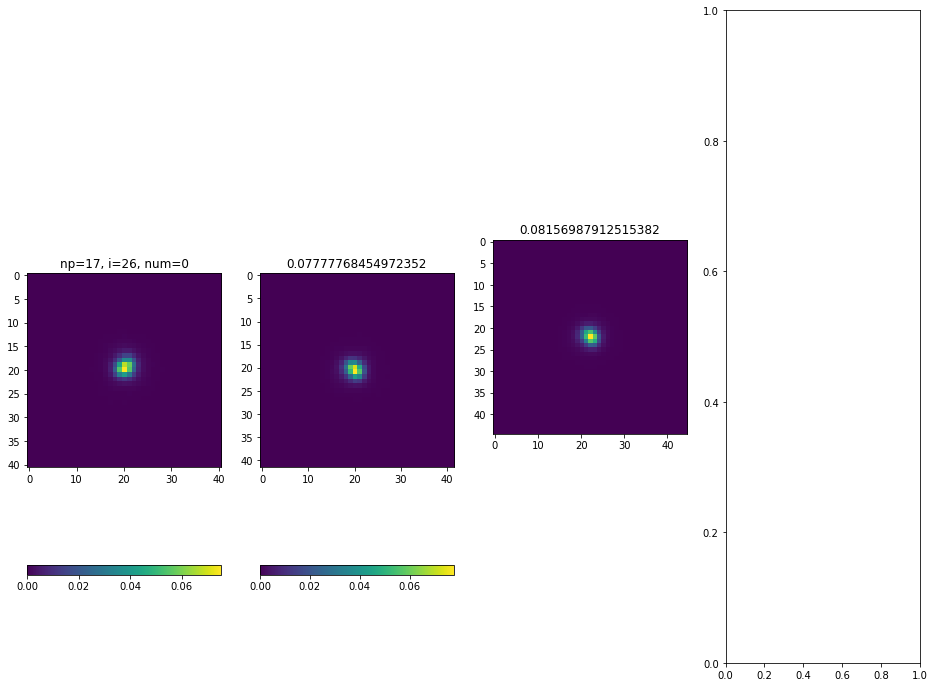

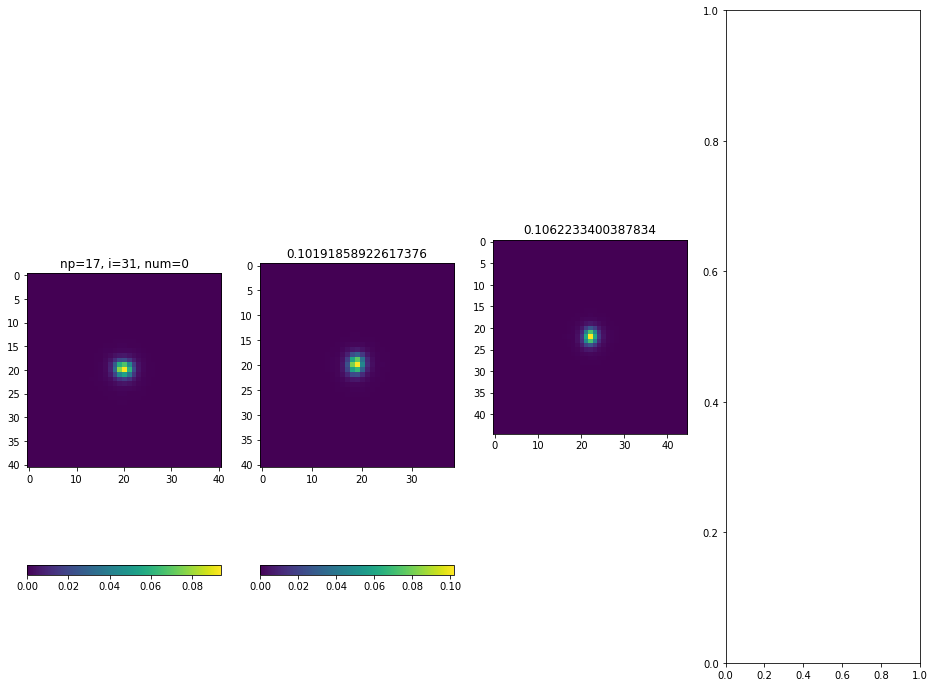

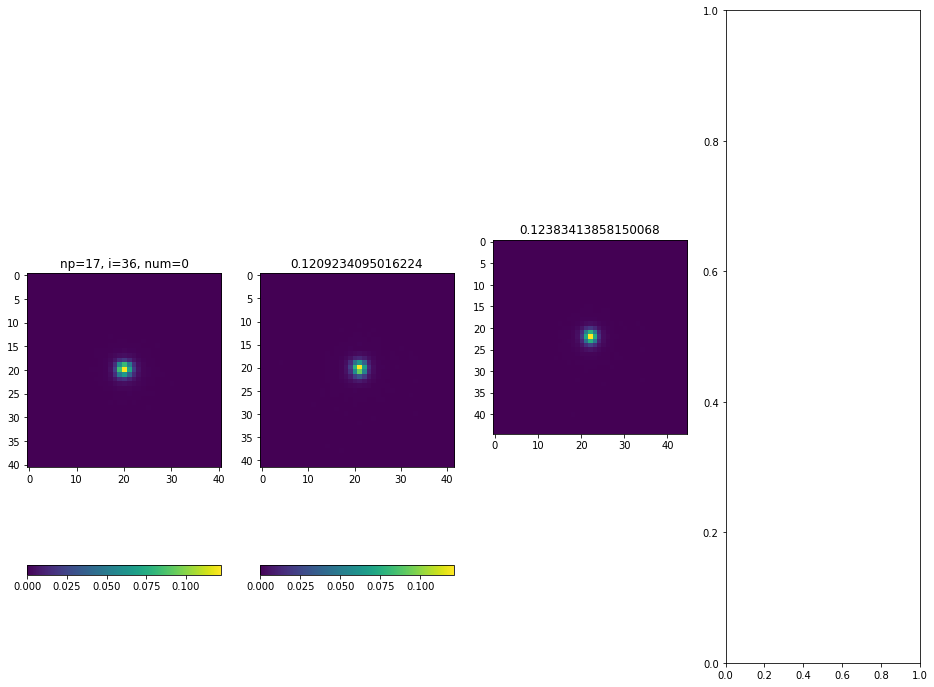

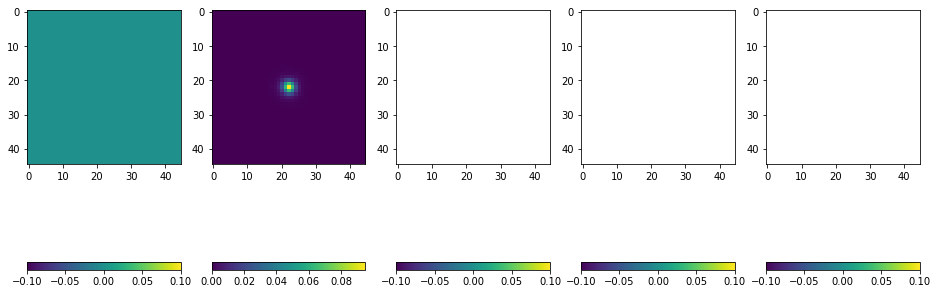

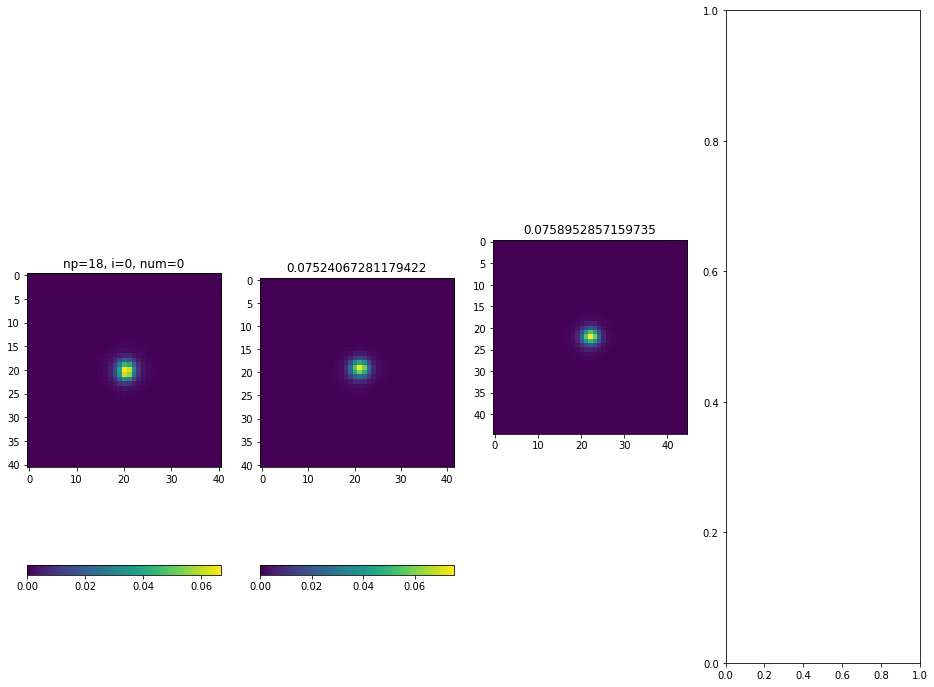

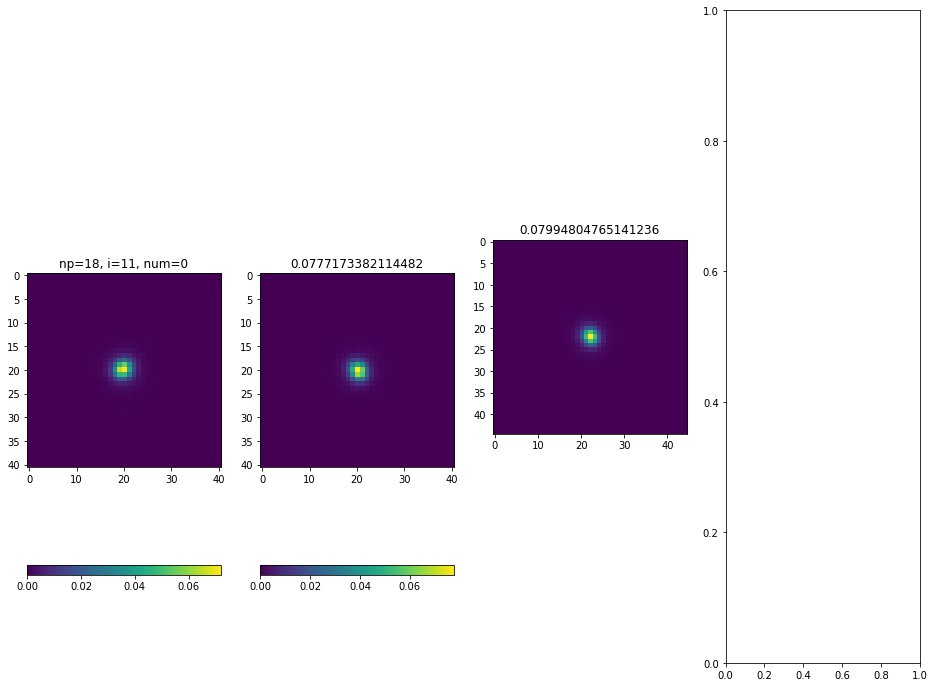

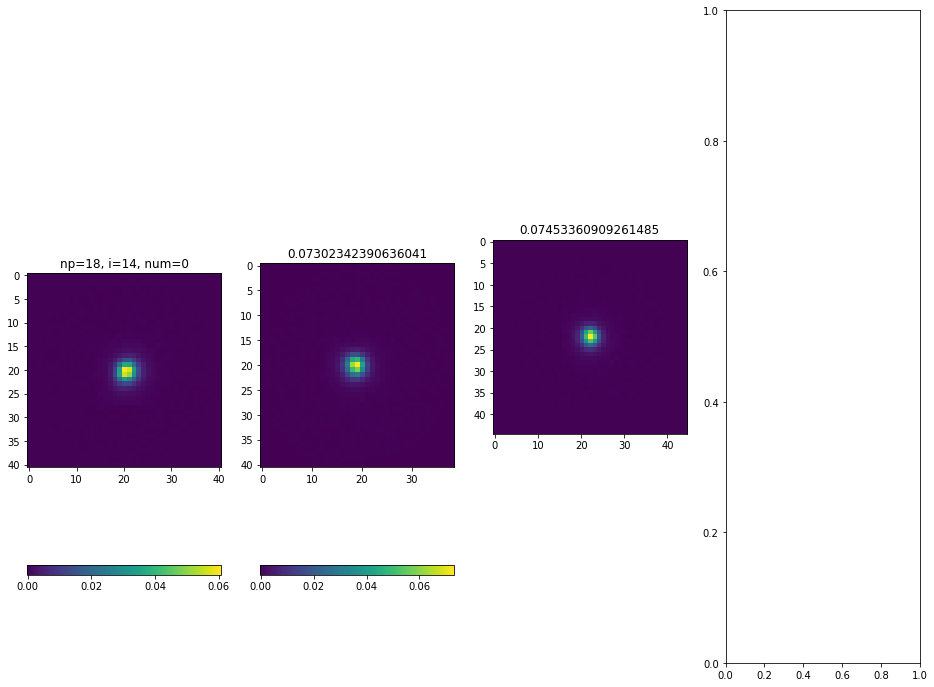

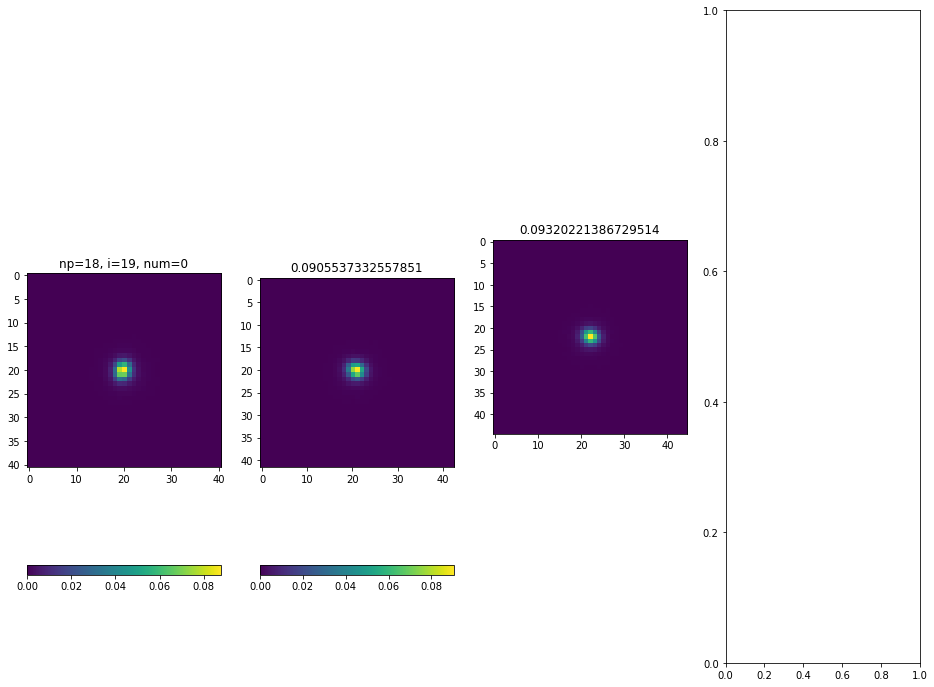

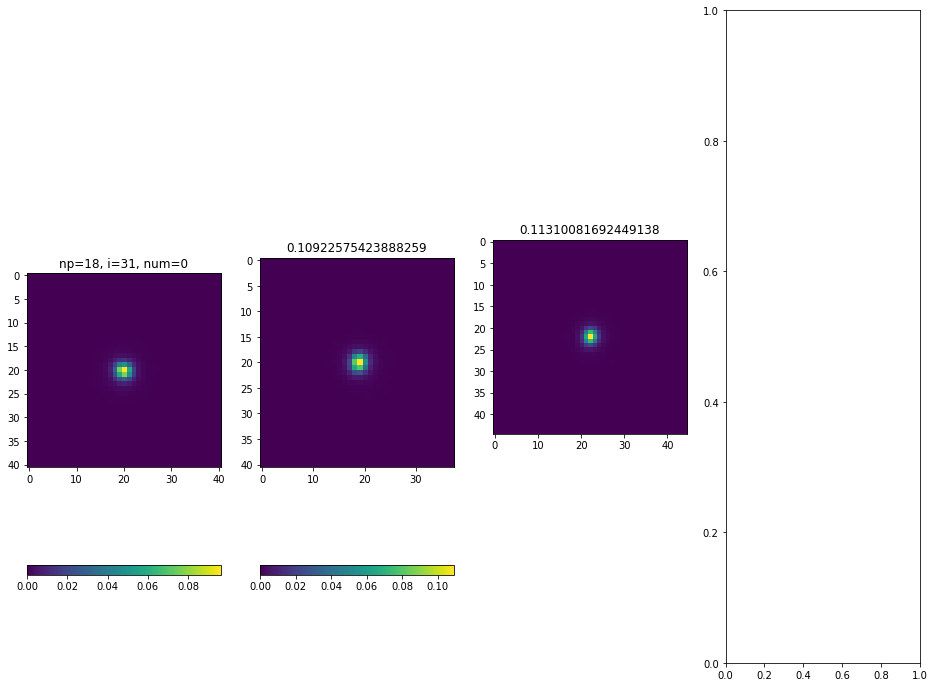

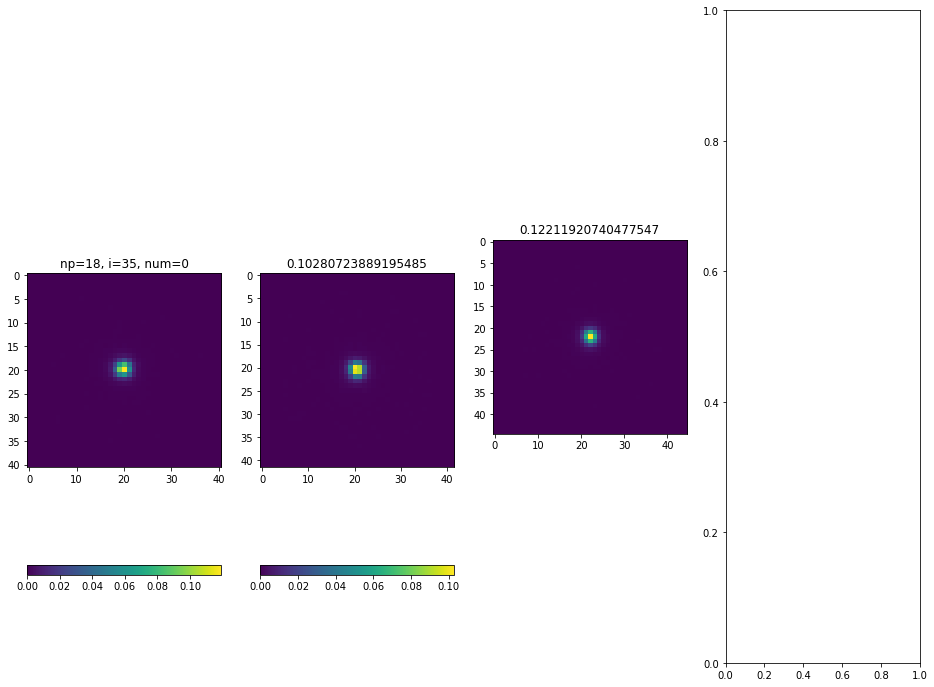

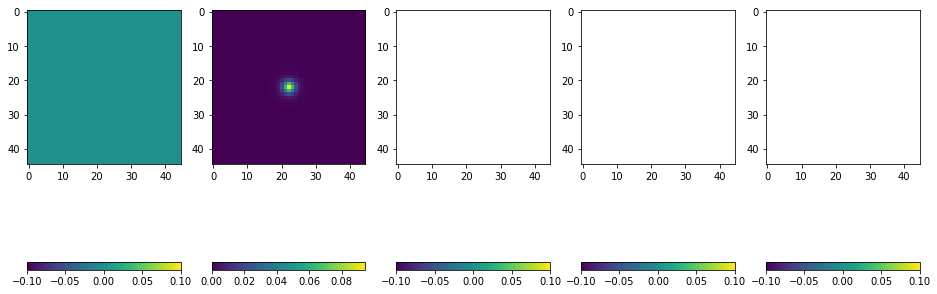

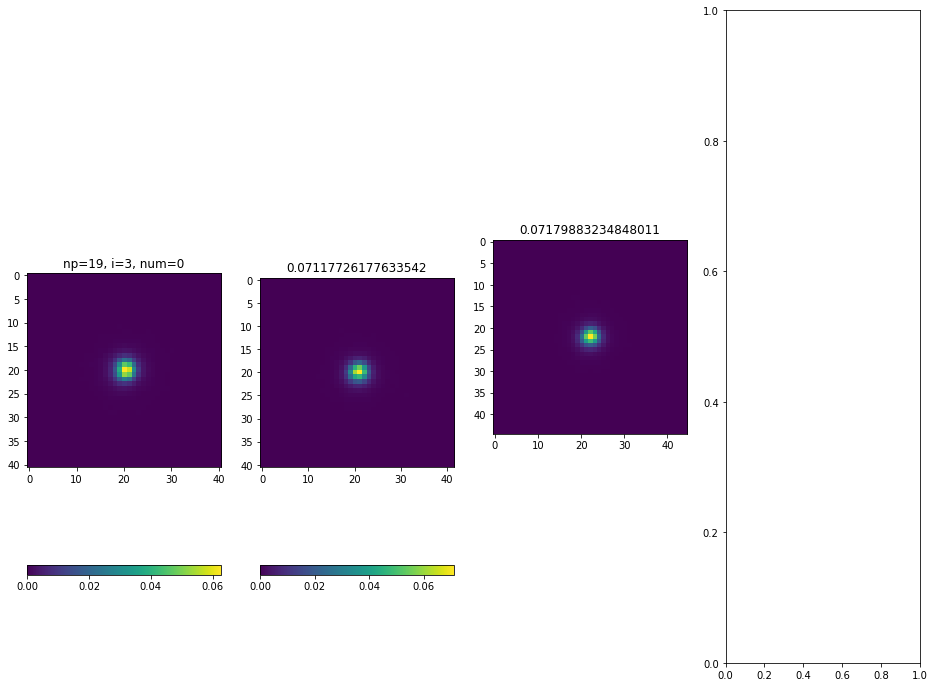

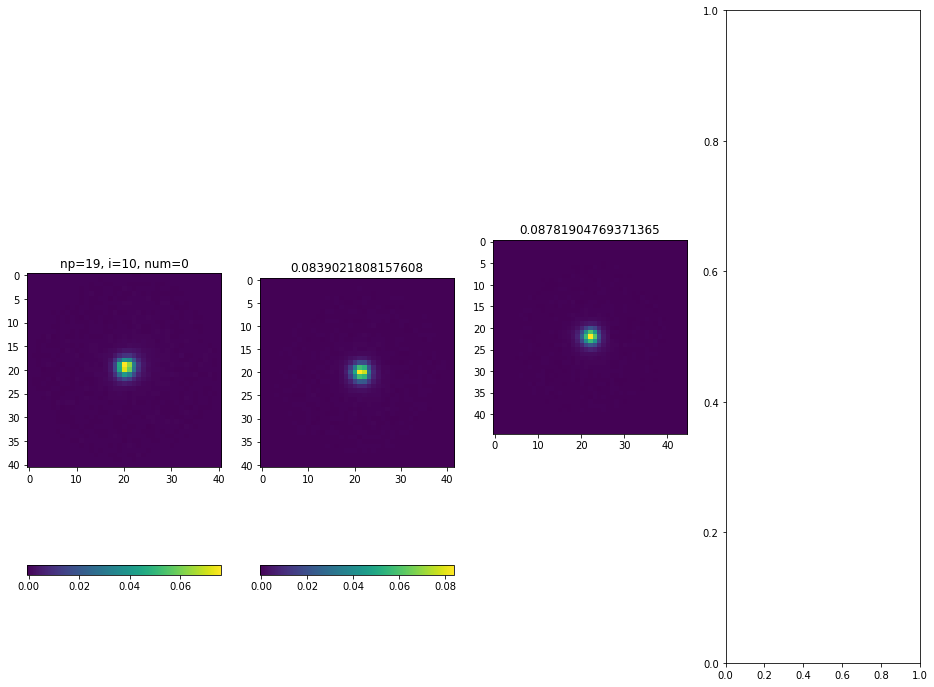

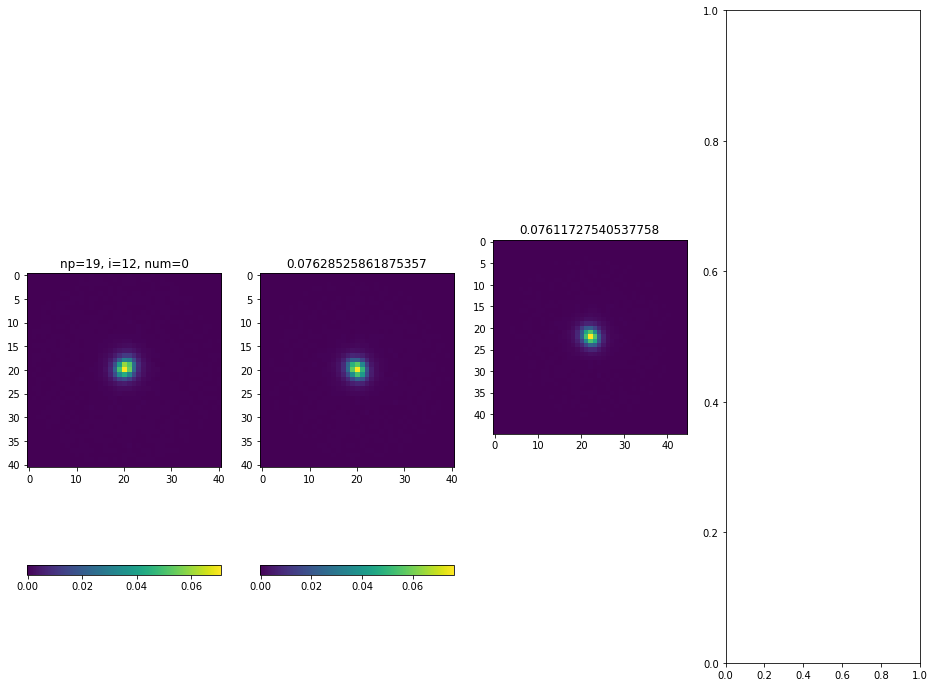

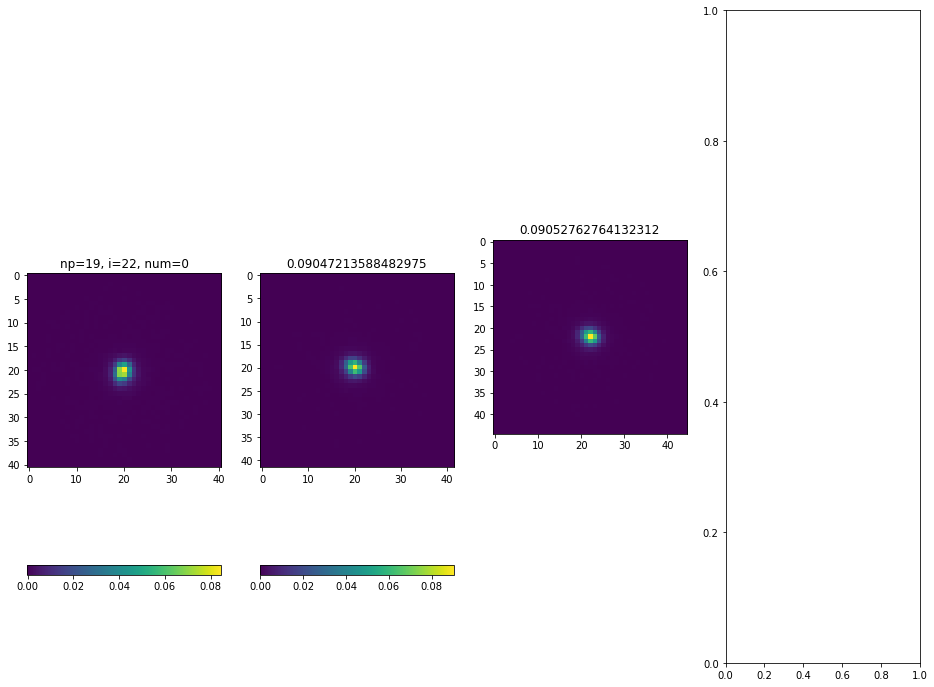

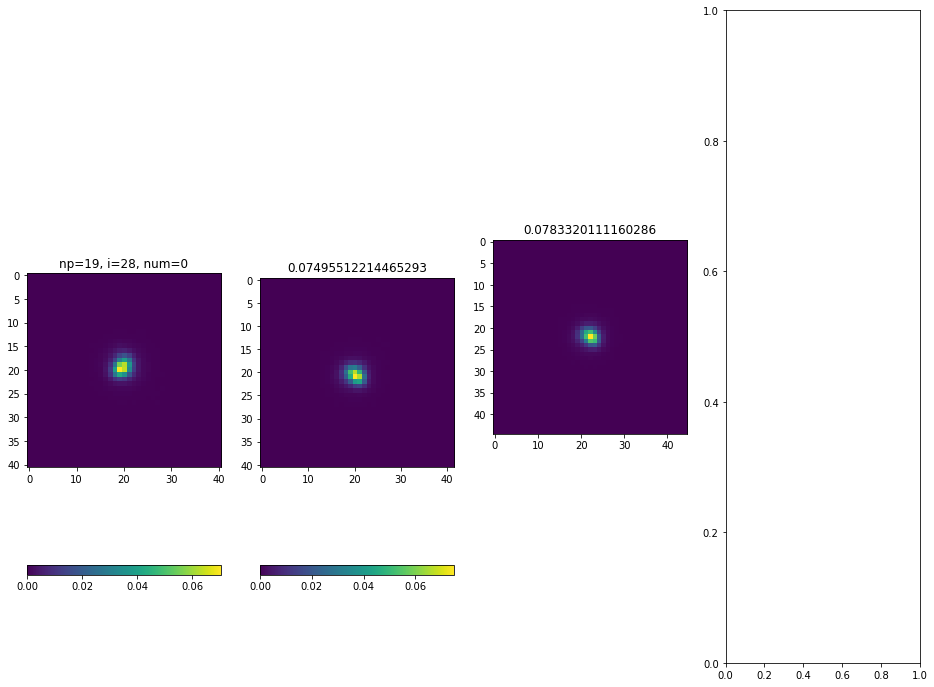

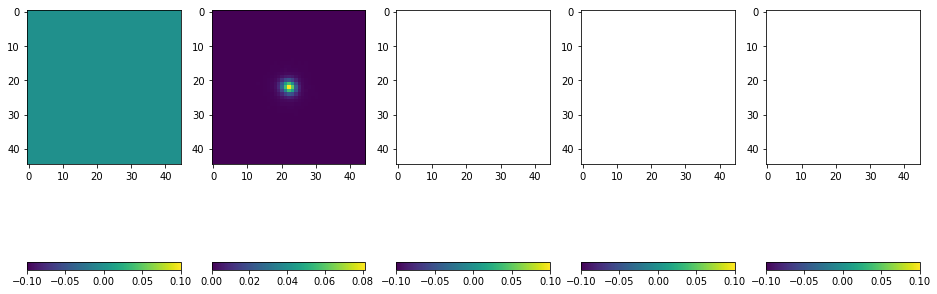

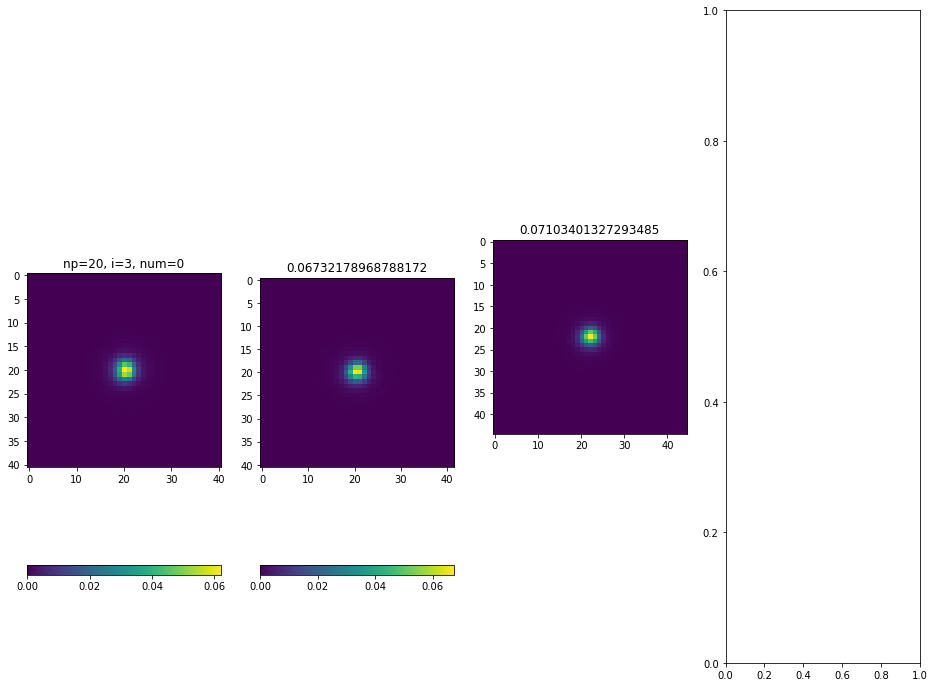

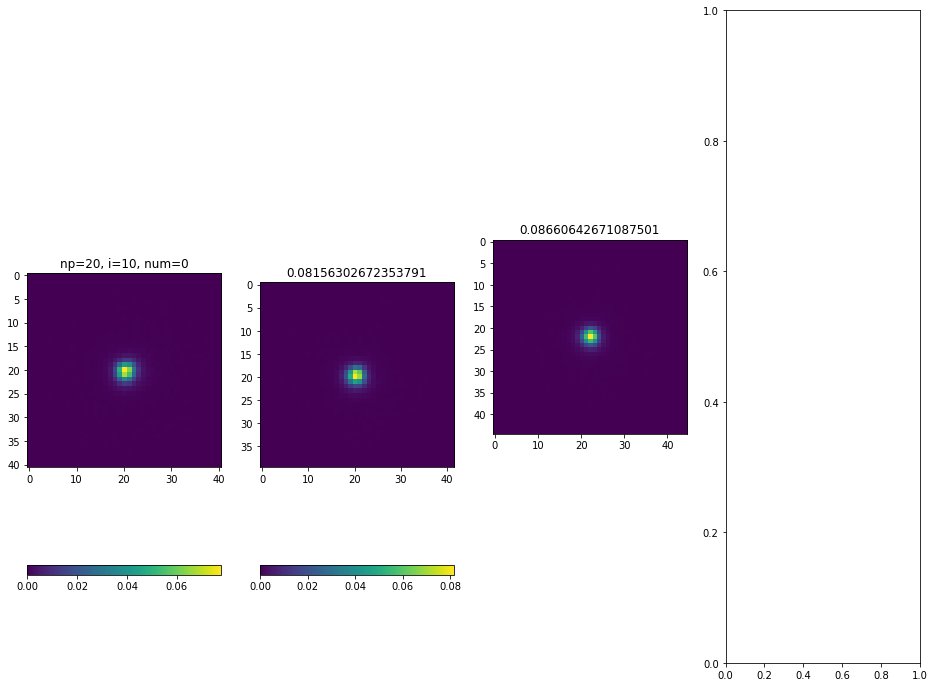

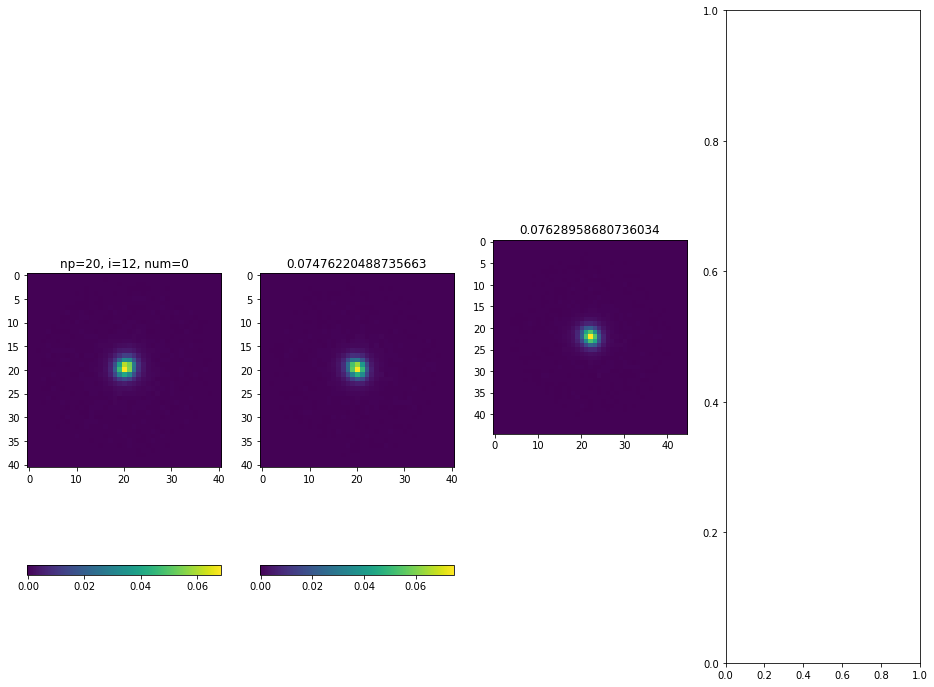

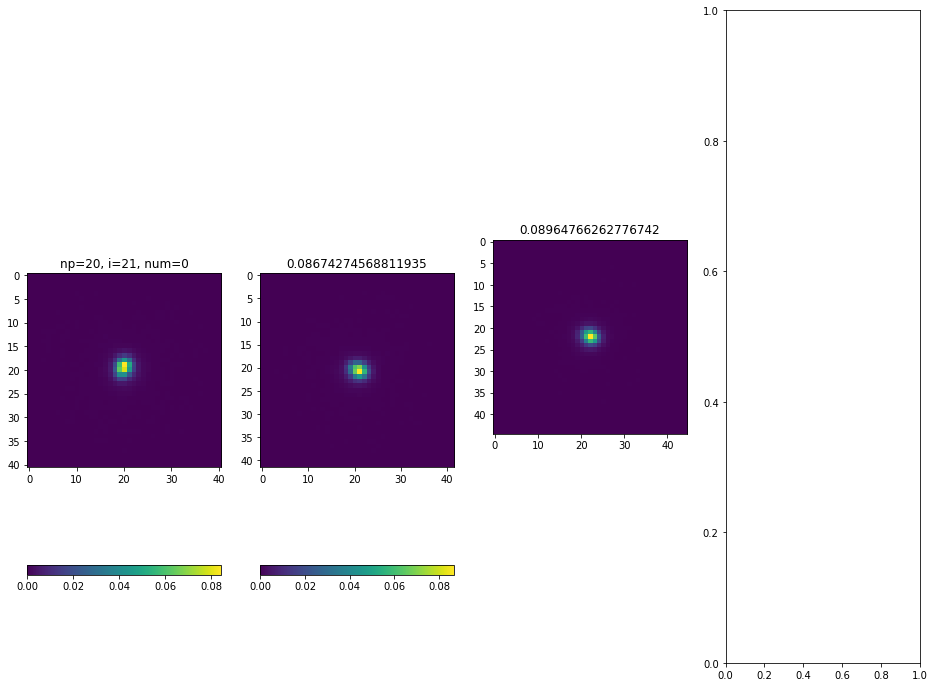

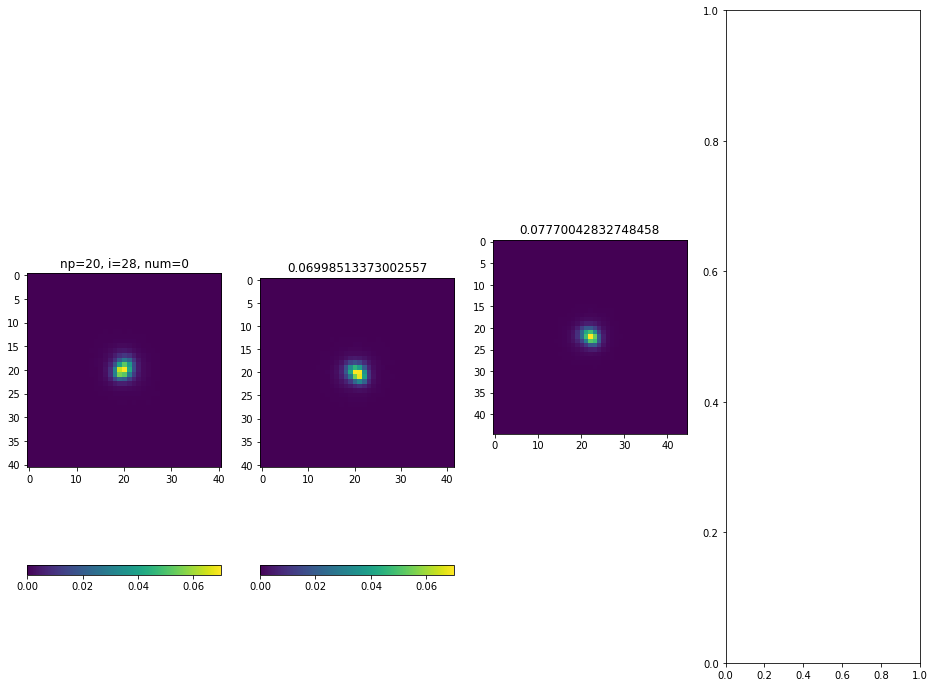

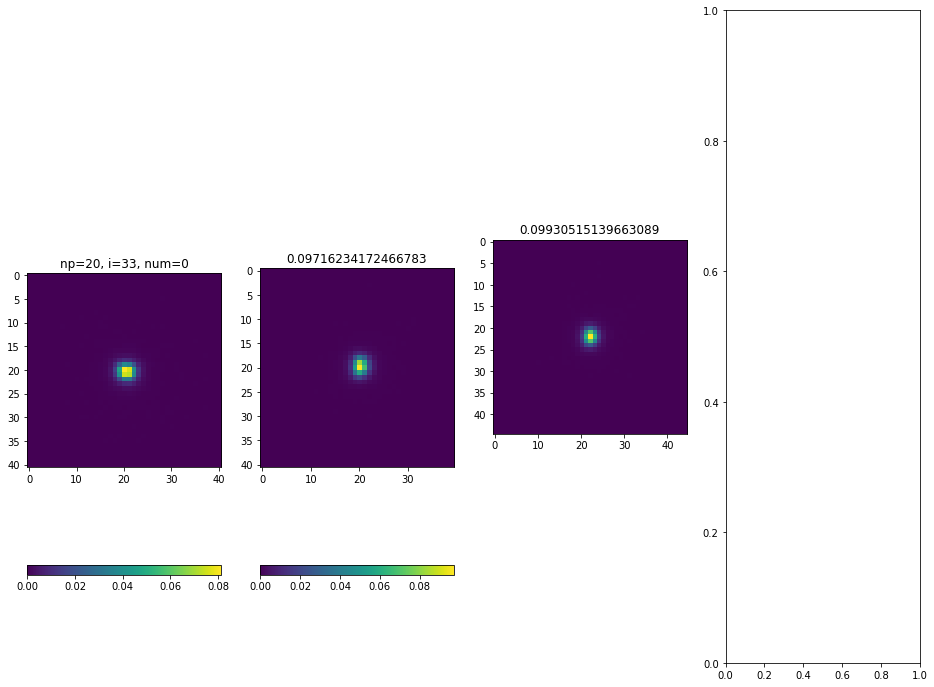

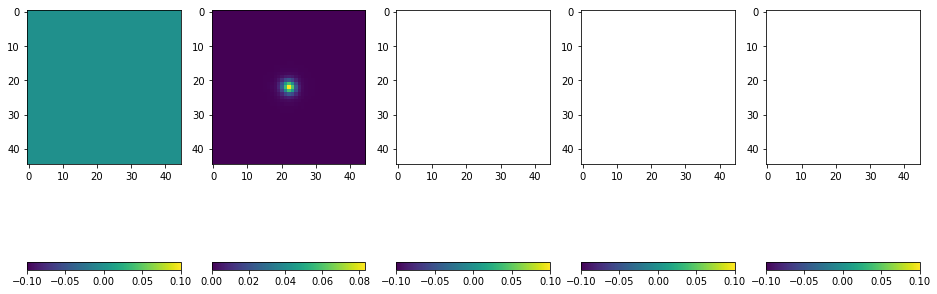

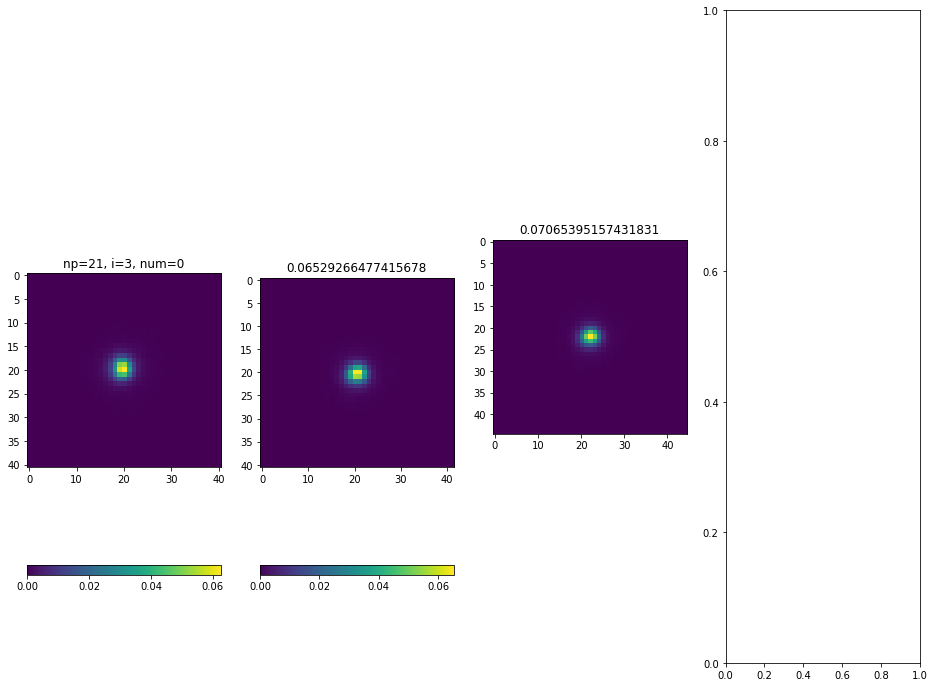

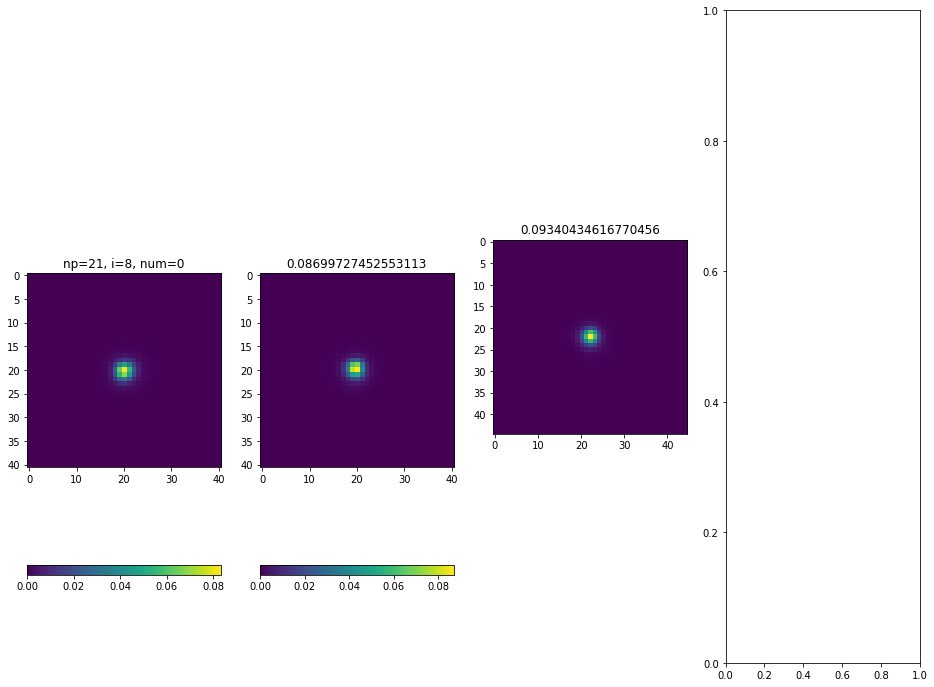

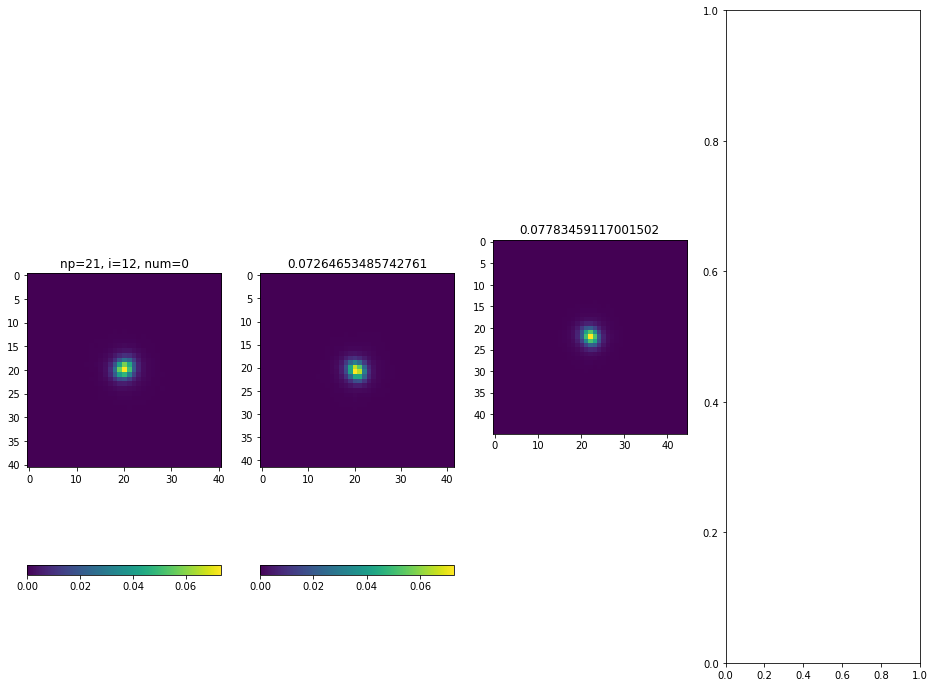

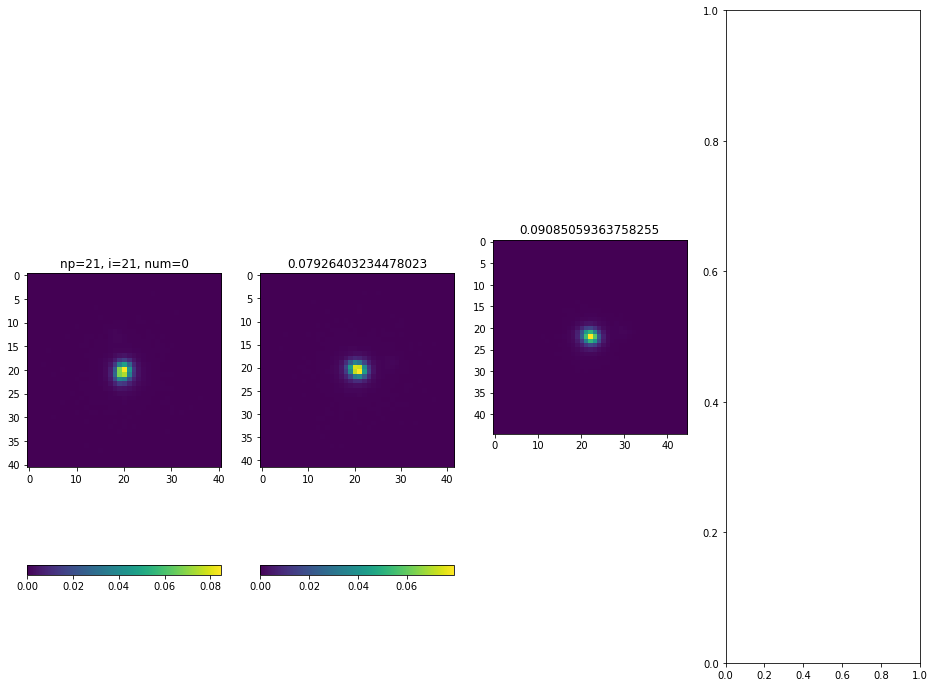

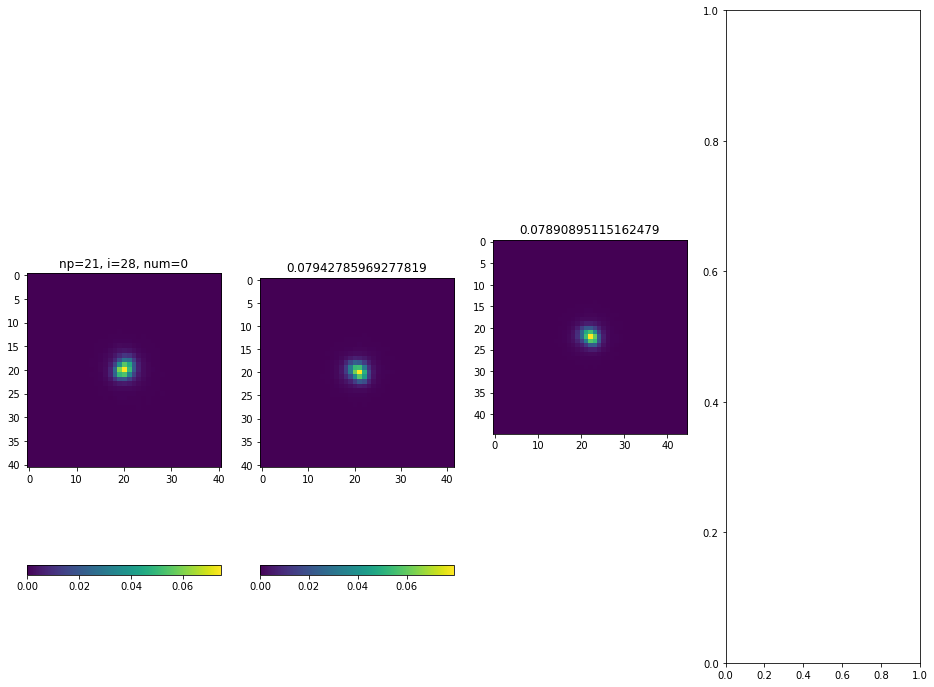

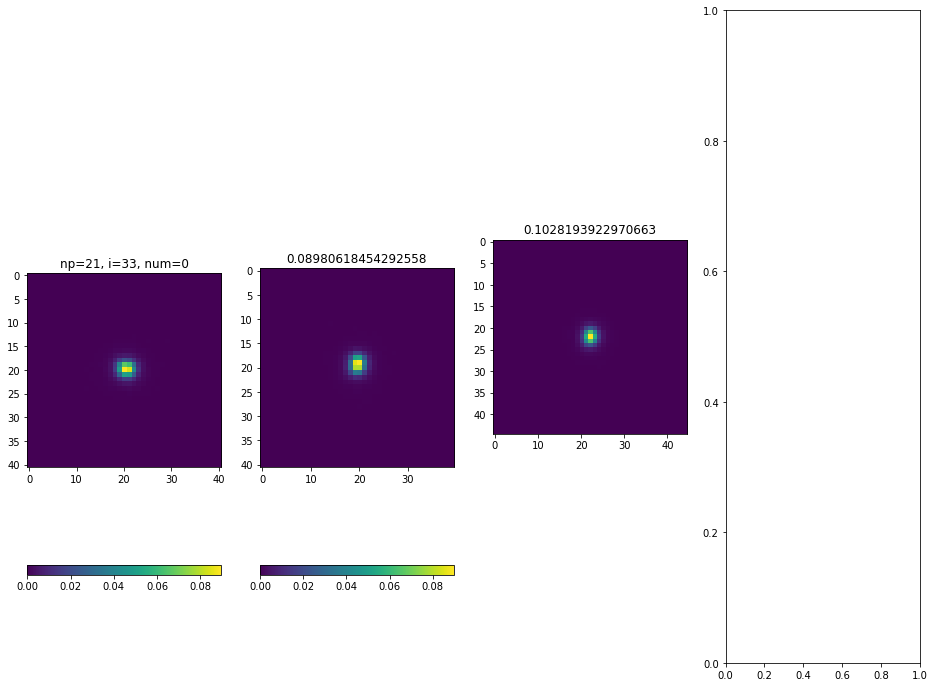

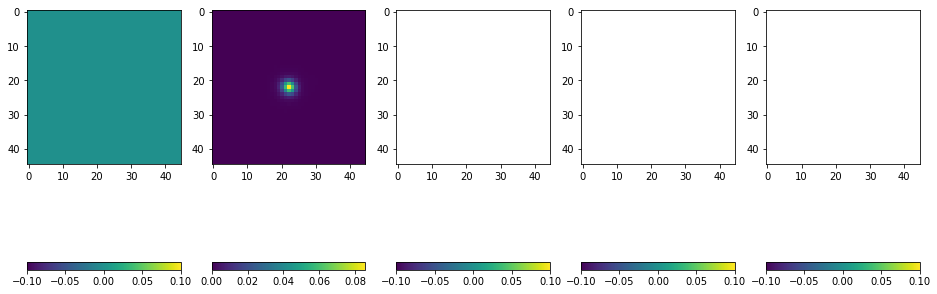

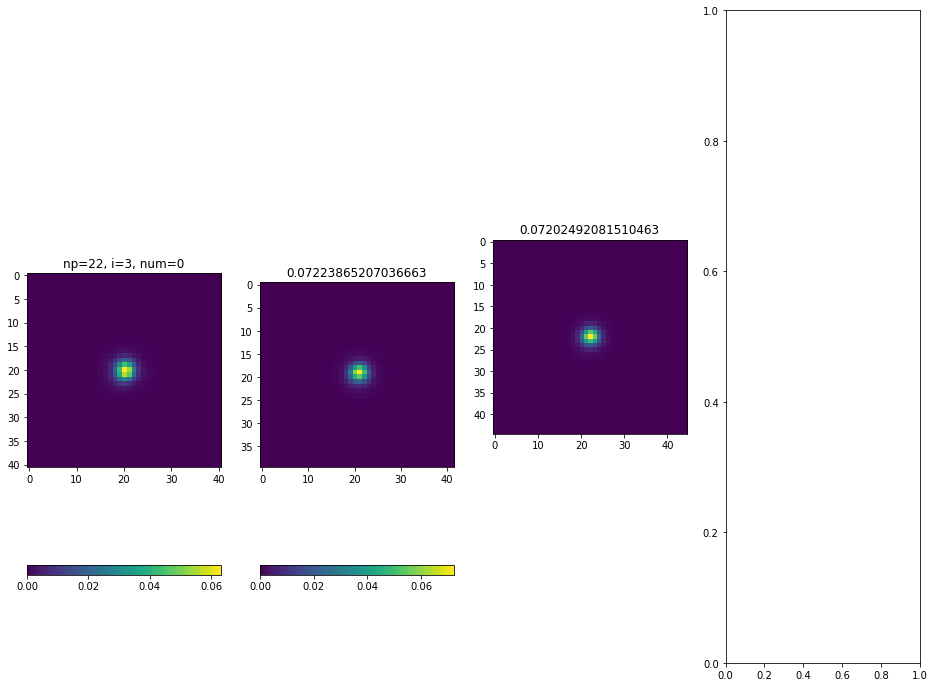

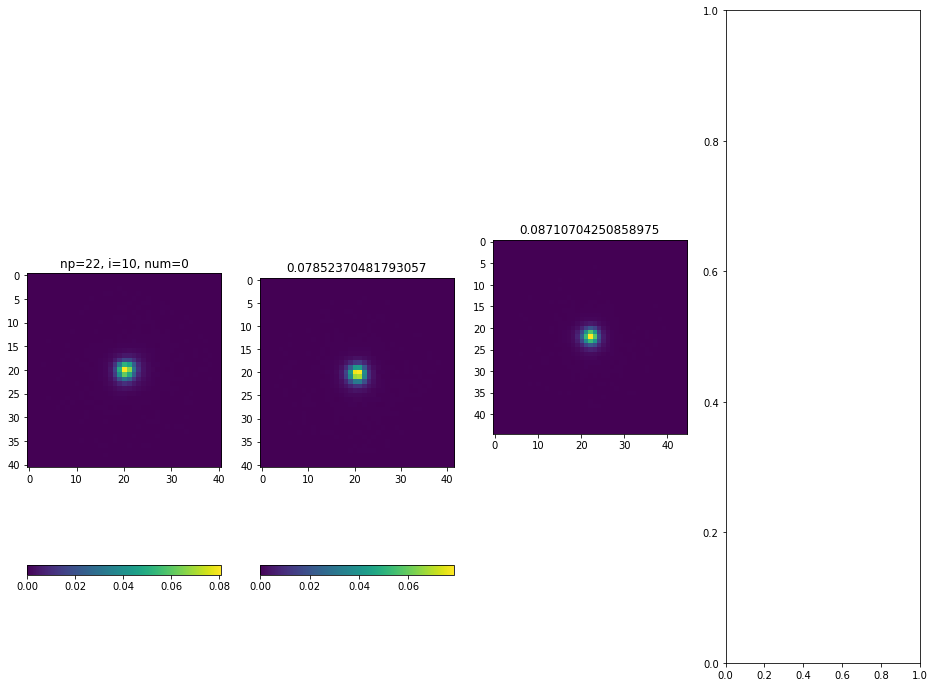

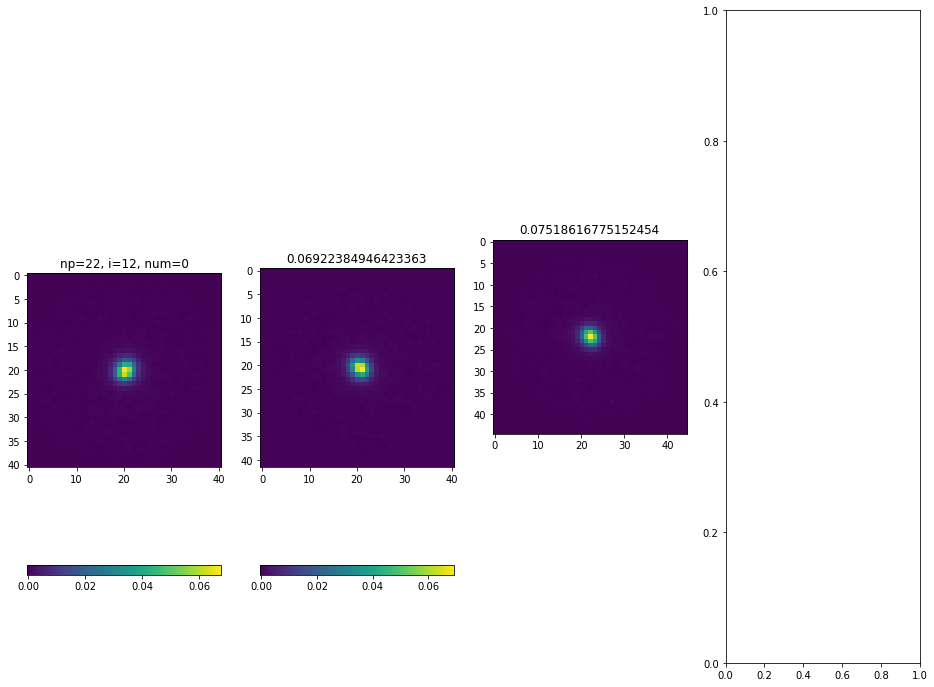

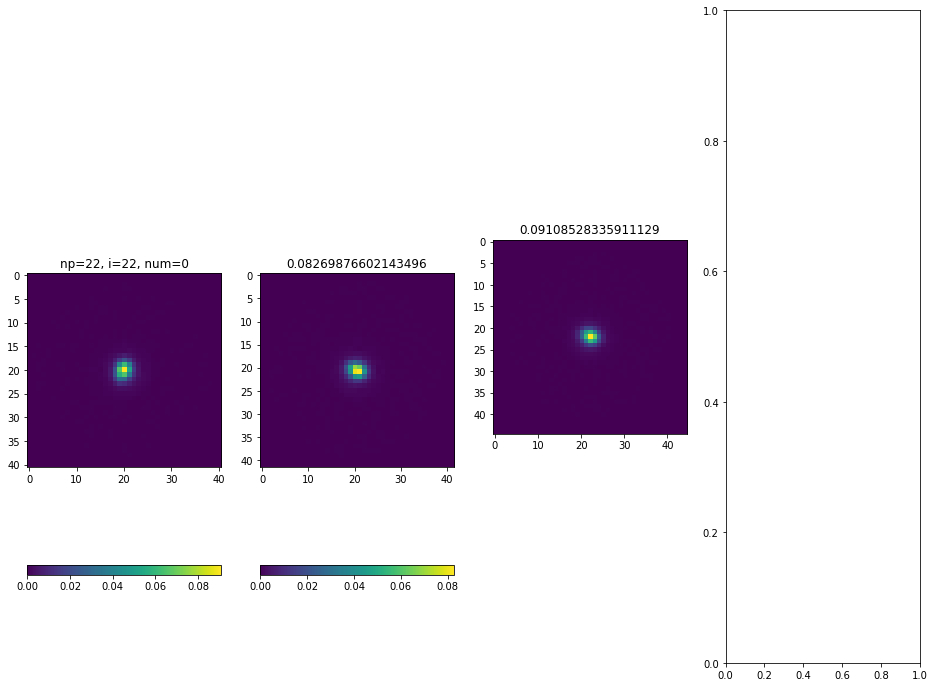

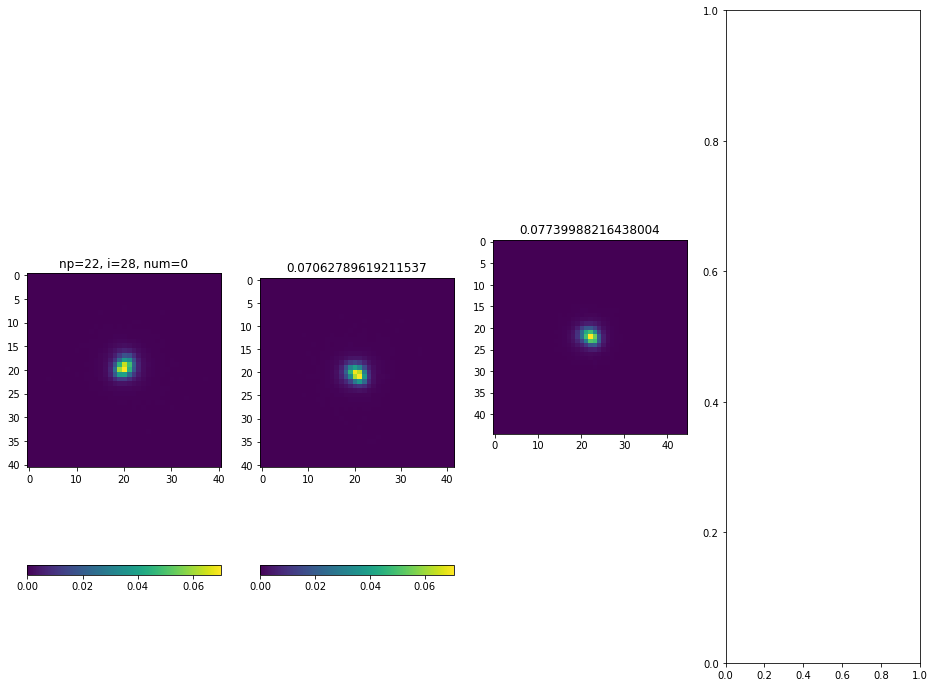

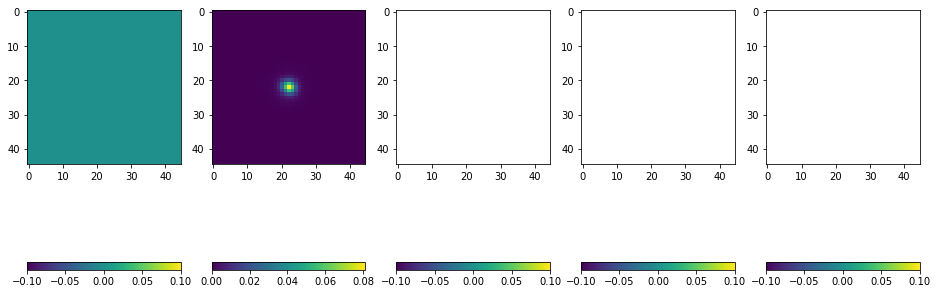

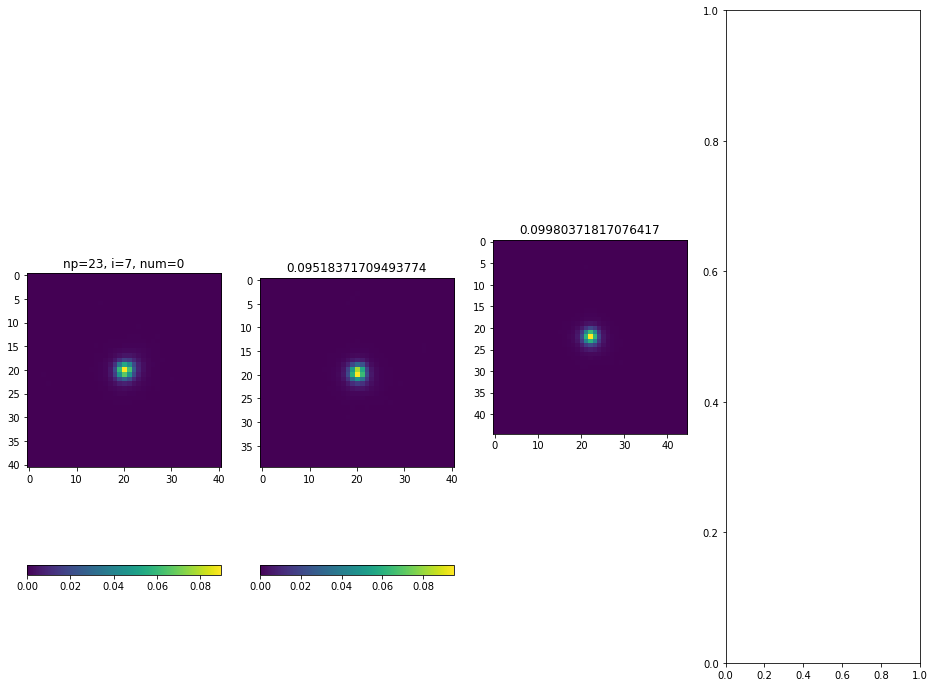

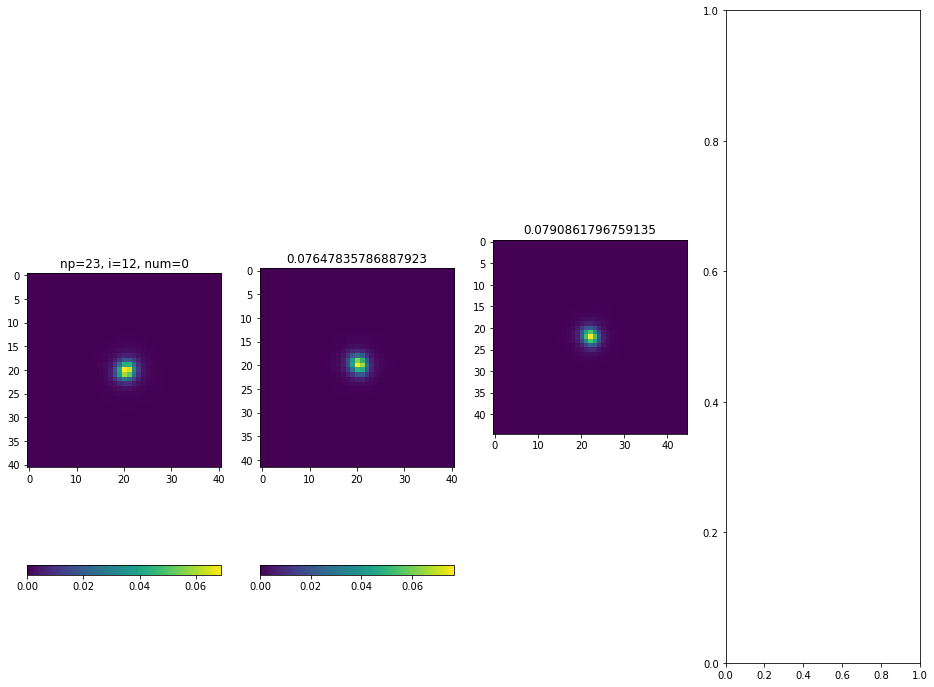

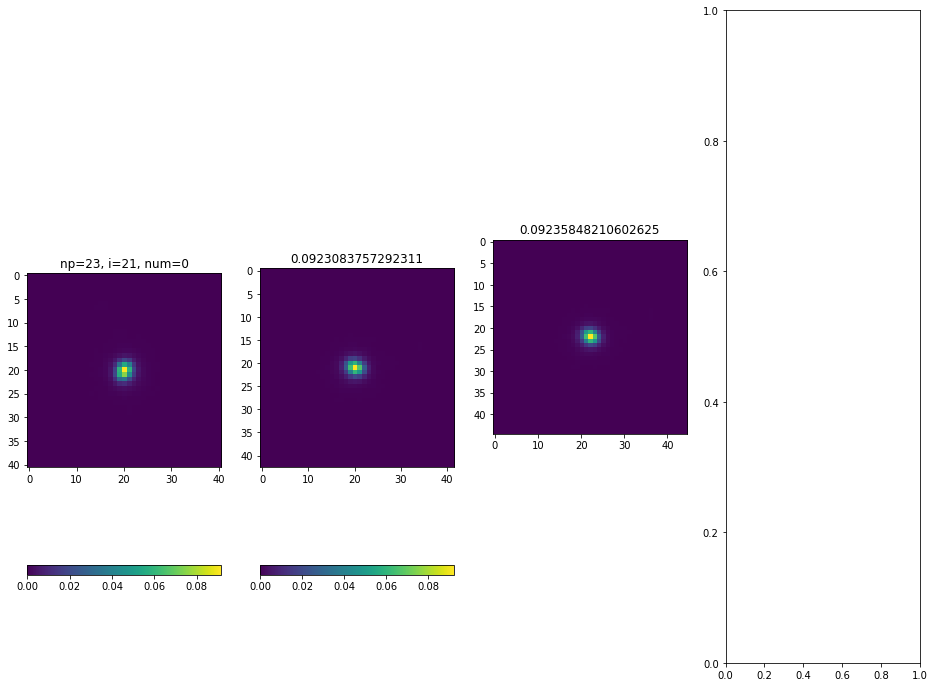

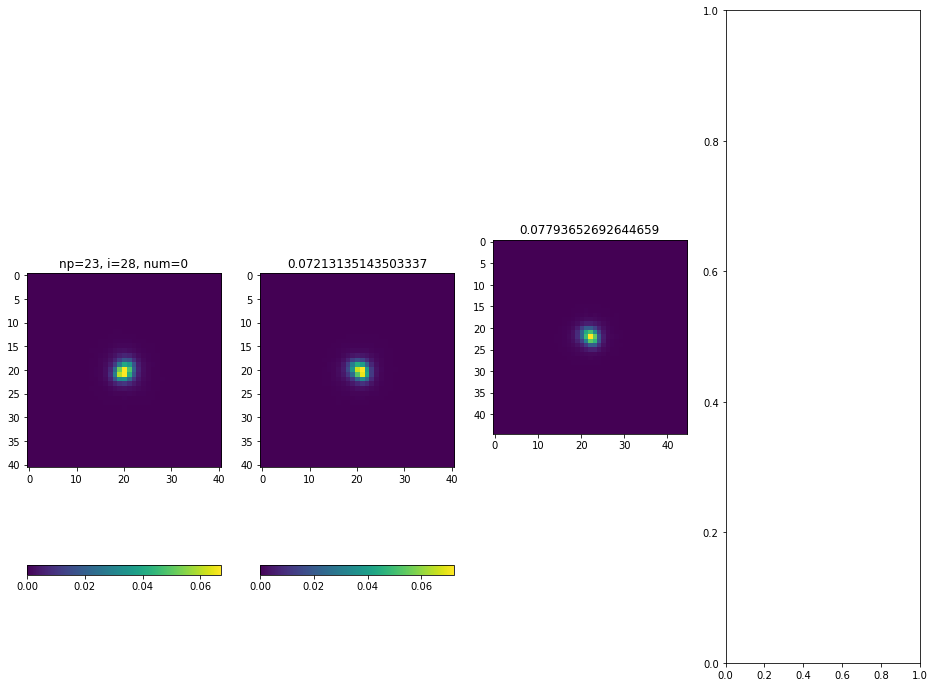

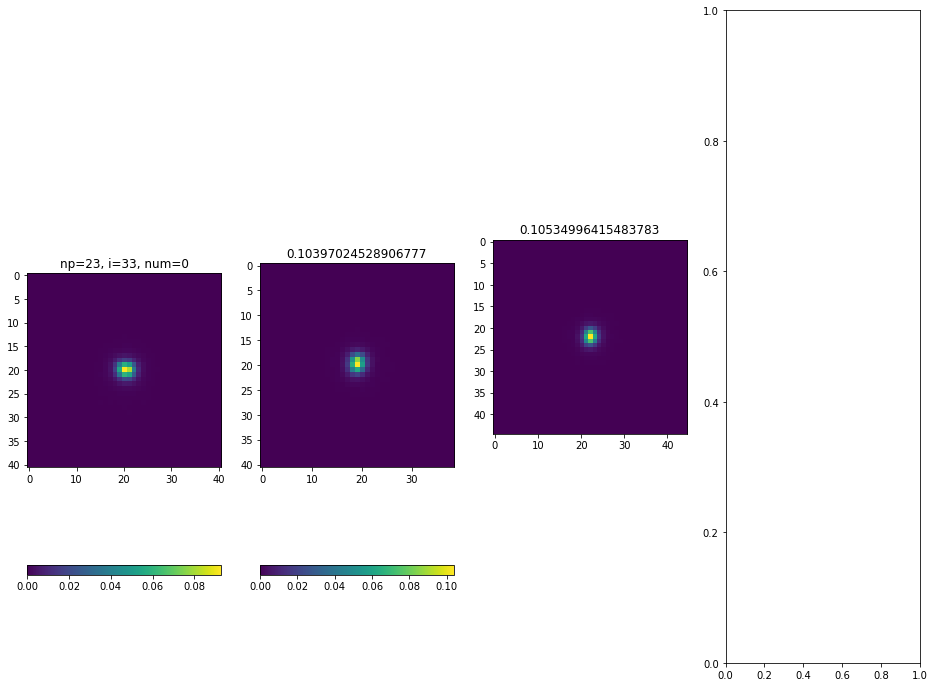

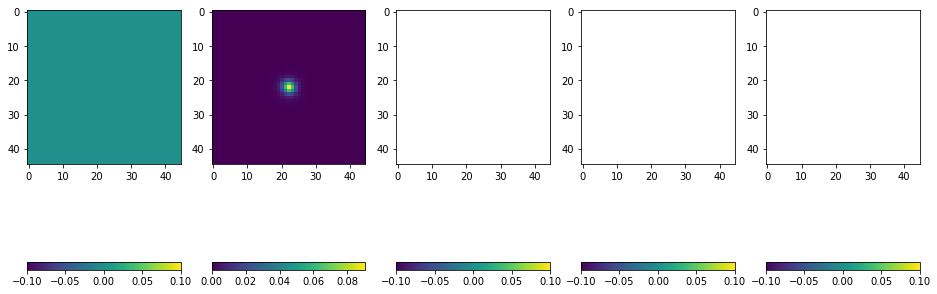

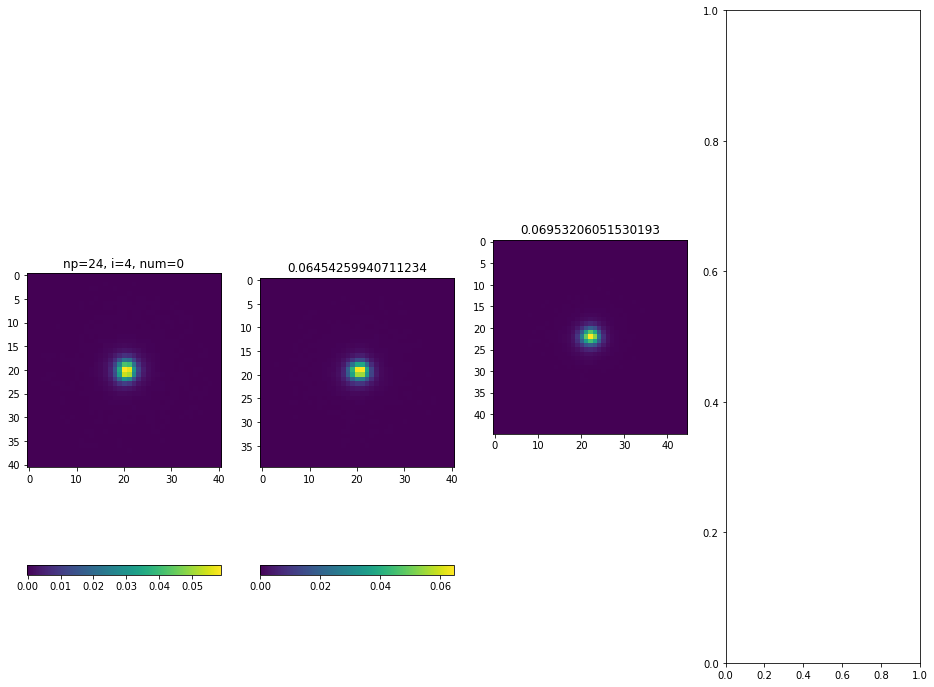

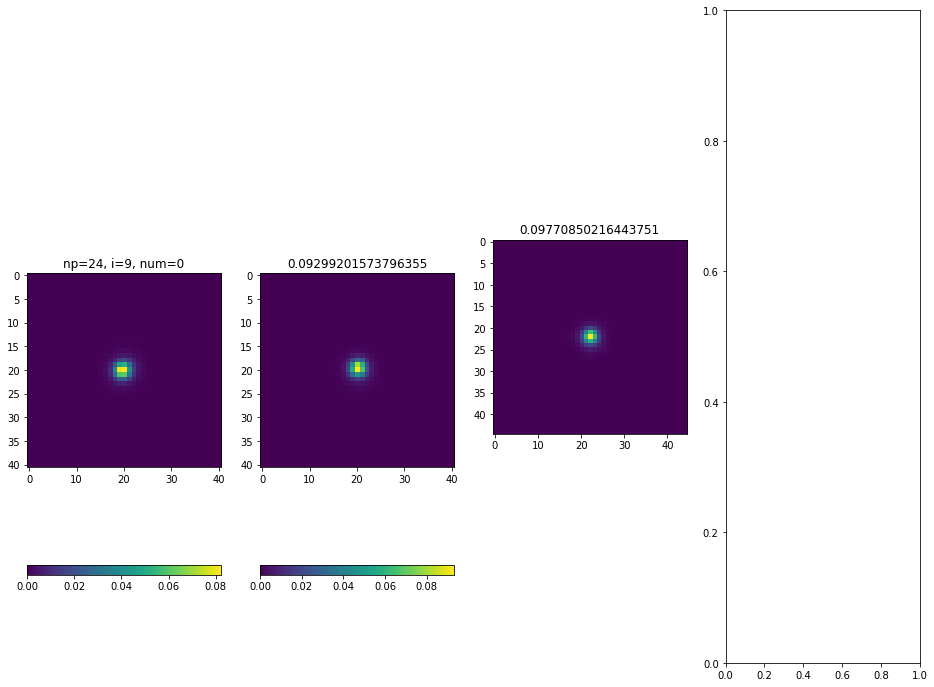

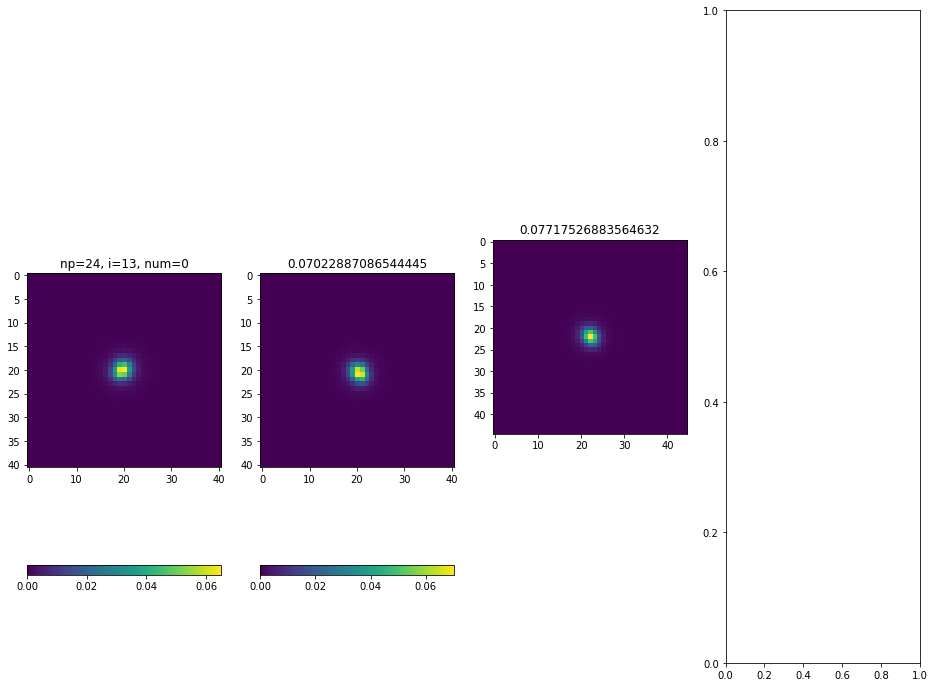

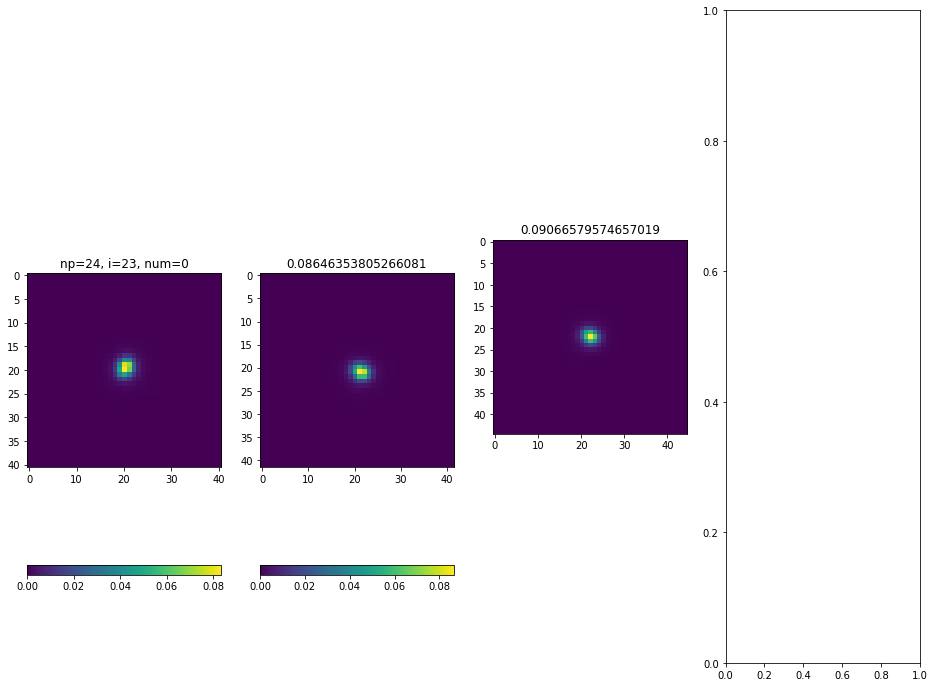

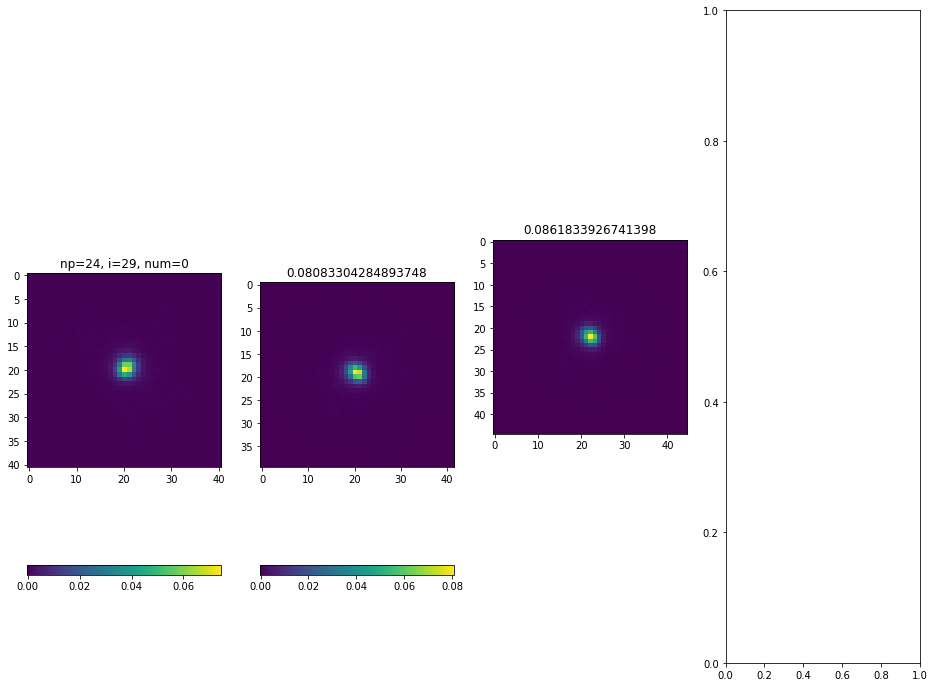

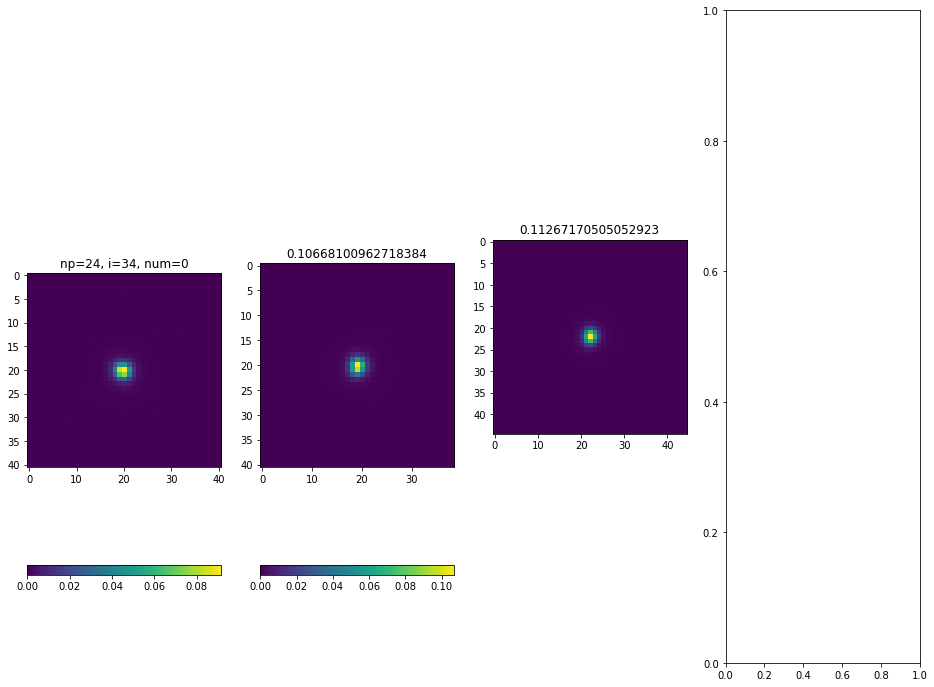

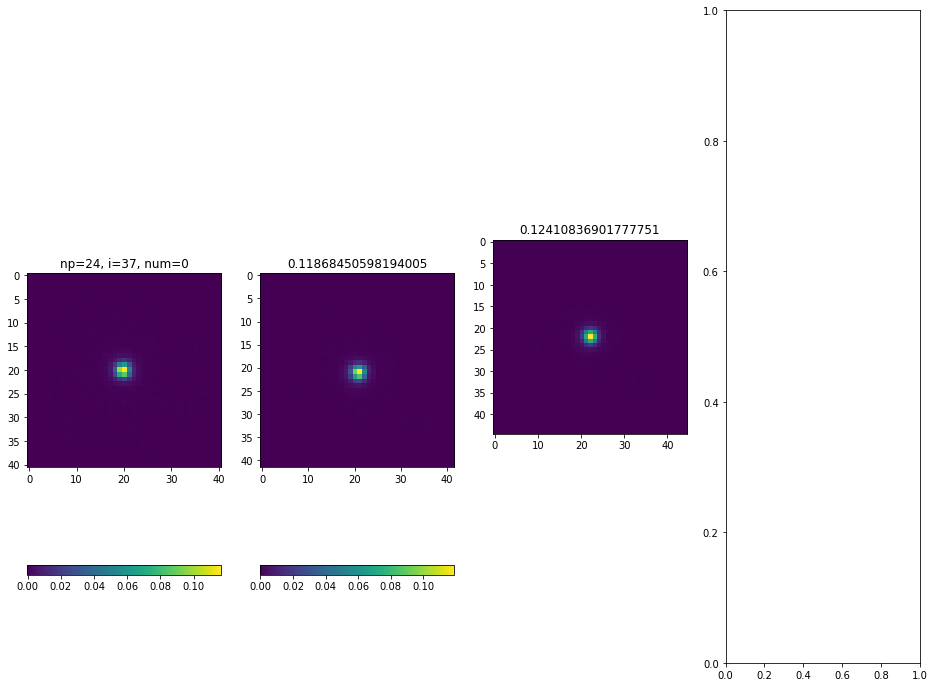

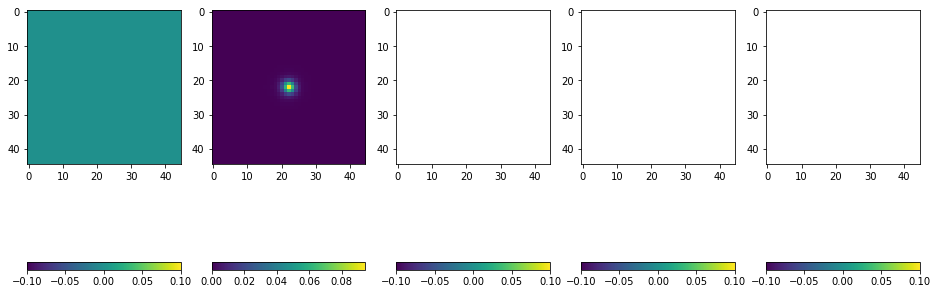

In [15]:
t1 = time.time()
nPoints = 25
nNoise = 1
noiseCancellation = False
noiseSigma = 0.0

orders = [3,5,7,9]
wc = {ord: afwMath.WarpingControl(warpingKernelName="lanczos{}".format(ord), interpLength=10) for ord in orders}

calexp_star_moments_list = []
warp_star_moments_dict = {ord: [] for ord in orders}
coadd_star_moments_dict = {ord: [] for ord in orders}

calexp_psf_moments_list = []
warp_psf_moments_dict = {ord: [] for ord in orders}
coadd_psf_moments_dict = {ord: [] for ord in orders}

bookkeeping_list = []

for nP in range(nPoints):
    if nP%25==0: print("We are now at ", nP)
    x = np.random.uniform(low=xmin, high=xmax)
    y = np.random.uniform(low=ymin, high=ymax)
    x, y = int(x), int(y)
    coaddPoint = geom.Point2D(x,y)
    
    star_coadd_dict = {ord: [ afwImage.ImageD(dimensions=geom.Extent2I(45,45)) for noise_num in range(nNoise*(1+noiseCancellation)) ] for ord in orders}    
    psf_coadd_dict = {ord: afwImage.ImageD(dimensions=geom.Extent2I(45,45)) for ord in orders}

    
    for order in star_coadd_dict.keys():
        star_coadd_list = star_coadd_dict[order]
        for star_coadd in star_coadd_list:
            star_coadd.setXY0(x0=int(coaddPoint.x)-22, y0=int(coaddPoint.y)-22)
            
        psf_coadd_dict[order].setXY0(x0=int(coaddPoint.x)-22, y0=int(coaddPoint.y)-22)
    
    for i in range(coaddPsf.getComponentCount()):
        ## Get the point in the calexp corresponding to the chosen point on the codd, which is its center
        calexpPoint = deepCoadd.getPsf().getWcs(i).skyToPixel(coaddWcs.pixelToSky(coaddPoint))
        if deepCoadd.getPsf().getValidPolygon(i).contains(calexpPoint):
            xyTransform = afwGeom.makeWcsPairTransform(coaddPsf.getWcs(i), coaddWcs)
            
            orig_psf = coaddPsf.getPsf(i)
            orig_psf_image = orig_psf.computeImage(xyTransform.applyInverse(coaddPoint))
            orig_psf_image.setXY0(x0=int(calexpPoint.x)-20, y0=int(calexpPoint.y)-20)
            psf_weight = coaddPsf.getWeight(i)
            
            noise_array_list =  [ noiseSigma*np.random.randn(41,41) for _nr in range(nNoise) ]
            if noiseCancellation:
                negative_array_list = [-noise_array for noise_array in noise_array_list]
                noise_array_list += negative_array_list
                
            for order in wc.keys():
                warped_psf = measAlg.WarpedPsf(orig_psf, xyTransform, kernelName="lanczos{}".format(order))
                warped_psf_image = grow_bbox(warped_psf.computeImage(coaddPoint))
                #psf_coadd_dict[order].array += warped_psf_image.array*psf_weight
   
                calexp_psf_moments = galsim.Image(orig_psf_image.array).FindAdaptiveMom()
                warp_psf_moments = galsim.Image(warped_psf_image.array).FindAdaptiveMom()
            
                num_images = 0
                total_weight = 0
                for noise_num, noise_array in enumerate(noise_array_list):
                    calexp_star_image = orig_psf_image.clone()
                    calexp_star_image.array += noise_array

                    warp_star_image = afwImage.ImageD(dimensions=geom.Extent2I(45,45))
                    warp_star_image.setXY0(x0=int(coaddPoint.x)-22, y0=int(coaddPoint.y)-22)
                    afwMath.warpImage(destImage=warp_star_image, srcImage=calexp_star_image, srcToDest=xyTransform, control=wc[order], padValue=0.0)
                    #print(warp_star_image.array.min(), warp_star_image.array.max())
                    
                    warp_star_image = warpLikePsf(calexp_star_image, coaddPoint, xyTransform, wc[order])
                    if not warp_star_image:
                        continue
                        
                    warp_star_image.setXY0(x0=int(coaddPoint.x)-22, y0=int(coaddPoint.y)-22)
                
                    try:
                        calexp_star_moments = galsim.Image(calexp_star_image.array).FindAdaptiveMom(strict=True)
                        warp_star_moments = galsim.Image(warp_star_image.array).FindAdaptiveMom(strict=True)

                        calexp_star_moments_list.append( calexp_star_moments )
                        warp_star_moments_dict[order].append( warp_star_moments )
                        calexp_psf_moments_list.append( calexp_psf_moments )
                        warp_psf_moments_dict[order].append( warp_psf_moments )
                        bookkeeping_list.append( (nP, coaddPoint, i, noise_num) )
                    except:
                        continue
                        
                    if order==5:    
                        fig, ax = plt.subplots(1,4)
                        fig.set_size_inches([16,12])
                        _im = [None]*len(ax)
                        _im[0] = ax[0].imshow(calexp_star_image.array)
                        _im[1] = ax[1].imshow(warp_star_image.array)
                        ax[1].set_title(warp_star_image.array.max())
                        _im[2] = ax[2].imshow(warped_psf_image.array)
                        ax[2].set_title(warped_psf_image.array.max())
                        #_im[3] = ax[3].imshow(warp_star_image.array-warped_psf_image.array)
                        ax[0].set_title("np={0}, i={1}, num={2}".format(nP,i,noise_num))
                        for jj in range(2):
                            plt.colorbar(_im[jj],ax=ax[jj],orientation='horizontal', norm=LogNorm())
                        
                    ## This part gets executed only if shape measurement is successfull
                    #star_coadd_dict[order][noise_num].array += warp_star_image.array*psf_weight
                    num_images += 1
                    total_weight += psf_weight
                        
                    
    for order in star_coadd_dict.keys():
        #np.testing.assert_array_equal( psf_coadd_dict[order].array, grow_bbox(coaddPsf.computeImage(coaddPoint)).array )
        if order==5: ## because the coaddPsf from this rerun is constructed with lanczos5
            fig, ax = plt.subplots(1,5)
            fig.set_size_inches([16,12])
            _im0 = ax[0].imshow(psf_coadd_dict[order].array)
            _im1 = ax[1].imshow(grow_bbox(coaddPsf.computeImage(coaddPoint)).array)
            _im2 = ax[2].imshow(psf_coadd_dict[order].array/psf_coadd_dict[order].array.sum()-grow_bbox(coaddPsf.computeImage(coaddPoint)).array)
            _im3 = ax[3].imshow(star_coadd_dict[order][0].array/star_coadd_dict[order][0].array.sum())
            _im4 = ax[4].imshow(star_coadd_dict[order][0].array/star_coadd_dict[order][0].array.sum()-psf_coadd_dict[order].array/psf_coadd_dict[order].array.sum())
            fig.colorbar(_im0,ax=ax[0], orientation='horizontal', norm=LogNorm())
            fig.colorbar(_im1,ax=ax[1], orientation='horizontal', norm=LogNorm())
            fig.colorbar(_im2,ax=ax[2], orientation='horizontal', norm=LogNorm())
            fig.colorbar(_im3,ax=ax[3], orientation='horizontal', norm=LogNorm())
            fig.colorbar(_im4,ax=ax[4], orientation='horizontal', norm=LogNorm())
        
        #coadd_psf_moments = galsim.Image(psf_coadd_dict[order].array).FindAdaptiveMom(strict=True)
        #for noise_num in range(nNoise*(1+noiseCancellation)):
        #    try:
        #        coadd_star_moments = galsim.Image(star_coadd_dict[order][noise_num].array).FindAdaptiveMom(strict=True)
        #        coadd_star_moments_dict[order].append( coadd_star_moments )
        #        coadd_psf_moments_dict[order].append( coadd_psf_moments )
        #    except:
        #        pass
                
t2 = time.time()
print("Master block executed in %.2f" % (t2-t1), " seconds" )
print("Created a list of %d measurements" % (len(calexp_star_moments_list)))

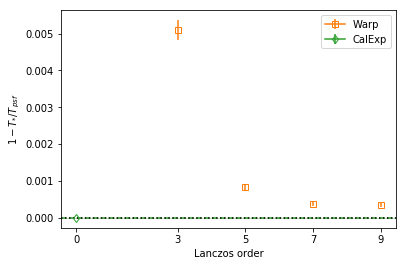

In [19]:
sizeDef = 'Trace' # 'Sigma' or 'Trace'
getSize = getTraceRadius if sizeDef=='Trace' else getSigma
for order in [3,5,7,9]:
    y_coadd = 1.-np.array([getSize(star_moment)/getSize(psf_moment) for star_moment, psf_moment in zip(coadd_star_moments_dict[order],coadd_psf_moments_dict[order])])
    y_warp = 1.-np.array([getSize(star_moment)/getSize(psf_moment) for star_moment, psf_moment in zip(warp_star_moments_dict[order],warp_psf_moments_dict[order])])
    
    #label = 'Coadd' if order==3 else None
    #plt.errorbar(order, np.mean(y_coadd), np.std(y_coadd)/np.sqrt(len(y_coadd)), color='C0',marker='o', fillstyle='none', label=label)
    
    label = "Warp" if order==3 else None
    plt.errorbar(order, np.mean(y_warp), np.std(y_warp)/np.sqrt(len(y_warp)), color='C1',marker='s',fillstyle='none',label=label)

y_calexp = 1.-np.array([getSize(star_moment)/getSize(psf_moment) for star_moment, psf_moment in zip(calexp_star_moments_list,calexp_psf_moments_list)] )

yval, yerr = np.mean(y_calexp), np.sqrt(len(wc.keys()))*np.std(y_calexp)/np.sqrt(len(y_calexp))
plt.errorbar(0, yval, yerr, color='C2', marker='d', fillstyle='none', label='CalExp')
plt.axhline(yval, color='C2', ls='--')
plt.axhspan(ymin=yval-yerr, ymax=yval+yerr, color='C2', alpha=0.3)
plt.axhline(0.0, color='k', ls=':')
plt.xlabel('Lanczos order')
plt.xticks([0]+orders)
if sizeDef=='Sigma':
    #plt.ylim([-0.002,0.005])
    plt.ylabel(r'$1-\sigma_{*}/\sigma_{psf}$')
else:
    #plt.ylim([-0.0005,0.004])
    plt.ylabel(r'$1-T_{*}/T_{psf}$')
plt.legend(loc='best')

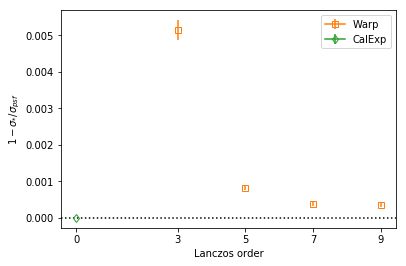

In [18]:
for order in [3,5,7,9]:
    y_coadd = 1.-np.array([star_moment.moments_sigma/psf_moment.moments_sigma for star_moment, psf_moment in zip(coadd_star_moments_dict[order],coadd_psf_moments_dict[order])])
    y_warp = 1.-np.array([star_moment.moments_sigma/psf_moment.moments_sigma for star_moment, psf_moment in zip(warp_star_moments_dict[order],warp_psf_moments_dict[order])])
    
    #label = 'Coadd' if order==3 else None
    #plt.errorbar(order, np.mean(y_coadd), np.std(y_coadd)/np.sqrt(len(y_coadd)), color='C0',marker='o', fillstyle='none', label=label)
    
    label = "Warp" if order==3 else None
    plt.errorbar(order, np.mean(y_warp), np.std(y_warp)/np.sqrt(len(y_warp)), color='C1',marker='s',fillstyle='none',label=label)

y_calexp = 1.-np.array([star_moment.moments_sigma/psf_moment.moments_sigma for star_moment, psf_moment in zip(calexp_star_moments_list,calexp_psf_moments_list)] )
plt.errorbar(0, np.mean(y_calexp), np.std(y_calexp)/np.sqrt(len(y_calexp)), color='C2', marker='d', fillstyle='none', label='CalExp')
plt.axhline(0.0, color='k', ls=':')
#plt.ylim([-0.001,0.005])
#plt.ylim([-0.005,0.0065])
plt.xlabel('Lanczos order')
plt.ylabel(r'$1-\sigma_{*}/\sigma_{psf}$')
plt.xticks([0]+orders)
plt.legend(loc='best')

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


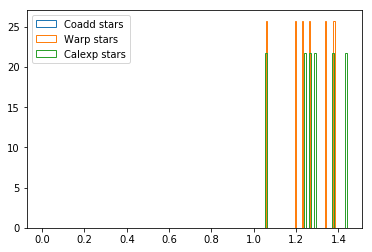

In [13]:
plt.hist([star_moment.moments_sigma for star_moment in coadd_star_moments_dict[3]], bins=50, histtype='step', density=True, label='Coadd stars')
#plt.hist([psf_moment.moments_sigma for psf_moment in coadd_psf_moments_dict[3]], bins=50, histtype='step', density=True, label='Coadd PSFs')
plt.hist([star_moment.moments_sigma for star_moment in warp_star_moments_dict[3]], bins=50, histtype='step', density=True, label='Warp stars')
#plt.hist([psf_moment.moments_sigma for psf_moment in warp_psf_moments_dict[3]], bins=50, histtype='step', density=True, label='Warp PSFs')
plt.hist([star_moment.moments_sigma for star_moment in calexp_star_moments_list], bins=50, histtype='step', density=True, label='Calexp stars')
#plt.hist([psf_moment.moments_sigma for psf_moment in calexp_psf_moments_list], bins=50, histtype='step', density=True, label='Calexp PSFs')

plt.legend()

In [14]:
dCalexpSigma = [calexp_star_moments_list[i].moments_sigma - calexp_psf_moments_list[i].moments_sigma for i in range(len(calexp_psf_moments_list))]
dWarpSigma = [warp_star_moments_list[i].moments_sigma - warp_psf_moments_list[i].moments_sigma for i in range(len(warp_psf_moments_list))]

NameError: name 'warp_psf_moments_list' is not defined

In [ ]:
fig,ax = plt.subplots()
bins= 100
ax.hist(dCalexpSigma, bins=bins, histtype='step', label='Calexp')
ax.hist(dWarpSigma, bins=bins, histtype='step', label='Warp')
ax.axvline(0.0, color='k', ls=':')
ax.legend(loc='best')

In [ ]:
print(np.mean(dCalexpSigma), np.std(dCalexpSigma)/np.sqrt(len(dCalexpSigma)), np.mean(dWarpSigma), np.std(dWarpSigma)/np.sqrt(len(dWarpSigma)))

In [45]:
warp_star_image = afwImage.ImageD(width=36000, height=36000)

In [238]:
len(y_coadd), len(y_warp), len(y_calexp)

(2000, 11511, 46041)

In [110]:
coaddPsf.getComponentCount()

39

In [431]:
[mom.moments_status for mom in coadd_psf_moments_dict[3]]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

# Sanity checks

#### Does passing kernel name have any impact on warpedPSf?

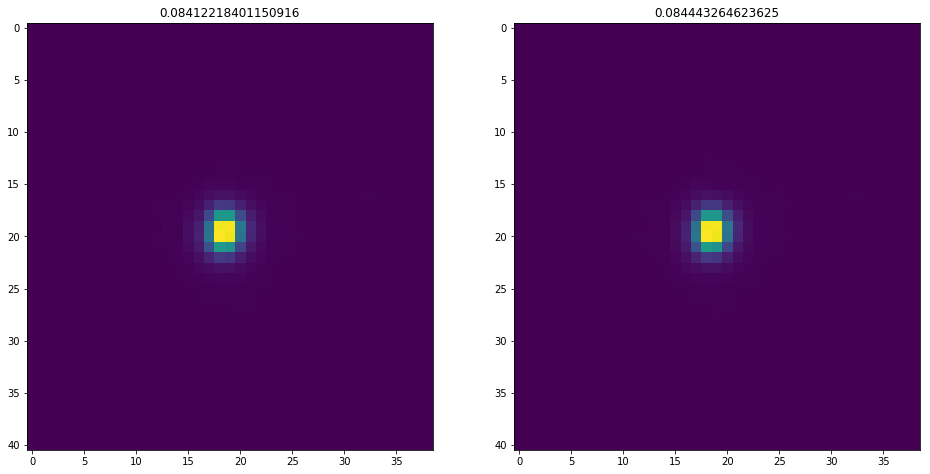

In [12]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches([16,12])
for i in range(coaddPsf.getComponentCount()):
    ## Get the point in the calexp corresponding to the chosen point on the codd, which is its center
    calexpPoint = deepCoadd.getPsf().getWcs(i).skyToPixel(coaddWcs.pixelToSky(midPoint))
    if deepCoadd.getPsf().getValidPolygon(i).contains(calexpPoint):
        xyTransform = afwGeom.makeWcsPairTransform(coaddPsf.getWcs(i), coaddWcs)
        
        for idx, order in enumerate([3,5]):
            warped_psf = measAlg.WarpedPsf(orig_psf, xyTransform, kernelName="lanczos{}".format(order))
            warped_psf_image = warped_psf.computeImage(midPoint)
            
            ax[idx].imshow(warped_psf_image.array)
            ax[idx].set_title(warped_psf_image.array.max())

#### Does using lanczos5 correctly reproduce the coadd PSF?

In [ ]:
for i in range(coaddPsf.getComponentCount()):
    ## Get the point in the calexp corresponding to the chosen point on the codd, which is its center
    calexpPoint = deepCoadd.getPsf().getWcs(i).skyToPixel(coaddWcs.pixelToSky(midPoint))
    if deepCoadd.getPsf().getValidPolygon(i).contains(calexpPoint):
        xyTransform = afwGeom.makeWcsPairTransform(coaddPsf.getWcs(i), coaddWcs)
        
        for idx, order in enumerate([3,5]):
            warped_psf = measAlg.WarpedPsf(orig_psf, xyTransform, kernelName="lanczos{}".format(order))
            warped_psf_image = warped_psf.computeImage(midPoint)
            
            ax[idx].imshow(warped_psf_image.array)
            ax[idx].set_title(warped_psf_image.array.max())